In [1]:
import torch, os, math, platform, random, copy, json
from math import floor
import torch._dynamo
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from torch.utils.data import random_split
from torch.amp import autocast, GradScaler

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())      # Should be True
print(torch.cuda.get_device_name(0))

2.5.1+cu124
True
NVIDIA GeForce RTX 4090


In [3]:
# Let CUDA pick the fastest kernels
torch.use_deterministic_algorithms(False)
torch._dynamo.config.capture_scalar_outputs = True
torch.backends.cudnn.benchmark = True
# Fully use Tensor Cores (TF32 on matmul + conv)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('high')  # enables TF32 fast path
# AMP config for 4090
USE_CUDA   = torch.cuda.is_available()
USE_BF16   = USE_CUDA  # 4090 supports bf16 very well
AMP_DTYPE  = torch.bfloat16 if USE_BF16 else torch.float16
USE_SCALER = False if USE_BF16 else USE_CUDA  # scaler only for fp16

In [4]:
def logln(msg=""):
    sys.stdout.write(str(msg) + "\n")
    sys.stdout.flush()

# Data Prep

In [5]:
file_paths = {
    "GreenhouseClimate": "/home/cuongdo/IUACAAS/GreenhouseClimate.csv",
    "GrodanSens": "/home/cuongdo/IUACAAS/GrodanSens.csv",
    "Resources": "/home/cuongdo/IUACAAS/Resources.csv",
    "Weather": "/home/cuongdo/Weather/Weather.csv",
    "CropParameters": "/home/cuongdo/IUACAAS/CropParameters.csv"
}

In [6]:
soil_cols = ['EC_slab1','EC_slab2','WC_slab1','WC_slab2','t_slab1','t_slab2']
indoor_cols = ['Tair','Rhair','HumDef','CO2air','PipeLow','VentLee','Ventwind','EC_drain_PC']
weather_cols = ['Tout','Rhout','Iglob','PARout','Pyrgeo','Rain','Windsp']
crop_cols = ['plant_dens','stem_dens','Cum_trusses','Stem_elong','Stem_thick']

In [7]:
dfs = {}
for name, path in file_paths.items():
    df = pd.read_csv(path, low_memory=False)
    df.columns = df.columns.str.strip().str.replace('\t', '', regex=False)
    # unify/derive datetime column -> Date
    if '%time' in df.columns or '%Time' in df.columns:
        tcol = '%time' if '%time' in df.columns else '%Time'
        df[tcol] = pd.to_numeric(df[tcol], errors='coerce')
        df['Date'] = pd.to_datetime(df[tcol], origin='1899-12-30', unit='D', errors='coerce')
    elif 'time' in df.columns:
        df['time'] = pd.to_numeric(df['time'], errors='coerce')
        df['Date'] = pd.to_datetime(df['time'], origin='1899-12-30', unit='D', errors='coerce')
    elif 'Date' in df.columns:
        if pd.api.types.is_numeric_dtype(df['Date']):
            df['Date'] = pd.to_datetime(df['Date'], origin='1899-12-30', unit='D', errors='coerce')
        else:
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    else:
        df['Date'] = pd.NaT
    # numeric coercion (keep Date intact)
    num_cols = [c for c in df.columns if c != 'Date']
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=['Date'])
    # cadence & aggregation
    if name in ('GreenhouseClimate', 'GrodanSens', 'Weather'):
        # 5-min streams → use FLOOR (never push into next day)
        df['Date'] = df['Date'].dt.floor('5min')
        df = df.groupby('Date', as_index=False).mean(numeric_only=True)
    elif name == 'Resources':
        # daily already; ensure unique per day via mean (robust vs duplicates)
        df['Date'] = df['Date'].dt.floor('D')
        df = (df.groupby('Date', as_index=False)
                .agg({c:'mean' for c in df.columns if c!='Date'}))
    elif name == 'CropParameters':
        # weekly/sparse; make daily grid later and ffill
        df['Date'] = df['Date'].dt.floor('D')
        df = df.groupby('Date', as_index=False).mean(numeric_only=True)
    dfs[name] = df.sort_values('Date').reset_index(drop=True)

In [8]:
print(dfs['Resources']['Date'])

0     2019-12-16
1     2019-12-17
2     2019-12-18
3     2019-12-19
4     2019-12-20
         ...    
161   2020-05-25
162   2020-05-26
163   2020-05-27
164   2020-05-28
165   2020-05-29
Name: Date, Length: 166, dtype: datetime64[ns]


In [9]:
def pick_cols(df: pd.DataFrame, want: list[str]) -> list[str]:
    return [c for c in want if c in df.columns]

soil_keep    = pick_cols(dfs['GrodanSens'],        soil_cols)
indoor_keep  = pick_cols(dfs['GreenhouseClimate'], indoor_cols)
weather_keep = pick_cols(dfs['Weather'],           weather_cols)
crop_keep    = pick_cols(dfs['CropParameters'],    crop_cols)

In [10]:
g5 = dfs['GrodanSens'][['Date'] + soil_keep].copy()
c5 = dfs['GreenhouseClimate'][['Date'] + indoor_keep].copy()
w5 = dfs['Weather'][['Date'] + weather_keep].copy()

In [11]:
def agg_daily_from_5min(df5: pd.DataFrame, cols: list[str], prefix: str) -> pd.DataFrame:
    """
    Aggregate 5-min streams into per-day stats for the requested columns.
    Safe merges: left_on='day' (datetime), right_index=True. Rename to Date at end.
    """
    if not cols:
        return pd.DataFrame({'Date': pd.to_datetime([])})

    tmp = df5[['Date'] + cols].copy()
    tmp['Date'] = pd.to_datetime(tmp['Date'])
    tmp['day']  = tmp['Date'].dt.floor('D')

    g = tmp.groupby('day')  # index = day (datetime64[ns])

    # Start with the day index
    out = pd.DataFrame({'day': g.size().index})

    for col in cols:
        # Means and std (as Series indexed by 'day')
        s_mean = g[col].mean()
        s_std  = g[col].std(ddof=0)

        out = out.merge(
            s_mean.rename(f'{prefix}{col}_mean'),
            left_on='day', right_index=True, how='left'
        )
        out = out.merge(
            s_std.rename(f'{prefix}{col}_std'),
            left_on='day', right_index=True, how='left'
        )

        # Quantiles as a 2-column DataFrame indexed by 'day'
        q = g[col].quantile([0.1, 0.9]).unstack()  # columns: {0.1, 0.9}
        q = q.rename(columns={0.1: f'{prefix}{col}_p10', 0.9: f'{prefix}{col}_p90'})
        out = out.merge(q, left_on='day', right_index=True, how='left')

        # Amplitude (p90 - p10)
        out[f'{prefix}{col}_amp'] = out[f'{prefix}{col}_p90'] - out[f'{prefix}{col}_p10']

        # Missingness fraction (count / 288)
        cnt = g[col].count()  # Series indexed by 'day'
        out = out.merge(cnt.rename(f'__cnt_{col}'), left_on='day', right_index=True, how='left')
        out[f'{prefix}{col}_miss'] = 1.0 - (out[f'__cnt_{col}'] / 288.0)
        out.drop(columns=[f'__cnt_{col}'], inplace=True)

    # Finalize
    out = out.sort_values('day').reset_index(drop=True)
    out = out.rename(columns={'day': 'Date'})
    return out

In [12]:
soil_day   = agg_daily_from_5min(g5, soil_keep,   'soil_')
indoor_day = agg_daily_from_5min(c5, indoor_keep, 'ind_')
weath_day  = agg_daily_from_5min(w5, weather_keep,'out_')

In [13]:
days_all = pd.date_range(g5['Date'].min().floor('D'), g5['Date'].max().floor('D'), freq='D')
_crop_src = dfs['CropParameters'][['Date'] + crop_keep].copy()
_crop_src['Date'] = pd.to_datetime(_crop_src['Date']).dt.floor('D')
crop_raw = (_crop_src.set_index('Date').reindex(days_all))              # true observation pattern
crop_d = (crop_raw.ffill().reset_index().rename(columns={'index':'Date'}))     # values fed to the model/merge

In [14]:
ELEC_PEAK, ELEC_OFF, HEAT_PER_MJ, AREA_M2 = 0.08, 0.04, 0.0083, 62.5
res = dfs['Resources'][['Date','ElecHigh','ElecLow','Heat_cons']].copy()
res['Date'] = pd.to_datetime(res['Date']).dt.floor('D')
# Daily kWh/MJ per m² → € per m² → € per house
res['Elec_day']     = res['ElecHigh'] + res['ElecLow']
res['Heat_day']     = res['Heat_cons']
res['elec_cost_m2'] = res['ElecHigh']*ELEC_PEAK + res['ElecLow']*ELEC_OFF
res['heat_cost_m2'] = res['Heat_day']*HEAT_PER_MJ
res['y']            = (res['elec_cost_m2'] + res['heat_cost_m2']) * AREA_M2
y_day = res[['Date','y','Elec_day','Heat_day','ElecHigh','ElecLow']].sort_values('Date').copy()
# Defensive: ensure unique columns (prevents DataFrame-when-Series bugs)
y_day = y_day.loc[:, ~y_day.columns.duplicated()]
assert y_day.columns.is_unique, f"Duplicate columns in y_day: {list(y_day.columns[y_day.columns.duplicated()])}"
# Next-day target for day-ahead prediction
y_day['y_next'] = y_day['y'].shift(-1)

In [33]:
def decay_summary(df: pd.DataFrame, label: str):
    miss_cols = [c for c in df.columns if c.endswith('_miss')]
    if not miss_cols:
        print(f"[{label}] No *_miss columns found."); return None

    d = df.sort_values('Date').reset_index(drop=True).copy()
    d['t'] = np.arange(len(d))  # 0..T-1 day index

    rows = []
    for c in miss_cols:
        m = d[c].astype(float).to_numpy()
        slope = np.polyfit(d['t'], m, 1)[0] if len(m) > 1 else 0.0
        delta = float(m[-1] - m[0]) if len(m) > 1 else 0.0
        share_gt10 = float((m > 0.10).mean())
        share_gt50 = float((m > 0.50).mean())
        # longest streak with miss > 0.5
        longest = 0; cur = 0
        for v in (m > 0.50).astype(int):
            cur = cur + 1 if v else 0
            longest = max(longest, cur)
        rows.append({
            "var": c,
            "mean_miss": float(np.nanmean(m)),
            "median_miss": float(np.nanmedian(m)),
            "max_miss": float(np.nanmax(m)),
            "share_days>10%": share_gt10,
            "share_days>50%": share_gt50,
            "longest_streak>50%": int(longest),
            "slope_per_day": float(slope),
            "delta_period": delta
        })

    out = pd.DataFrame(rows).sort_values(["slope_per_day","mean_miss"], ascending=[False,False])
    out["decay_flag"] = (
        (out["slope_per_day"] >= 0.001) |   # >= +10% over 100 days
        (out["delta_period"] >= 0.10)   |   # end-start jump >= 10%
        (out["longest_streak>50%"] >= 7)    # ≥ 7 straight bad days
    )
    print(f"[{label}] avg(mean_miss)={out['mean_miss'].mean():.3f} | decaying vars: {int(out['decay_flag'].sum())}/{len(out)}")
    return out

soil_decay  = decay_summary(soil_day,   "SOIL")
ind_decay   = decay_summary(indoor_day, "INDOOR")
weath_decay = decay_summary(weath_day,  "WEATHER")

[SOIL] avg(mean_miss)=0.264 | decaying vars: 0/6
[INDOOR] avg(mean_miss)=0.228 | decaying vars: 8/8
[WEATHER] avg(mean_miss)=0.228 | decaying vars: 7/7


In [17]:
K = 8
assert K >= 7, "Need K ≥ 7 to build y_prev7 and y_diff7."
rs = y_day.set_index('Date')
hist = pd.DataFrame({'Date': y_day['Date']})
for i in range(1, K+1):
    hist[f'y_prev{i}'] = rs['y'].shift(i).reindex(hist['Date']).values

In [18]:
daily = (
    pd.DataFrame({'Date': pd.to_datetime(y_day['Date'])})
      .merge(soil_day,   on='Date', how='left')
      .merge(indoor_day, on='Date', how='left')
      .merge(weath_day,  on='Date', how='left')
      .merge(crop_d,     on='Date', how='left')          # crop (daily)
      .merge(hist,       on='Date', how='left')          # y_prev*
      .merge(y_day[['Date','y','y_next']], on='Date', how='left')
      .sort_values('Date').reset_index(drop=True)
)
# Anchors (exactly 5)
daily['y_today'] = daily['y']
assert {'y_prev1','y_prev7'}.issubset(daily.columns), "Missing y_prev1 or y_prev7"
daily['y_diff1'] = daily['y_today'] - daily['y_prev1']
daily['y_diff7'] = daily['y_today'] - daily['y_prev7']
# Keep only rows with valid next-day target
daily = daily[np.isfinite(daily['y_next'])].reset_index(drop=True)
assert daily['Date'].is_monotonic_increasing and daily['Date'].nunique() == len(daily)

In [19]:
# --- Prev-1 baseline (predict y_next with y_today) ---
y_true      = daily['y_next'].to_numpy(dtype=float)
yhat_prev1  = daily['y_today'].to_numpy(dtype=float)

mask1 = np.isfinite(y_true) & np.isfinite(yhat_prev1)
mae_p1  = np.mean(np.abs(yhat_prev1[mask1] - y_true[mask1]))
rmse_p1 = np.sqrt(np.mean((yhat_prev1[mask1] - y_true[mask1])**2))
print(f"Prev-1 baseline | TEST MAE={mae_p1:.6f} RMSE={rmse_p1:.6f}")
rmse_model = 0.359655
mae_model  = 0.271090
skill1 = 1.0 - (rmse_model / rmse_p1)
print(f"Skill vs prev-1 (RMSE) = {skill1*100:.2f}%")

Prev-1 baseline | TEST MAE=0.481874 RMSE=0.838861
Skill vs prev-1 (RMSE) = 57.13%


In [20]:
crop_cols    = crop_keep[:]  # crop = CropParameters only
CROP_DIM     = len(crop_cols)
ANCHOR_COLS  = ['y_today','y_prev1','y_prev7','y_diff1','y_diff7']
assert all(c in daily.columns for c in ANCHOR_COLS), f"Anchor cols missing: {[c for c in ANCHOR_COLS if c not in daily.columns]}"
ANCHOR_DIM   = 5

In [21]:
g5i = g5.set_index('Date')
c5i = c5.set_index('Date')
w5i = w5.set_index('Date')

def day_grid(d):
    d = pd.to_datetime(d).floor('D')
    return pd.date_range(d, d + pd.Timedelta(days=1) - pd.Timedelta(minutes=5), freq='5min')

def reindex_full_day(df_idx, cols, d):
    grid = day_grid(d)
    block = df_idx.reindex(grid)
    for c in cols:
        if c not in block.columns:
            block[c] = np.nan
    return block[cols].to_numpy(dtype=float, copy=False)

def steps_since_last_obs_day(mask_2d: np.ndarray) -> np.ndarray:
    T, D = mask_2d.shape
    delta = np.zeros((T, D), dtype=np.float32)
    last  = np.zeros(D, dtype=np.float32)
    for t in range(T):
        last = np.where(mask_2d[t] > 0.0, 0.0, last + 1.0)
        delta[t] = last
    np.minimum(delta, 3*288, out=delta)
    return delta

def days_since_last_obs_per_feature(X_2d: np.ndarray, max_cap: int = 365) -> np.ndarray:
    N, D = X_2d.shape
    m = np.isfinite(X_2d)
    delta = np.full((N, D), np.nan, dtype=float)
    last = np.full(D, -np.inf, dtype=float)
    for i in range(N):
        last = np.where(m[i], i, last)
        delta[i] = i - last
    return np.clip(delta, 0, max_cap).astype(np.float32)

In [22]:
soil_list, soil_mask_list, soil_delta_list = [], [], []
indoor_list, indoor_mask_list, indoor_delta_list = [], [], []
weather_list, weather_mask_list, weather_delta_list = [], [], []
crop_rows, anchor_rows = [], []
y_list, date_list = [], []

In [23]:
for d in daily['Date']:
    s  = reindex_full_day(g5i, soil_keep,   d).astype(np.float32)
    e  = reindex_full_day(c5i, indoor_keep, d).astype(np.float32)
    ww = reindex_full_day(w5i, weather_keep,d).astype(np.float32)
    sm = np.isfinite(s).astype(np.float32); sd  = steps_since_last_obs_day(sm).astype(np.float32)
    im = np.isfinite(e).astype(np.float32); idl = steps_since_last_obs_day(im).astype(np.float32)
    wm = np.isfinite(ww).astype(np.float32); wd  = steps_since_last_obs_day(wm).astype(np.float32)
    row = daily.loc[daily['Date'] == d].iloc[0]
    crop_vec   = (row[crop_cols].to_numpy(dtype=float, copy=False).astype(np.float32)
                  if CROP_DIM > 0 else np.zeros((0,), np.float32))
    anchor_vec = row[ANCHOR_COLS].to_numpy(dtype=float, copy=False).astype(np.float32)
    soil_list.append(s);     soil_mask_list.append(sm);     soil_delta_list.append(sd)
    indoor_list.append(e);   indoor_mask_list.append(im);   indoor_delta_list.append(idl)
    weather_list.append(ww); weather_mask_list.append(wm);  weather_delta_list.append(wd)
    crop_rows.append(crop_vec); anchor_rows.append(anchor_vec)
    y_list.append([float(row['y_next'])])
    date_list.append(pd.to_datetime(d))

In [24]:
# ---------- Stack to numpy ----------
soil_np      = np.stack(soil_list)         # [N,288,Ds]
soil_m_np    = np.stack(soil_mask_list)
soil_d_np    = np.stack(soil_delta_list)
indoor_np    = np.stack(indoor_list)       # [N,288,Di]
indoor_m_np  = np.stack(indoor_mask_list)
indoor_d_np  = np.stack(indoor_delta_list)
weather_np   = np.stack(weather_list)      # [N,288,Dw]
weather_m_np = np.stack(weather_mask_list)
weather_d_np = np.stack(weather_delta_list)
crop_np      = (np.vstack(crop_rows) if CROP_DIM > 0 else np.zeros((len(date_list), 0), np.float32))      # [N, CROP_DIM]
anchor_np    = np.vstack(anchor_rows).astype(np.float32)             # [N, 5]
y_np         = np.array(y_list, dtype=np.float32)                    # [N,1]
dates_all    = np.array(date_list, dtype='datetime64[ns]')

In [25]:
if CROP_DIM > 0:
    # Align the RAW (non-ffilled) grid to the exact days we kept in `daily`
    crop_raw_sel = (crop_raw
                    .reindex(pd.to_datetime(date_list))  # DatetimeIndex; same order as `daily`
                    .to_numpy(dtype=float))
    crop_mask_np  = np.isfinite(crop_raw_sel).astype(np.float32)
    crop_delta_np = days_since_last_obs_per_feature(crop_raw_sel)
else:
    crop_mask_np  = np.zeros_like(crop_np, np.float32)
    crop_delta_np = np.zeros_like(crop_np, np.float32)
# ---------- Anchor mask/delta ----------
anchor_mask_np  = np.isfinite(anchor_np).astype(np.float32)
anchor_delta_np = days_since_last_obs_per_feature(anchor_np)
# ---------- Torch tensors ----------
to_t = lambda x: torch.tensor(x, dtype=torch.float32)
soil_all = to_t(soil_np);
soil_mask   = to_t(soil_m_np);
soil_delta   = to_t(soil_d_np)
indoor_all = to_t(indoor_np);
indoor_mask = to_t(indoor_m_np);
indoor_delta = to_t(indoor_d_np)
weather_all = to_t(weather_np);
weather_mask= to_t(weather_m_np); weather_delta= to_t(weather_d_np)
crop_all = to_t(crop_np) # CROP (daily values, ffilled)
crop_mask = to_t(crop_mask_np)    # mask from RAW observation pattern
crop_delta = to_t(crop_delta_np)  # age (days since last true obs), from RAW
anchor_all = to_t(anchor_np) # ANCHOR (5 features)
anchor_mask  = to_t(anchor_mask_np) # ~1s (clean) else 0 where missing
anchor_delta = to_t(anchor_delta_np)# ~0s (clean) else days since last obs
y_all = to_t(y_np) # label = y_next

In [26]:
dates_np = np.array(dates_all, dtype='datetime64[ns]')
assert dates_np.ndim == 1 and dates_np.size > 1, f"Bad dates_all shape: {dates_np.shape}"
assert np.all(dates_np[1:] >= dates_np[:-1]), "dates_all must be non-decreasing (chronological)."

N = len(dates_np)
# --- ratios  ---
tr_frac = 0.60
va_frac = 0.20
te_frac = 1.0 - tr_frac - va_frac
assert 0 < tr_frac < 1 and 0 < va_frac < 1 and te_frac > 0, "Bad split fractions."
gap_days_tr_va = 0
gap_days_va_te = 0
i_tr_end = int(np.floor(tr_frac * N)) - 1
i_va_end = int(np.floor((tr_frac + va_frac) * N)) - 1
def advance_to_after(date_arr, start_idx, min_date):
    while start_idx < len(date_arr) and date_arr[start_idx] <= min_date:
        start_idx += 1
    return start_idx
if gap_days_tr_va > 0:
    va_start_min = dates_np[i_tr_end] + np.timedelta64(gap_days_tr_va, 'D')
    va_start_idx = advance_to_after(dates_np, i_tr_end + 1, va_start_min)
else:
    va_start_idx = i_tr_end + 1
if gap_days_va_te > 0:
    te_start_min = dates_np[i_va_end] + np.timedelta64(gap_days_va_te, 'D')
    te_start_idx = advance_to_after(dates_np, i_va_end + 1, te_start_min)
else:
    te_start_idx = i_va_end + 1
# Guardrails (ensure non-empty splits)
assert i_tr_end >= 0, "Train split too small."
assert i_va_end >= i_tr_end, "Val boundary must be after train."
assert te_start_idx < N, "Test split would be empty."
assert va_start_idx <= i_va_end, "Val split became empty after applying gaps."

In [27]:
train_ix = np.arange(0, i_tr_end + 1, dtype=int)
val_ix   = np.arange(va_start_idx, i_va_end + 1, dtype=int)
test_ix  = np.arange(te_start_idx, N, dtype=int)
# Sanity prints
print(f"[SPLIT-{int(tr_frac*100)}/{int(va_frac*100)}/{int(te_frac*100)}] N={N}")
print(f"  Train: n={len(train_ix)} | {dates_np[train_ix[0]]} → {dates_np[train_ix[-1]]}")
print(f"  Val:   n={len(val_ix)}   | {dates_np[val_ix[0]]} → {dates_np[val_ix[-1]]}")
print(f"  Test:  n={len(test_ix)}  | {dates_np[test_ix[0]]} → {dates_np[test_ix[-1]]}")

[SPLIT-60/20/20] N=165
  Train: n=99 | 2019-12-16T00:00:00.000000000 → 2020-03-23T00:00:00.000000000
  Val:   n=33   | 2020-03-24T00:00:00.000000000 → 2020-04-25T00:00:00.000000000
  Test:  n=33  | 2020-04-26T00:00:00.000000000 → 2020-05-28T00:00:00.000000000


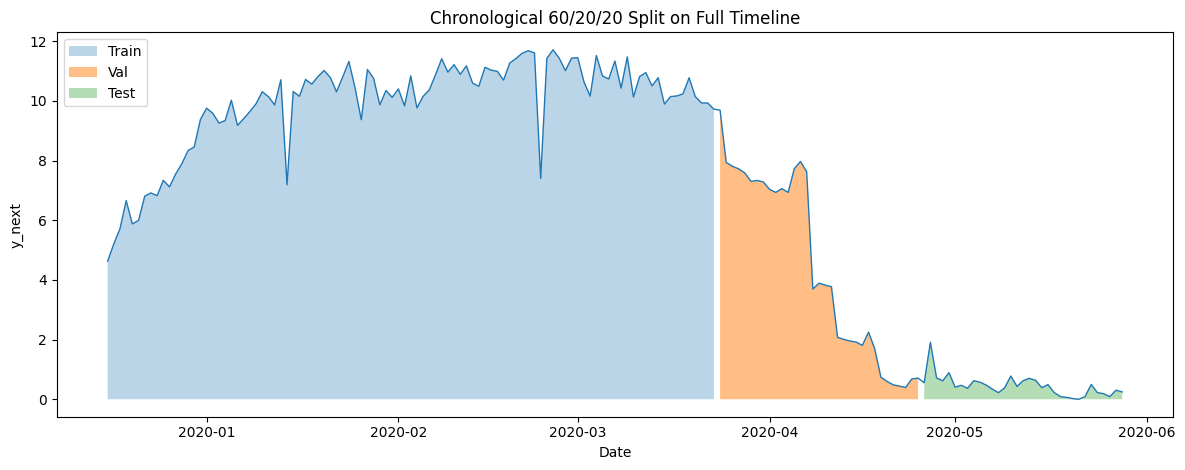

In [28]:
# Make boolean masks for the full timeline (useful for plotting/joins)
train_mask = np.zeros(N, dtype=bool); train_mask[train_ix] = True
val_mask   = np.zeros(N, dtype=bool); val_mask[val_ix]     = True
test_mask  = np.zeros(N, dtype=bool); test_mask[test_ix]   = True

# Optional: quick timeline plot to verify
y_np = y_all.detach().cpu().numpy().reshape(-1)
dates_pd = pd.to_datetime(dates_np)

plt.figure(figsize=(12, 4.8))
# Train
plt.fill_between(dates_pd, y_np, 0, where=train_mask, alpha=0.30, label="Train")
# Val
plt.fill_between(dates_pd, y_np, 0, where=val_mask,   alpha=0.50, label="Val")
# Test
plt.fill_between(dates_pd, y_np, 0, where=test_mask,  alpha=0.35, label="Test")
# Target curve
plt.plot(dates_pd, y_np, linewidth=1.0, zorder=3)

plt.title("Chronological 60/20/20 Split on Full Timeline")
plt.xlabel("Date"); plt.ylabel("y_next")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [29]:
# ---------- GPU & pin helpers ----------
def _is_cuda_device(dev) -> bool:
    if isinstance(dev, torch.device):
        return dev.type == "cuda"
    if isinstance(dev, str):
        return dev.lower().startswith("cuda")
    return str(dev).lower().startswith("cuda")

def _assert_cuda_4090(device) -> None:
    """Hard guard: ensure we're on an RTX 4090."""
    if not _is_cuda_device(device):
        raise AssertionError(f"Expected CUDA device, got {device!r}")
    dev = torch.device(device) if not isinstance(device, torch.device) else device
    idx = dev.index if dev.index is not None else torch.cuda.current_device()
    name = torch.cuda.get_device_name(idx)
    if "4090" not in name and "RTX 4090" not in name:
        raise AssertionError(f"Expected RTX 4090, got '{name}' at cuda:{idx}")

class _CudaPrefetcher:
    def __init__(self, loader: DataLoader, device: torch.device | str):
        self.loader = loader
        self.device = torch.device(device) if not isinstance(device, torch.device) else device
        self.stream = torch.cuda.Stream(device=self.device)

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        it = iter(self.loader)
        next_batch = None

        def _to_cuda(batch):
            out = []
            for t in batch:
                out.append(t.to(self.device, non_blocking=True) if isinstance(t, torch.Tensor) else t)
            return out

        # prefetch first
        with torch.cuda.stream(self.stream):
            try:
                next_batch = _to_cuda(next(it))
            except StopIteration:
                next_batch = None

        while next_batch is not None:
            torch.cuda.current_stream(self.device).wait_stream(self.stream)
            batch = next_batch

            # prefetch next
            with torch.cuda.stream(self.stream):
                try:
                    next_batch = _to_cuda(next(it))
                except StopIteration:
                    next_batch = None

            yield batch

# ---------- your original helpers ----------
def _as_cpu_indices(ix, N: int, allow_empty: bool = False) -> torch.Tensor:
    if isinstance(ix, np.ndarray):
        if ix.dtype == np.bool_:
            assert ix.shape[0] == N, f"bool mask len {ix.shape[0]} != N={N}"
            ix = np.nonzero(ix)[0]
        ix = torch.from_numpy(ix)
    elif isinstance(ix, torch.Tensor):
        ix = ix.detach().cpu()
        if ix.dtype == torch.bool:
            assert ix.numel() == N, f"bool mask len {ix.numel()} != N={N}"
            ix = ix.nonzero(as_tuple=False).squeeze(1)
    else:
        if isinstance(ix, (list, tuple)):
            ix = torch.tensor(ix, dtype=torch.long)
        elif isinstance(ix, (int, np.integer)):
            ix = torch.tensor([int(ix)], dtype=torch.long)
        else:
            raise TypeError(f"Unsupported index type: {type(ix)}")

    ix = ix.to(torch.long).view(-1)
    if ix.numel() == 0:
        assert allow_empty, "empty index set"
        return ix

    mn, mx = int(ix.min()), int(ix.max())
    assert 0 <= mn <= mx < N, f"index out of range: min={mn}, max={mx}, N={N}"
    return ix

def _nanmean_std(x: torch.Tensor, dim=0, eps: float = 1e-6, keepdim: bool = False):
    finite = torch.isfinite(x)
    x0 = torch.where(finite, x, torch.zeros_like(x))
    cnt = finite.sum(dim=dim, keepdim=True).clamp_min(1)
    mean = x0.sum(dim=dim, keepdim=True) / cnt
    var = torch.where(finite, (x0 - mean) ** 2, torch.zeros_like(x0)).sum(dim=dim, keepdim=True) / cnt
    std = torch.sqrt(var + eps)
    if not keepdim:
        mean = mean.squeeze(dim)
        std  = std.squeeze(dim)
    return mean, std.clamp_min(eps)

def _fit_fold_scaler(core_cpu: torch.Tensor, ix_cpu: torch.Tensor | None, eps: float = 1e-6):
    x = core_cpu if (ix_cpu is None or ix_cpu.numel() == 0) else core_cpu[ix_cpu]
    mu, std = _nanmean_std(x, dim=0, eps=eps)
    mu = torch.nan_to_num(mu, nan=0.0)
    std = torch.nan_to_num(std, nan=1.0).clamp_min(eps)
    return mu, std

# ---------- make_loader with strict 4090 check + correct pinning ----------
def make_loader(ix,
                shuffle: bool,
                *,
                data: dict,
                scale: dict | None,
                device: torch.device | str = torch.device("cuda:0"),
                batch_size: int | None = None,
                prefer_full_batch: bool = False,
                num_workers: int = 0,
                crop_dim: int | None = None,
                return_prefetcher: bool = False):
    """
    Returns a CPU DataLoader with pinned memory (best practice) and, optionally, a CUDA
    prefetching wrapper that yields GPU tensors (set return_prefetcher=True and then remove
    your train-loop to_device() copies).
    """
    # --- enforce RTX 4090 target (as requested) ---
    _assert_cuda_4090(device)

    # --- unpack (same as yours) ---
    soil_all    = data["soil_all"];     soil_mask   = data["soil_mask"];     soil_delta   = data["soil_delta"]
    indoor_all  = data["indoor_all"];   indoor_mask = data["indoor_mask"];   indoor_delta = data["indoor_delta"]
    weather_all = data["weather_all"];  weather_mask= data["weather_mask"];  weather_delta= data["weather_delta"]

    crop_all    = data["crop_all"];     crop_mask   = data["crop_mask"];     crop_delta   = data["crop_delta"]
    anchor_all  = data["anchor_all"];   anchor_mask = data["anchor_mask"];   anchor_delta = data["anchor_delta"]

    y_all       = data["y_all"]

    # --- move masters to CPU for safe indexing/scaler fit ---
    to_cpu = lambda t: t if t.device.type == "cpu" else t.detach().cpu()
    soil_all, soil_mask, soil_delta         = map(to_cpu, (soil_all, soil_mask, soil_delta))
    indoor_all, indoor_mask, indoor_delta   = map(to_cpu, (indoor_all, indoor_mask, indoor_delta))
    weather_all, weather_mask, weather_delta= map(to_cpu, (weather_all, weather_mask, weather_delta))
    crop_all, crop_mask, crop_delta         = map(to_cpu, (crop_all, crop_mask, crop_delta))
    anchor_all, anchor_mask, anchor_delta   = map(to_cpu, (anchor_all, anchor_mask, anchor_delta))
    y_all = to_cpu(y_all)

    # --- checks (unchanged) ---
    N = int(soil_all.size(0))
    assert all(int(t.size(0)) == N for t in [
        soil_mask, soil_delta, indoor_all, indoor_mask, indoor_delta,
        weather_all, weather_mask, weather_delta,
        crop_all, crop_mask, crop_delta,
        anchor_all, anchor_mask, anchor_delta, y_all
    ]), "size(0) mismatch"
    assert soil_all.shape    == soil_mask.shape    == soil_delta.shape,    "soil shape mismatch"
    assert indoor_all.shape  == indoor_mask.shape  == indoor_delta.shape,  "indoor shape mismatch"
    assert weather_all.shape == weather_mask.shape == weather_delta.shape, "weather shape mismatch"
    assert crop_all.dim()==2 and crop_mask.shape==crop_all.shape and crop_delta.shape==crop_all.shape, "crop dims mismatch"
    assert anchor_all.dim()==2 and anchor_mask.shape==anchor_all.shape and anchor_delta.shape==anchor_all.shape, "anchor dims mismatch"
    assert int(anchor_all.size(1)) == 5, "anchors must be [y_today, y_prev1, y_prev7, y_diff1, y_diff7] (5 cols)"

    # --- indices & crop z-scale ---
    ix_cpu = _as_cpu_indices(ix, N, allow_empty=True)

    D_crop = int(crop_all.size(1))
    crop_d = D_crop if crop_dim is None else int(crop_dim)
    assert crop_d == D_crop, f"crop_dim mismatch: {crop_d} vs {D_crop}"

    if scale is None:
        scale = {"mu": None, "std": None}
    need_fit = (scale["mu"] is None) or (scale["std"] is None) \
               or (scale["mu"].numel() != crop_d) or (scale["std"].numel() != crop_d)

    crop_cpu = crop_all[:, :crop_d].clone()
    if shuffle or need_fit:
        mu, std = _fit_fold_scaler(crop_cpu, ix_cpu)
        scale["mu"], scale["std"] = mu, std
    else:
        mu, std = scale["mu"], scale["std"]
        mu  = torch.nan_to_num(mu,  nan=0.0)
        std = torch.nan_to_num(std, nan=1.0).clamp_min(1e-6)

    crop_z = torch.nan_to_num((crop_cpu - mu) / std, nan=0.0, posinf=0.0, neginf=0.0)

    # --- select split ---
    def _sel(x): return x[ix_cpu] if ix_cpu.numel() > 0 else x[:0].clone()

    parts = [
        _sel(soil_all),    _sel(soil_mask),    _sel(soil_delta),
        _sel(indoor_all),  _sel(indoor_mask),  _sel(indoor_delta),
        _sel(weather_all), _sel(weather_mask), _sel(weather_delta),

        _sel(crop_z),      _sel(crop_mask),    _sel(crop_delta),
        _sel(anchor_all),  _sel(anchor_mask),  _sel(anchor_delta),

        _sel(y_all),
    ]
    ds = TensorDataset(*parts)

    # --- batch size ---
    if batch_size is None:
        bs = max(1, min(len(ix_cpu), 64)) if shuffle else max(1, min(len(ix_cpu), 256))
    else:
        bs = (len(ix_cpu) if (prefer_full_batch and len(ix_cpu) > 0)
              else min(max(1, batch_size), max(1, len(ix_cpu))))

    # --- pinned host loader (correct pin flag for any 'cuda:*') ---
    pin = _is_cuda_device(device)
    loader = DataLoader(
        ds,
        batch_size=bs,
        shuffle=shuffle,
        drop_last=False,
        num_workers=int(num_workers),
        pin_memory=pin,
        **({"persistent_workers": True, "prefetch_factor": 2} if num_workers and num_workers > 0 else {})
    )

    # By default keep your current training loop behavior (explicit to_device()).
    # If you want batches already on GPU from the loader, set return_prefetcher=True
    # AND remove your to_device(...) call in the loop.
    if return_prefetcher:
        return _CudaPrefetcher(loader, device)
    return loader

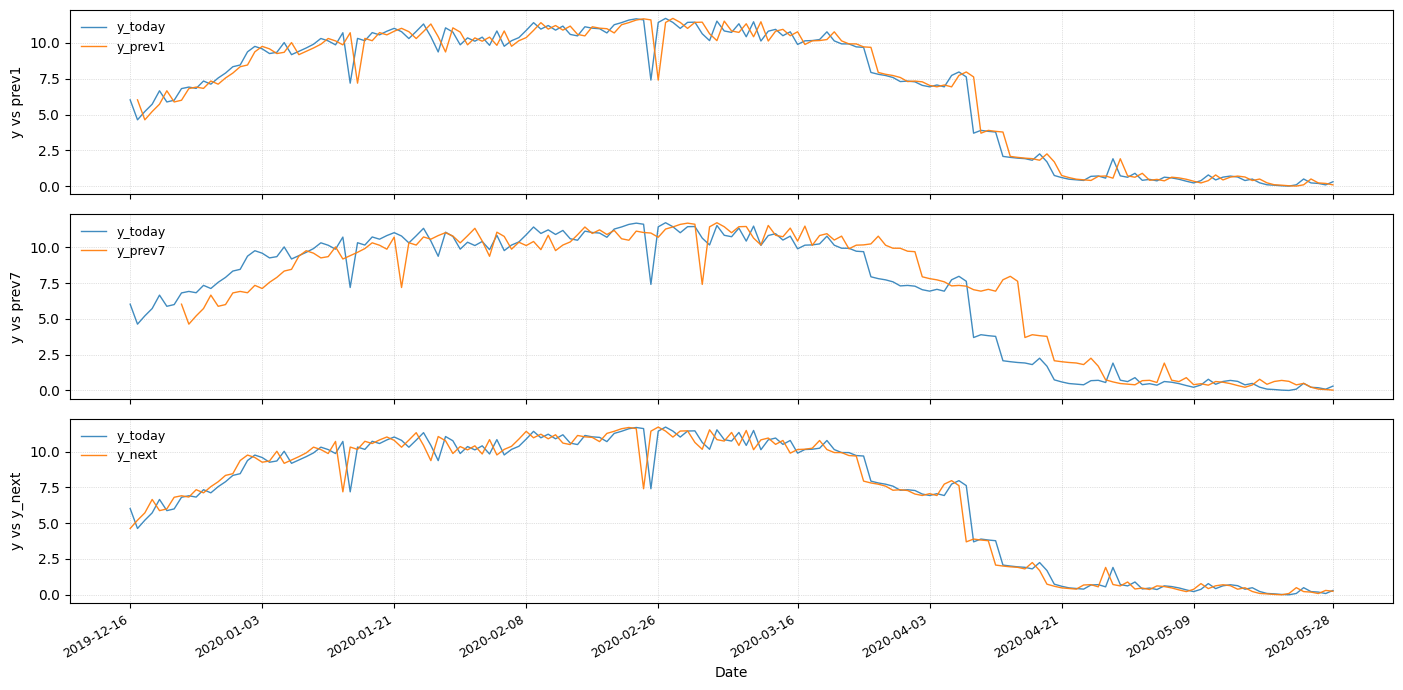

In [30]:
# --- Minimal frame from your pipeline ---
plot_df = (
    daily[['Date', 'y_today', 'y_prev1', 'y_prev7', 'y_next']]
    .sort_values('Date')
    .reset_index(drop=True)
)

# If you want to limit the window and already defined N_DAYS elsewhere, this respects it.
if 'N_DAYS' in globals() or 'N_DAYS' in locals():
    plot_df = plot_df.iloc[:min(int(N), len(plot_df))]

# --- X axis positions and labels ---
x = np.arange(len(plot_df))
date_labels = plot_df['Date'].dt.strftime('%Y-%m-%d')

# --- Plot: y_today vs prev1 / prev7 / y_next ---
fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

# Panel 1: y_today vs y_prev1
axes[0].plot(x, plot_df['y_today'].to_numpy(), lw=1, alpha=0.85, label='y_today')
axes[0].plot(x, plot_df['y_prev1'].to_numpy(), lw=1, alpha=0.95, label='y_prev1')
axes[0].set_ylabel('y vs prev1')
axes[0].legend(loc='upper left', fontsize=9, frameon=False)

# Panel 2: y_today vs y_prev7
axes[1].plot(x, plot_df['y_today'].to_numpy(), lw=1, alpha=0.85, label='y_today')
axes[1].plot(x, plot_df['y_prev7'].to_numpy(), lw=1, alpha=0.95, label='y_prev7')
axes[1].set_ylabel('y vs prev7')
axes[1].legend(loc='upper left', fontsize=9, frameon=False)

# Panel 3: y_today vs y_next
axes[2].plot(x, plot_df['y_today'].to_numpy(), lw=1, alpha=0.85, label='y_today')
axes[2].plot(x, plot_df['y_next'].to_numpy(),  lw=1, alpha=0.95, label='y_next')
axes[2].set_ylabel('y vs y_next')
axes[2].legend(loc='upper left', fontsize=9, frameon=False)

# Cosmetics
for ax in axes:
    ax.grid(True, ls=':', lw=0.5, alpha=0.75)

ticks = np.linspace(0, len(x)-1, num=min(10, len(x)), dtype=int)
axes[-1].set_xticks(ticks)
axes[-1].set_xticklabels([date_labels.iloc[t] for t in ticks], rotation=30, ha='right', fontsize=9)
axes[-1].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [38]:
def classify_coverage(df, label):
    miss_cols = [c for c in df.columns if c.endswith('_miss')]
    if not miss_cols:
        return {"label": label, "severity": "N/A", "avg_coverage": float('nan')}
    day_cov = 1.0 - df[miss_cols].astype(float).mean(axis=1)  # per-day coverage across vars
    avg_cov = float(day_cov.mean())
    # your bands
    if avg_cov >= 0.85:
        sev = "Mild"
    elif avg_cov >= 0.70:
        sev = "Moderate"
    else:
        sev = "Severe"
    return {"label": label, "severity": sev, "avg_coverage": avg_cov}

cov_soil   = classify_coverage(soil_day,   "SOIL")
cov_indoor = classify_coverage(indoor_day, "INDOOR")
cov_weath  = classify_coverage(weath_day,  "WEATHER")

def summarize_for_journal(cov, decay_df):
    k = int(decay_df["decay_flag"].sum())
    n = int(len(decay_df))
    return f"{cov['label']}: coverage={cov['avg_coverage']*100:.1f}% → {cov['severity']} | decay flags={k}/{n}"

print(summarize_for_journal(cov_soil, soil_decay))
print(summarize_for_journal(cov_indoor, ind_decay))
print(summarize_for_journal(cov_weath, weath_decay))

SOIL: coverage=73.6% → Moderate | decay flags=0/6
INDOOR: coverage=77.2% → Moderate | decay flags=8/8
WEATHER: coverage=77.2% → Moderate | decay flags=7/7


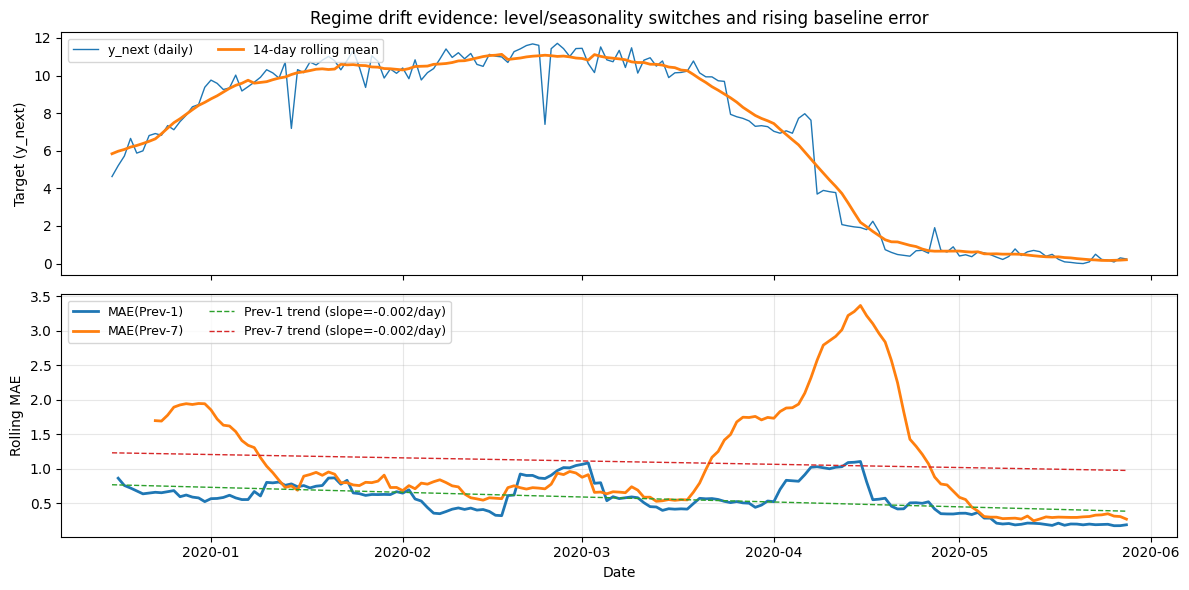

Detected regime-change dates: []
Rolling MAE trends: Prev-1 slope=-0.002/day, Prev-7 slope=-0.002/day


In [39]:
# --- helper: mean-shift change points on a 1D series ---
def detect_mean_shift_breaks(y: np.ndarray, window: int = 21, z_thresh: float = 1.5):
    y = np.asarray(y, dtype=float)
    T = len(y)
    if T < 2*window + 1:
        return np.array([], dtype=int), np.full(T, np.nan)

    s = pd.Series(y)
    prev_mean = s.rolling(window=window, min_periods=window).mean().to_numpy()
    next_mean = s.shift(-window+1).rolling(window=window, min_periods=window).mean().to_numpy()

    z = (next_mean - prev_mean) / (np.nanstd(y) + 1e-9)
    cand = np.where(np.isfinite(z) & (np.abs(z) >= z_thresh))[0]

    # merge nearby candidates into single breaks
    breaks = []
    for ix in cand:
        if not breaks or ix - breaks[-1] > window:
            breaks.append(int(ix))
    return np.array(breaks, dtype=int), z

# assumes you already defined _linfit_slope(y) earlier (your version handles NaNs)
def one_plot_drift_proof(daily: pd.DataFrame, weath_day: pd.DataFrame | None = None,
                         driver_col: str = 'out_Tout_mean', window:int=21, z_thresh:float=1.5):
    # --- data prep
    d = (daily[['Date','y_next','y_prev1','y_prev7']]
         .dropna(subset=['y_next'])
         .sort_values('Date')
         .reset_index(drop=True))
    dates = pd.to_datetime(d['Date'])
    y = d['y_next'].to_numpy()

    # smooth target for context
    roll_y = pd.Series(y).rolling(14, min_periods=3, center=True).mean().to_numpy()

    # change-points on target
    breaks, z = detect_mean_shift_breaks(y, window=window, z_thresh=z_thresh)

    # rolling anchor errors (MAE)
    e1 = (d['y_next'] - d['y_prev1']).abs()
    e7 = (d['y_next'] - d['y_prev7']).abs()
    mae1 = e1.rolling(14, min_periods=7, center=True).mean().to_numpy()
    mae7 = e7.rolling(14, min_periods=7, center=True).mean().to_numpy()

    s1, b1 = _linfit_slope(mae1)  # day slope of Prev-1 error
    s7, b7 = _linfit_slope(mae7)  # day slope of Prev-7 error
    tr1 = b1 + s1*np.arange(len(mae1))
    tr7 = b7 + s7*np.arange(len(mae7))

    # optional driver overlay (e.g., outdoor temp) to visually link seasons
    drv_scaled = None
    if weath_day is not None and driver_col in weath_day.columns:
        md = weath_day[['Date', driver_col]].copy()
        md['Date'] = pd.to_datetime(md['Date'])
        m = pd.merge(d[['Date']], md, on='Date', how='left')[driver_col].astype(float).to_numpy()
        if np.isfinite(m).sum() > 5:
            m = (m - np.nanmean(m)) / (np.nanstd(m) + 1e-9)
            m = m * (np.nanstd(y)) + np.nanmean(y)
            drv_scaled = m

    # --- plot (single figure with 2 rows)
    fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True)

    # (A) target with breaks
    axes[0].plot(dates, y, linewidth=1, label='y_next (daily)')
    axes[0].plot(dates, roll_y, linewidth=2, label='14-day rolling mean')
    if drv_scaled is not None:
        axes[0].plot(dates, drv_scaled, linewidth=1, label=f'{driver_col} (scaled)')
    for ix in breaks:
        if 0 <= ix < len(dates):
            axes[0].axvline(dates.iloc[ix], linestyle='--', linewidth=1)
    axes[0].set_ylabel('Target (y_next)')
    axes[0].set_title('Regime drift evidence: level/seasonality switches and rising baseline error')

    # (B) rolling anchor MAE with trends
    axes[1].plot(dates, mae1, linewidth=2, label='MAE(Prev-1)')
    axes[1].plot(dates, mae7, linewidth=2, label='MAE(Prev-7)')
    axes[1].plot(dates, tr1, linestyle='--', linewidth=1, label=f'Prev-1 trend (slope={s1:+.3f}/day)')
    axes[1].plot(dates, tr7, linestyle='--', linewidth=1, label=f'Prev-7 trend (slope={s7:+.3f}/day)')
    axes[1].set_ylabel('Rolling MAE')
    axes[1].set_xlabel('Date')
    axes[1].grid(True, alpha=0.3)

    # legends & layout
    axes[0].legend(loc='upper left', ncol=3, fontsize=9)
    axes[1].legend(loc='upper left', ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

    # journal text helpers
    print("Detected regime-change dates:", [dates.iloc[i].date() for i in breaks])
    print(f"Rolling MAE trends: Prev-1 slope={s1:+.3f}/day, Prev-7 slope={s7:+.3f}/day")

# ---- Run (after your code above has built `daily`, and optionally `weath_day`) ----
# one_plot_drift_proof(daily, weath_day=weath_day, driver_col='out_Tout_mean', window=21, z_thresh=1.5)
one_plot_drift_proof(daily)  # without driver overlay

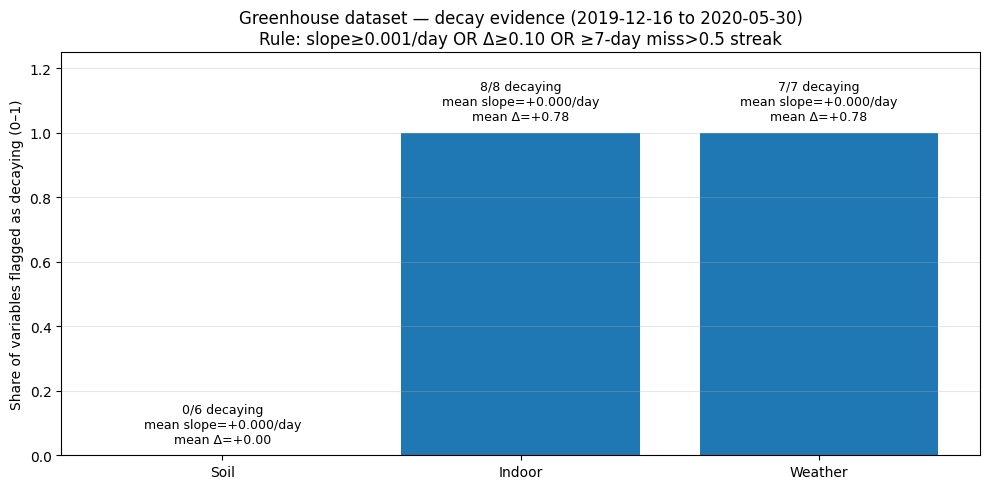

In [37]:
def plot_decay_proof_from_summaries(soil_decay, ind_decay, weath_decay,
                                    title='Greenhouse dataset — decay evidence'):
    items = [
        ('Soil',   soil_decay),
        ('Indoor', ind_decay),
        ('Weather',weath_decay),
    ]

    names, shares, counts, nvars, mean_slope, mean_delta = [], [], [], [], [], []

    for name, df in items:
        if df is None or len(df) == 0:
            continue
        k = int(df['decay_flag'].sum())
        n = int(len(df))
        names.append(name)
        shares.append((k / n) if n > 0 else 0.0)
        counts.append(k)
        nvars.append(n)
        mean_slope.append(float(np.nanmean(df['slope_per_day'])))
        mean_delta.append(float(np.nanmean(df['delta_period'])))

    x = np.arange(len(names))
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(x, shares)  # default colors per Matplotlib policy

    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylabel('Share of variables flagged as decaying (0–1)')
    ax.set_title(title + '\nRule: slope≥0.001/day OR Δ≥0.10 OR ≥7-day miss>0.5 streak')
    # give space for annotations above bars
    ymax = max(shares) if shares else 1.0
    ax.set_ylim(0, max(1.0, ymax + 0.25))
    ax.grid(axis='y', alpha=0.3)

    # annotate each bar
    for b, k, n, s, d in zip(bars, counts, nvars, mean_slope, mean_delta):
        ax.text(b.get_x() + b.get_width() / 2.0,
                b.get_height() + 0.03,
                f'{k}/{n} decaying\nmean slope={s:+.3f}/day\nmean Δ={d:+.2f}',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# usage (after running your decay_summary on each stream)
plot_decay_proof_from_summaries(soil_decay, ind_decay, weath_decay,
    title='Greenhouse dataset — decay evidence (2019-12-16 to 2020-05-30)')

# Model

In [29]:
import torch, os, sys, contextlib, torch, math, time
import torch.nn as nn
import torch.nn.functional as F

In [30]:
class LearnableTimeScale(nn.Module):
    """
    Positive, trainable time scale τ (in seconds), clamped to [min_seconds, max_seconds].
    forward() -> τ tensor (scalar on the current device/dtype).
    """
    def __init__(self, init_seconds=3600.0, trainable=True,
                 min_seconds=60.0, max_seconds=7*24*3600.0):
        super().__init__()
        init_seconds = float(init_seconds)
        self.log_ts = nn.Parameter(
            torch.tensor(math.log(init_seconds), dtype=torch.float32),
            requires_grad=bool(trainable)
        )
        self.min_seconds = float(min_seconds)
        self.max_seconds = float(max_seconds)

    def forward(self) -> torch.Tensor:
        ts = torch.exp(self.log_ts)
        return torch.clamp(ts, self.min_seconds, self.max_seconds)

    @torch.no_grad()
    def set_seconds(self, seconds: float):
        seconds = float(max(self.min_seconds, min(self.max_seconds, seconds)))
        self.log_ts.copy_(torch.tensor(math.log(seconds), dtype=torch.float32))

    def seconds(self) -> float:
        return float(torch.exp(self.log_ts).item())

In [31]:
class TimeConst(nn.Module):
    """
    Time constant τ = softplus(log_ts) + τ_min, then clamped to [τ_min, τ_max].
    This is convenient if you want a strictly-positive parameter with a hard floor.
    """
    def __init__(self, init_tau: float = 3.0, tau_min: float = 1e-3, tau_max: float = 1e3):
        super().__init__()
        init_tau = float(init_tau)
        self.log_ts = nn.Parameter(torch.tensor(math.log(init_tau), dtype=torch.float32))
        self.tau_min = float(tau_min)
        self.tau_max = float(tau_max)

    def forward(self) -> torch.Tensor:
        tau = F.softplus(self.log_ts) + self.tau_min
        return tau.clamp(self.tau_min, self.tau_max)

In [32]:
class ConfScorer(nn.Module):
    """
    Confidence scorer (backward compatible)

    • Same forward contract as your original:
        forward(x, mask) -> conf in [min_conf, 1], shape [B,T,1] or [B,1]
        - preserves coverage-aware floor
        - optional EMA smoothing over time

    • NEW (optional) self-supervised calibration:
        ssl_loss(x, mask, xhat, conf_pred=None, q=0.10, scale=1.0, reduction="mean")
      - randomly hides a small fraction (q) of truly observed entries
      - computes reconstruction error from xhat on those entries
      - builds a soft confidence target: conf_tgt = exp(-mean_abs_error)
      - trains conf to match conf_tgt only at the sampled steps

      Use with a tiny weight, e.g.: loss += 0.05 * scorer.ssl_loss(...)
    """
    def __init__(self,
                 dim: int,
                 hidden: int = 64,
                 min_conf: float = 1e-3,
                 conf_from: str = "x+mask",     # {"x","mask","x+mask"}
                 smooth_ema: float | None = None,
                 dropout: float = 0.0,
                 use_layernorm: bool = False):
        super().__init__()
        assert conf_from in ("x", "mask", "x+mask")
        self.dim = int(dim)
        self.min_conf = float(min_conf)
        self.conf_from = conf_from
        self.smooth_ema = float(smooth_ema) if smooth_ema is not None else None

        net_in = self.dim if conf_from in ("x", "mask") else 2 * self.dim
        layers = [nn.Linear(net_in, hidden), nn.SiLU()]
        if use_layernorm:
            layers.append(nn.LayerNorm(hidden))
        if dropout and dropout > 0:
            layers.append(nn.Dropout(float(dropout)))
        layers.append(nn.Linear(hidden, 1))  # per-step logit
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        x    : [B,T,D] or [B,D]
        mask : [B,T,D] or [B,D] or [B,T] / [B,T,1]
        returns conf : [B,T,1] or [B,1]
        """
        squeeze_back = False

        # Coerce to [B,T,D] for scoring
        if x.dim() == 2:   # [B,D] -> [B,1,D]
            x = x.unsqueeze(1)
            squeeze_back = True
        B, T, D = x.shape

        # Broadcast mask to [B,T,D]
        if mask.dim() == 2:           # [B,D] -> [B,1,D] -> [B,T,D] (T=1)
            mask = mask.unsqueeze(1).expand(B, T, D)
        elif mask.dim() == 3 and mask.size(-1) == 1:
            mask = mask.expand(B, T, D)
        elif mask.dim() == 3 and mask.size(-1) == D:
            pass
        else:
            raise ValueError(f"mask must be [B,T,D], [B,T,1], or [B,D]; got {tuple(mask.shape)}")

        # Sanitize
        x_s = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        m   = torch.nan_to_num(mask, nan=0.0).clamp(0.0, 1.0)
        miss= (1.0 - m)

        # Features for the scorer (does NOT modify x elsewhere)
        if self.conf_from == "x":
            feat = x_s
        elif self.conf_from == "mask":
            feat = miss
        else:
            feat = torch.cat([x_s, miss], dim=-1)  # "x+mask"

        # Per-step logits -> sigmoid -> scale to [min_conf, 1]
        conf = torch.sigmoid(self.net(feat))                   # [B,T,1]
        conf = conf * (1.0 - self.min_conf) + self.min_conf

        # Coverage-aware floor: if any feature observed at that step,
        # ensure conf >= mean coverage at that step.
        coverage = m.mean(dim=-1, keepdim=True)                # [B,T,1]
        step_obs = (m.sum(dim=-1, keepdim=True) > 0)           # [B,T,1] boolean
        conf = torch.where(step_obs, torch.maximum(conf, coverage), conf)

        # Optional EMA smoothing over time
        if self.smooth_ema is not None and T > 1:
            lam = self.smooth_ema
            c_out = [conf[:, 0:1, :]]
            c_prev = c_out[0]
            for t in range(1, T):
                c_prev = lam * c_prev + (1.0 - lam) * conf[:, t:t+1, :]
                c_out.append(c_prev)
            conf = torch.cat(c_out, dim=1)

        if squeeze_back:
            return conf.squeeze(1)  # [B,1]
        return conf                 # [B,T,1]

    @staticmethod
    def _ensure_seq(x: torch.Tensor) -> tuple[torch.Tensor, bool]:
        """Make x shape [B,T,D]; return (x_seq, squeezed)."""
        squeezed = False
        if x.dim() == 2:
            x = x.unsqueeze(1)
            squeezed = True
        return x, squeezed

    @torch.no_grad()
    def _build_ssl_targets(self,
                           x: torch.Tensor,      # [B,T,D]
                           mask: torch.Tensor,   # [B,T,D]
                           xhat: torch.Tensor,   # [B,T,D]
                           q: float,
                           scale: float) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
          conf_tgt : [B,T,1]  soft target in (0,1]
          step_msk : [B,T,1]  where to apply the loss (at least one sampled obs in step)
        """
        B, T, D = x.shape
        obs = (mask > 0.5)

        # sample a small extra mask only on observed entries
        extra = (torch.rand(B, T, D, device=x.device) < q)
        tgt_mask = obs & extra

        # step-wise mean absolute error on sampled entries
        err = (x - xhat).abs()
        err = err / (float(scale) + 1e-6)

        cnt_raw  = tgt_mask.sum(dim=-1, keepdim=True)            # [B,T,1]
        cnt_safe = cnt_raw.clamp_min(1.0)                        # for division only
        step_err = (err * tgt_mask).sum(dim=-1, keepdim=True) / cnt_safe
        conf_tgt = torch.exp(-step_err).clamp(1e-6, 1.0)
        step_msk = (cnt_raw > 0).to(conf_tgt.dtype)              # real “where-to-apply”
        return conf_tgt, step_msk

    def ssl_loss(self,
                 x: torch.Tensor,          # [B,T,D] or [B,D]
                 mask: torch.Tensor,       # [B,T,D] or [B,D] / [B,T] / [B,T,1]
                 xhat: torch.Tensor,       # [B,T,D] or [B,D]  (from DecayAware)
                 conf_pred: torch.Tensor | None = None,  # [B,T,1] or [B,1] (optional, to avoid recompute)
                 *,
                 q: float = 0.10,
                 scale: float = 1.0,
                 reduction: str = "mean") -> torch.Tensor:
        """
        Self-supervised calibration loss for confidence.
        Use a *small* q (e.g., 0.05–0.15) and a small loss weight (e.g., 0.02–0.10).

        Typical usage after DecayAware:
            xhat_seq, conf_seq = da.forward(x, mask, delta)
            loss += 0.05 * scorer.ssl_loss(x, mask, xhat_seq, conf_pred=conf_seq, q=0.10)

        Returns a scalar loss (if reduction == "mean") or a [B,T,1] tensor (if "none").
        """
        x, _ = self._ensure_seq(x)
        xhat, _ = self._ensure_seq(xhat)

        # broadcast mask to [B,T,D]
        if mask.dim() == 2:       # [B,D] -> [B,1,D] -> [B,T,D]
            mask = mask.unsqueeze(1).expand_as(x)
        elif mask.dim() == 3 and mask.size(-1) == 1:
            mask = mask.expand_as(x)
        elif mask.dim() == 3 and mask.size(-1) == x.size(-1):
            pass
        else:
            raise ValueError(f"mask must be [B,T,D], [B,T,1], or [B,D]; got {tuple(mask.shape)}")

        # targets and where-to-apply mask
        conf_tgt, step_msk = self._build_ssl_targets(x, mask, xhat, q=float(q), scale=float(scale))  # [B,T,1] each

        # predicted conf (reuse if provided)
        if conf_pred is None:
            conf_pred = self.forward(x, mask)  # [B,T,1]
        else:
            if conf_pred.dim() == 2:   # [B,1] -> [B,1,1] -> [B,T,1]
                conf_pred = conf_pred.unsqueeze(1).expand(conf_tgt.size(0), conf_tgt.size(1), 1)
            elif conf_pred.dim() == 3 and conf_pred.size(1) == 1 and conf_tgt.size(1) > 1:
                conf_pred = conf_pred.expand(conf_tgt.size(0), conf_tgt.size(1), 1)

        # MSE only where we sampled targets
        se = (conf_pred - conf_tgt).pow(2) * step_msk
        if reduction == "none":
            return se
        denom = step_msk.sum().clamp_min(1.0)
        return se.sum() / denom

In [33]:
class TimeGapDecay(nn.Module):
    """
    gamma = exp(-softplus(W * d + b)) ∈ (0,1], strictly decreasing w.r.t. nonnegative delta d.
    - Accepts d shaped [..., in_dim] (often in_dim=1 for a scalar Δ).
    - Maps to [..., out_dim], e.g. D features or H hidden units.

    Why:
      • softplus ensures positive rate → γ decreases as Δ grows (monotone)
      • clamping keeps numerics stable on long gaps (decay data) and prevents under/overflow
    """
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.lin = nn.Linear(in_dim, out_dim)
        # Reasonable starting point: mild decay (~0.95)
        nn.init.constant_(self.lin.bias, -3.0)          # softplus(-3) ~ 0.048 → exp(-0.048) ≈ 0.953
        nn.init.uniform_(self.lin.weight, 0.0, 0.05)    # small → softplus(weight) ≈ small positive

    def forward(self, delta_norm: torch.Tensor) -> torch.Tensor:
        # Sanitize: no NaN/Inf, non-negative, clamp large to keep exp() safe
        d = torch.nan_to_num(delta_norm, nan=0.0, posinf=1e3, neginf=0.0)
        d = d.clamp_min(0.0).clamp_max(1e3)

        # Non-negative effective weights via softplus; bias free to move
        W_pos = F.softplus(self.lin.weight)             # [out_dim, in_dim] ≥ 0
        b = self.lin.bias
        y = F.linear(d, W_pos, b)                       # [..., out_dim]

        # γ = exp( -softplus(y) ), then clamp for stability
        rate = F.softplus(y).clamp_min(0.0).clamp_max(30.0)   # prevent overflow in exp
        gamma = torch.exp(-rate).clamp_min(1e-6)              # (0,1]; floor to keep grads alive
        return gamma

In [34]:
class MultiTimeScale(nn.Module):
    def __init__(self, init_seconds=3600.0, l2_pull=1e-3):
        super().__init__()
        self.shared = LearnableTimeScale(init_seconds, trainable=True)
        self.soil   = LearnableTimeScale(init_seconds, trainable=True)
        self.indoor = LearnableTimeScale(init_seconds, trainable=True)
        self.weath  = LearnableTimeScale(init_seconds, trainable=True)
        self.tab    = LearnableTimeScale(init_seconds, trainable=True)
        self.l2_pull = float(l2_pull)
    def penalty(self):
        s = self.shared()
        return self.l2_pull * sum((m() - s).pow(2).mean()
                                  for m in [self.soil, self.indoor, self.weath, self.tab])

In [35]:
class DecayAware(nn.Module):
    """
    Missingness-only module:
      • Produces finite, mask-faithful tokens (xhat_seq)
      • Emits per-step imputation confidence (conf_seq)
      • Uses gap-aware drift toward a per-sequence fallback mean
    No sequence embedding, no hidden state, no pooling.

    Inputs:  x [B,T,D], x_mask [B,T] / [B,T,1] / [B,T,D], x_delta [B,T] / [B,T,1] / [B,T,D]
             x_mean [B,1,D] optional (fallback mean); if None, estimated from first k steps
    Returns: xhat_seq [B,T,D], conf_seq [B,T,1]
    """
    def __init__(
        self,
        input_size: int,
        *,
        device: str = "cpu",
        time_scale: float = 3600.0,
        time_scale_module: LearnableTimeScale | None = None,
        noise_scale: float = 0.0,
        conf_min: float = 1e-3,
        use_two_timescales: bool = True
    ):
        super().__init__()
        self.input_size = int(input_size)
        self.device = device
        self.noise_scale = float(noise_scale)
        self.use_two_timescales = bool(use_two_timescales)

        # Δ normalization (shared τ)
        self.ts_mod = time_scale_module if time_scale_module is not None else LearnableTimeScale(time_scale)

        # Confidence scorer (no token modification)
        self.conf_scorer = ConfScorer(dim=self.input_size, hidden=64, min_conf=conf_min, conf_from="x+mask", smooth_ema=None)

        # Gap→decay (scalar Δ per step → per-feature decay)
        # We map [B,T,1] → [B,T,D]
        self.decay_fast = TimeGapDecay(in_dim=1, out_dim=self.input_size)
        self.decay_slow = TimeGapDecay(in_dim=1, out_dim=self.input_size) if self.use_two_timescales else None
        self.mix_gate_raw = nn.Parameter(torch.tensor(0.0))  # blend fast/slow; sigmoid→(0..1)

        # Optional: cached global mean (if you want to seed x_mean externally)
        self.register_buffer("x_global_mean", torch.zeros(1, 1, self.input_size))

        # Tiny input projection for internal stability (does NOT leak as representation)
        # Kept identity by default; comment out entirely if you prefer absolutely no projection.
        self.input_embed = nn.Identity()

        self._last_conf = None  # [B,1]

    @torch.no_grad()
    def set_global_mean(self, mean_vec: torch.Tensor):
        self.x_global_mean = mean_vec.view(1, 1, -1)

    def _norm_delta_scalar(self, d: torch.Tensor) -> torch.Tensor:
        """
        Normalize Δ to d̄ = log1p(Δ_seconds / τ); returns [B,T,1].
        Accepts [B,T], [B,T,1], or [B,T,D] and reduces to a scalar per step.
        """
        if d.dim() == 3 and d.size(-1) > 1:
            d = d.mean(dim=-1, keepdim=True)     # [B,T,1]
        elif d.dim() == 3 and d.size(-1) == 1:
            pass                                  # [B,T,1]
        elif d.dim() == 2:
            d = d.unsqueeze(-1)                   # [B,T,1]
        else:
            raise ValueError(f"x_delta must be [B,T], [B,T,1], or [B,T,D]; got {tuple(d.shape)}")

        d = torch.nan_to_num(d, nan=0.0, posinf=0.0, neginf=0.0).clamp_min(0.0)
        tau = self.ts_mod().to(d.device).clamp_min(1e-6)
        d_seconds = d * 300.0  # 5-min steps → seconds
        return torch.log1p(d_seconds / tau)       # [B,T,1]

    def _blend_decay(self, dbar: torch.Tensor) -> torch.Tensor:
        """
        dbar: [B,T,1] → gamma_x: [B,T,D]
        """
        g_fast = self.decay_fast(dbar)
        if self.decay_slow is None:
            return g_fast
        g_slow = self.decay_slow(dbar)
        s = torch.sigmoid(self.mix_gate_raw).view(1, 1, 1)
        return s * g_fast + (1.0 - s) * g_slow

    def forward(self, x: torch.Tensor, x_mask: torch.Tensor, x_delta: torch.Tensor, x_mean: torch.Tensor | None = None):
        B, T, D = x.shape
        assert D == self.input_size, f"input_size mismatch: expected {self.input_size}, got {D}"

        # --- Broadcast/clean mask to [B,T,D] ---
        if x_mask.dim() == 2:                       # [B,T]
            x_mask = x_mask.unsqueeze(-1).expand(B, T, D)
        elif x_mask.dim() == 3 and x_mask.size(-1) == 1:  # [B,T,1]
            x_mask = x_mask.expand(B, T, D)
        m_full = torch.nan_to_num(x_mask, nan=0.0).clamp(0.0, 1.0)

        # --- Δ → normalized scalar per step ---
        dbar = self._norm_delta_scalar(x_delta)     # [B,T,1]
        gamma_x = self._blend_decay(dbar)           # [B,T,D]

        # --- Fallback mean ---
        if x_mean is None:
            k = min(6, T)
            x0 = torch.nan_to_num(x[:, :k, :], nan=0.0)
            m0 = m_full[:, :k, :]
            num = (x0 * m0).sum(dim=1)
            den = m0.sum(dim=1).clamp_min(1.0)
            x_mean = (num / den).unsqueeze(1)       # [B,1,D]

        # --- Iterate and impute (mask-faithful) ---
        x_finite = torch.where(torch.isfinite(x), x, torch.zeros_like(x))
        x_last = x_mean.squeeze(1).clone()          # start from mean

        XH, CONF = [], []
        last_conf = None

        for t in range(T):
            m_t = m_full[:, t, :]                   # [B,D]
            x_obs_t = torch.where(m_t > 0, x_finite[:, t, :], torch.zeros_like(x_finite[:, t, :]))

            # conservative imputation toward per-seq mean, gap-weighted
            x_fallback = gamma_x[:, t, :] * x_last + (1.0 - gamma_x[:, t, :]) * x_mean.squeeze(1)
            x_hat = m_t * x_obs_t + (1.0 - m_t) * x_fallback  # observed untouched

            # optional regularization noise ONLY on imputed entries
            if self.training and self.noise_scale > 0.0:
                noise = torch.randn_like(x_hat) * self.noise_scale
                x_hat = x_hat + (1.0 - m_t) * noise

            # per-step imputation confidence (no token injection)
            conf_t = self.conf_scorer(x_hat, m_t)   # [B,1]
            last_conf = conf_t

            # update "last observed" tracker only where we had observations
            x_last = torch.where(m_t.bool(), x_obs_t, x_last)

            # collect
            XH.append(self.input_embed(x_hat).unsqueeze(1))  # keep identity; safe hook
            CONF.append(conf_t.unsqueeze(1))

        xhat_seq = torch.cat(XH, dim=1)             # [B,T,D]
        conf_seq = self.conf_scorer(xhat_seq, m_full)           # [B,T,1]
        self._last_conf = conf_seq[:, -1, :]                 # [B,1]
        return xhat_seq, conf_seq

In [36]:
class TimeEmbeddingGRUEncoder(nn.Module):
    """
    Δ-aware GRU encoder (representation only):
      • Uses LearnableTimeScale τ to normalize deltas
      • Ages hidden state via TimeGapDecay (gap→forgetting)
      • Reuses DecayAware's conf_seq to weight writes (preferred)
      • Optional internal ConfScorer only if enabled

    Inputs
      x     : [B,T,D]   (finite tokens from DecayAware)
      mask  : [B,T,D] or None (1=observed, 0=missing). If None, inferred from x.
      delta : [B,T,D] or [B,T]  (5-min steps since previous sample)
      conf_override : [B,T,1] or [B,T] or None (from DecayAware.conf_seq). If None, see use_internal_conf.

    Returns
      y : [B, output_dim] if output_dim set, else [B, hidden_dim]
      H : [B,T,hidden_dim]
    """
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 output_dim: int | None = None,
                 time_scale: float = 3600.0,
                 time_scale_module: LearnableTimeScale | None = None,
                 include_delta: bool = True,
                 time_embed_dim: int = 8,
                 pool_mode: str = "decay",   # {"decay","last","mean"}
                 dropout: float = 0.10,
                 use_internal_conf: bool = False,   # <- default OFF; prefer DA confidence
                 conf_min: float = 1e-3):
        super().__init__()
        self.input_dim = int(input_dim)
        self.hidden_dim = int(hidden_dim)
        self.include_delta = bool(include_delta)
        self.time_embed_dim = int(time_embed_dim)
        self.pool_mode = str(pool_mode)
        self.use_internal_conf = bool(use_internal_conf)

        # Optional internal scorer (only if you really want a fallback)
        self.conf_scorer = None
        if self.use_internal_conf:
            self.conf_scorer = ConfScorer(
                dim=self.input_dim, hidden=64, min_conf=conf_min, conf_from="x+mask", smooth_ema=None
            )
        self._last_conf = None  # [B,1]

        # Δ normalization + temporal parts
        self.ts_mod = time_scale_module if time_scale_module is not None else LearnableTimeScale(time_scale)
        self.time_embed = nn.Linear(1, self.time_embed_dim)   # small time-position embedding
        self.h_decay    = TimeGapDecay(1, hidden_dim)         # hidden decay from scalar Δ

        # GRU over augmented input (x ⊕ time_emb ⊕ [Δ]? as scalar)
        gru_in = self.input_dim + (1 if self.include_delta else 0) + self.time_embed_dim
        self.gru = nn.GRUCell(gru_in, hidden_dim)

        self.dropout = nn.Dropout(dropout) if (dropout and output_dim is not None) else nn.Identity()
        self.out = nn.Identity() if output_dim is None else nn.Sequential(
            nn.LayerNorm(hidden_dim),
            self.dropout,
            nn.Linear(hidden_dim, output_dim)
        )

    def _norm_delta_scalar(self, delta: torch.Tensor) -> torch.Tensor:
        """
        Normalize Δ to d̄ = log1p(Δ_seconds / τ). Accepts [B,T,D] or [B,T]; returns [B,T,1].
        """
        if delta is None:
            raise ValueError("TimeEmbeddingGRUEncoder requires `delta`.")
        if delta.dim() == 3:
            d = delta.mean(dim=-1, keepdim=True)    # [B,T,1]
        elif delta.dim() == 2:
            d = delta.unsqueeze(-1)                  # [B,T,1]
        else:
            raise ValueError(f"delta must be [B,T] or [B,T,D], got {tuple(delta.shape)}")
        d = torch.nan_to_num(d, nan=0.0, posinf=0.0, neginf=0.0).clamp_min(0.0)
        tau = self.ts_mod().to(d.device).clamp_min(1e-6)
        d_seconds = d * 300.0  # 5-min steps → seconds
        return torch.log1p(d_seconds / tau)         # [B,T,1]

    def _pool(self, H: torch.Tensor) -> torch.Tensor:
        if self.pool_mode == "last":
            return H[:, -1, :]
        if self.pool_mode == "mean":
            return H.mean(dim=1)
        # decay-weighted pooling (default)
        B, T, Hdim = H.shape
        ages = torch.arange(T-1, -1, -1, device=H.device, dtype=H.dtype).view(1, T, 1)
        w = torch.exp(-0.05 * ages)
        w = w / (w.sum(dim=1, keepdim=True) + 1e-8)
        return (H * w).sum(dim=1)

    @staticmethod
    def _coerce_conf(conf: torch.Tensor | None, B: int, T: int, device, dtype) -> torch.Tensor:
        """
        Accept [B,T,1] or [B,T] or None → return [B,T,1]; if None, return ones.
        """
        if conf is None:
            return torch.ones(B, T, 1, device=device, dtype=dtype)
        if conf.dim() == 2:
            conf = conf.unsqueeze(-1)           # [B,T,1]
        elif conf.dim() == 3 and conf.size(-1) == 1:
            pass
        else:
            raise ValueError(f"conf_override must be [B,T] or [B,T,1], got {tuple(conf.shape)}")
        return torch.nan_to_num(conf, nan=0.0, posinf=1.0, neginf=0.0).clamp(0.0, 1.0)

    def forward(self,
                x: torch.Tensor,
                mask: torch.Tensor | None,
                delta: torch.Tensor,
                conf_override: torch.Tensor | None = None) -> tuple[torch.Tensor, torch.Tensor]:
        B, T, Dx = x.shape
        # finite for computation (DA already handled tokens; this is a safety net)
        x_f = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        if mask is None:
            mask = torch.isfinite(x).to(x.dtype)
        else:
            mask = torch.nan_to_num(mask, nan=0.0).clamp(0.0, 1.0)

        # Δ normalization → time embedding + hidden decay
        dbar = self._norm_delta_scalar(delta)       # [B,T,1]
        temb = torch.tanh(self.time_embed(dbar))    # [B,T,E]

        # choose confidence source
        if conf_override is not None:
            conf_all = self._coerce_conf(conf_override, B, T, x.device, x_f.dtype)  # [B,T,1]
            use_internal = False
        else:
            use_internal = self.use_internal_conf and (self.conf_scorer is not None)
            # placeholder; will fill per step if use_internal, else ones
            conf_all = torch.ones(B, T, 1, device=x.device, dtype=x_f.dtype)

        h = x_f.new_zeros(B, self.hidden_dim)
        H = []
        last_conf = None

        for t in range(T):
            # state aging by current Δ
            g_h = self.h_decay(dbar[:, t])          # [B,H]
            h = h * g_h

            x_t = x_f[:, t, :]
            m_t = mask[:, t, :]

            # per-step confidence
            if use_internal:
                conf_step = self.conf_scorer(x_t, m_t)    # [B,1]
                conf_all[:, t, :] = conf_step
            else:
                conf_step = conf_all[:, t, :]             # [B,1]
            last_conf = conf_step

            # GRU input
            if self.include_delta:
                inp = torch.cat([x_t, temb[:, t], dbar[:, t]], dim=-1)
            else:
                inp = torch.cat([x_t, temb[:, t]], dim=-1)

            h_new = self.gru(inp, h)

            # confidence-weighted write
            c = conf_step
            while c.dim() < h_new.dim():
                c = c.unsqueeze(-1)
            h = c * h_new + (1.0 - c) * h

            H.append(h.unsqueeze(1))

        H = torch.cat(H, dim=1)                     # [B,T,H]
        self._last_conf = last_conf                 # [B,1]
        y = self.out(self._pool(H))                 # [B,output] or [B,H]
        return y, H

In [37]:
class TabularEncoder(nn.Module):
    """
    Per-sample tabular encoder (representation only).
    Reuses DecayAware confidence when given; optional internal ConfScorer as fallback.

    Inputs:
      x             : [B,D] (finite tokens from DecayAware; e.g., T=1 → squeeze)
      mask          : [B,D] or None (1=observed, 0=missing) — used only if internal scorer is enabled
      conf_override : [B,1] or [B] or None (preferred; from DecayAware.conf_seq.squeeze(1))

    Returns:
      z : [B, output_dim]
    """
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 output_dim: int,
                 use_mask: bool = False,
                 # confidence handling
                 use_internal_conf: bool = False,   # <- default OFF; prefer DA confidence
                 conf_from: str = "x+mask",
                 min_conf: float = 1e-3,
                 dropout: float = 0.20):
        super().__init__()
        self.use_mask = bool(use_mask)
        self.input_dim = int(input_dim)
        self.use_internal_conf = bool(use_internal_conf)

        # Optional internal scorer (only if you enable it)
        self.conf_scorer = None
        if self.use_internal_conf:
            self.conf_scorer = ConfScorer(
                dim=self.input_dim, hidden=64, min_conf=min_conf, conf_from=conf_from, smooth_ema=None
            )

        in_dim = self.input_dim * (2 if self.use_mask else 1)
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )

        self._last_conf = None  # [B,1]

    @staticmethod
    def _coerce_conf(conf: torch.Tensor | None, B: int, device, dtype) -> torch.Tensor:
        """
        Accept [B,1] or [B] or None → return [B,1]; if None, return ones.
        """
        if conf is None:
            return torch.ones(B, 1, device=device, dtype=dtype)
        if conf.dim() == 1:
            conf = conf.unsqueeze(-1)              # [B,1]
        elif conf.dim() == 2 and conf.size(-1) == 1:
            pass
        else:
            raise ValueError(f"conf_override must be [B] or [B,1], got {tuple(conf.shape)}")
        return torch.nan_to_num(conf, nan=0.0, posinf=1.0, neginf=0.0).clamp(0.0, 1.0)

    def forward(self,
                x: torch.Tensor,
                mask: torch.Tensor | None = None,
                conf_override: torch.Tensor | None = None) -> torch.Tensor:
        # tiny safety (should already be finite from DA)
        x_carrier = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        B, D = x_carrier.shape

        # choose confidence source
        if conf_override is not None:
            conf = self._coerce_conf(conf_override, B, x_carrier.device, x_carrier.dtype)  # [B,1]
        elif self.use_internal_conf and (self.conf_scorer is not None):
            if mask is None:
                mask = torch.isfinite(x_carrier).to(x_carrier.dtype)
            else:
                mask = torch.nan_to_num(mask, nan=0.0).clamp(0.0, 1.0)
            conf = self.conf_scorer(x_carrier, mask)  # [B,1]
        else:
            conf = torch.ones(B, 1, device=x_carrier.device, dtype=x_carrier.dtype)  # neutral

        self._last_conf = conf  # stored for downstream routing if needed

        x_in = torch.cat([x_carrier, mask], dim=-1) if (self.use_mask and mask is not None) else x_carrier
        return self.net(x_in)

In [38]:
class AnchorCreator(nn.Module):
    """
    Input anchor (required): [ y_today, y_prev1, y_prev7, y_diff1, y_diff7 ]  → [B,5]

    Creates a leak-safe y-only baseline using 4 candidates (shape preserved):
      candidates = [y_fast(y_t, y_p1), ema3, ema7, y_p7]
      where y_fast blends y_t into y_p1 with a shock-aware, time-constant-controlled weight.

    Returns (contracts kept stable for downstream):
      baseline : [B,1]
      feat     : [B,10] = [baseline, y_p1, y_p7, ema3, ema7, d1, d7, y_t, 0, ratio_1_7]
      mix      : [B,4]  over [y_fast, ema3, ema7, y_p7]
      conf_vec : [B,4]  = ones (neutral)
      conf_glob: [B,1]  = ones
      shock    : [B,1]  in [-1,1] (diagnostic only)
      summary  : [B,20] = feat(10) ⊕ mix(4) ⊕ shock(1) ⊕ conf_vec(4) ⊕ conf_glob(1)
      debug    : dict
    """
    def __init__(
        self,
        *,
        shock_gain: float = 1.0,
        temperature: float = 1.0,
        tau_init: float = 3.0,
        tau_min: float = 1e-3,
        tau_max: float = 1e3,
    ):
        super().__init__()
        self.shock_gain = float(shock_gain)

        # Prior from [1, shock] → 4 logits (small nudge only)
        self.logit_affine = nn.Linear(2, 4, bias=True)

        # Simple shock detector using only y-anchored deltas (includes y_t surprise)
        self.shock_mlp = nn.Sequential(
            nn.Linear(4, 8), nn.ReLU(inplace=True), nn.Linear(8, 1)
        )

        # Softmax temperature (>=0.5 for stability)
        self._temp = nn.Parameter(torch.tensor([max(1e-3, float(temperature))]))

        # Time constant (you already have TimeConst in your codebase)
        self.tau_param = TimeConst(init_tau=float(tau_init),
                                   tau_min=float(tau_min),
                                   tau_max=float(tau_max))

    @staticmethod
    def _split(anchor: torch.Tensor):
        assert anchor.dim() == 2 and anchor.size(1) == 5, f"expected [B,5]=[y_t,p1,p7,d1,d7], got {tuple(anchor.shape)}"
        y_t  = anchor[:, 0:1]
        y_p1 = anchor[:, 1:2]
        y_p7 = anchor[:, 2:3]
        d1   = anchor[:, 3:4]
        d7   = anchor[:, 4:5]
        return y_t, y_p1, y_p7, d1, d7

    @staticmethod
    def _safe_ratio(a: torch.Tensor, b: torch.Tensor, eps: float = 1e-6):
        a0 = torch.nan_to_num(a, nan=0.0)
        b0 = torch.nan_to_num(b, nan=0.0)
        ok = torch.isfinite(a) & torch.isfinite(b) & (b0.abs() > eps)
        return torch.where(ok, a0 / (b0 + eps), torch.ones_like(a0))

    def forward(self, anchor: torch.Tensor):
        B = anchor.size(0)
        device, dtype = anchor.device, anchor.dtype

        y_t, y_p1, y_p7, d1, d7 = self._split(anchor)

        # Causal EMA proxies (prev/diff only; no peek ahead)
        ema3 = y_p1 + (1.0/3.0) * torch.nan_to_num(d1, nan=0.0)
        ema7 = y_p7 + (1.0/7.0) * torch.nan_to_num(d7, nan=0.0)

        # Availability masks
        m_p1 = torch.isfinite(y_p1).float()
        m_p7 = torch.isfinite(y_p7).float()
        m_e3 = m_p1.clone()
        m_e7 = m_p7.clone()

        ratio = self._safe_ratio(y_p1, y_p7)
        ratio = torch.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

        # Shock (diagnostics only) — leverage |d1|,|d7|,|1-ratio|, and today's surprise vs p1
        shock_in = torch.cat([
            torch.abs(torch.nan_to_num(d1, nan=0.0)),
            torch.abs(torch.nan_to_num(d7, nan=0.0)),
            torch.abs(1.0 - ratio),
            torch.abs(torch.nan_to_num(y_t - y_p1, nan=0.0)),
        ], dim=1)
        shock = torch.tanh(self.shock_gain * self.shock_mlp(shock_in))  # [-1,1]

        # TimeConst prior: tau → alpha reactivity
        tau   = self.tau_param().to(dtype=dtype, device=device).clamp_min(1e-6)
        alpha = (1.0 / (1.0 + tau)).clamp(0.0, 1.0)  # tau≈0 → fast, tau→∞ → slow

        # Shock-aware weight for y_t inside the fast candidate
        gamma_t = (alpha * (1.0 - shock.abs())).clamp(0.0, 1.0)  # [B,1]

        # Fast candidate: blend of p1 and today
        y_fast = (1.0 - gamma_t) * y_p1 + gamma_t * y_t

        # 4 candidates (shape preserved)
        cand  = torch.cat([y_fast, ema3, ema7, y_p7], dim=1)  # [B,4]

        # Availability: y_fast needs p1 & y_t → use p1's mask (y_t is required anyway)
        m_fast = m_p1
        cmask  = torch.cat([m_fast, m_e3, m_e7, m_p7], dim=1)  # [B,4]

        # Prior over 4 candidates (time-bias + small shock bias)
        time_bias = torch.tensor([+1.25, +0.25, -0.25, -1.0], device=device, dtype=dtype) * (2.0*alpha - 1.0)
        time_bias = time_bias.view(1, 4).expand(B, -1)

        bias_from_shock = self.logit_affine(torch.cat([torch.ones_like(shock), shock], dim=1))  # [B,4]
        logits = bias_from_shock + time_bias
        logits = logits + (cmask - 1.0) * 1e6  # mask-out unavailable

        temp = F.softplus(self._temp) + 0.5
        mix = F.softmax(logits / temp, dim=1)  # [B,4]
        mix = (mix * cmask)
        mix = mix / mix.sum(dim=1, keepdim=True).clamp_min(1e-8)

        baseline = (mix * torch.nan_to_num(cand, nan=0.0)).sum(dim=1, keepdim=True)  # [B,1]

        zeros = torch.zeros(B, 1, device=device, dtype=dtype)
        feat = torch.cat([
            baseline, y_p1, y_p7, ema3, ema7,
            torch.nan_to_num(d1, nan=0.0),
            torch.nan_to_num(d7, nan=0.0),
            y_t, zeros,                    # <— y_t sits at feat[7]
            ratio
        ], dim=1)

        # Neutral confidences (kept only for 20-D contract; VA/RA ignore them)
        conf_vec  = torch.ones(B, 4, device=device, dtype=dtype)
        conf_glob = torch.ones(B, 1, device=device, dtype=dtype)

        summary = torch.cat([feat, mix, shock, conf_vec, conf_glob], dim=1)
        feat    = torch.nan_to_num(feat,    nan=0.0, posinf=0.0, neginf=0.0)
        summary = torch.nan_to_num(summary, nan=0.0, posinf=0.0, neginf=0.0)

        debug = {"mix": mix, "logits": logits, "shock": shock, "tau": tau.detach(), "anchor_raw": anchor}
        return baseline, feat, mix, conf_vec, conf_glob, shock, summary, debug

In [39]:
class VolatilityAnalyzer(nn.Module):
    """
    Uses only y-anchored inputs to judge reliability (no external confidences).
    Input anchor (required): [ y_t, y_p1, y_p7, d1, d7 ]  → [B,5]
    Optional summary: [B,20] — used only for a leash term (baseline, y_p1, shock).

    Returns:
      v_emb : [B, vol_dim]
      r     : [B,1] in [rel_min_conf, 1]
      diag  : dict with raw features + penalty components + smoothing state

    Penalties (unsupervised, batch-robust):
      • False-positive  : r high while volatility is low
      • False-negative  : r low while volatility is high
      • Smoothness      : large jumps in r vs a learned EMA state
    """
    def __init__(
        self,
        vol_dim: int,
        *,
        z_clip: float = 6.0,
        eps: float = 1e-8,
        hidden: int = 64,
        dropout: float = 0.05,
        rel_hidden: int = 64,
        rel_min_conf: float = 1e-3,
        leash_blend: float = 0.25,
        fp_weight: float = 0.5,
        fn_weight: float = 0.5,
        smooth_weight: float = 0.1,
    ):
        super().__init__()
        self.z_clip = float(z_clip)
        self.eps = float(eps)
        self.rel_min_conf = float(rel_min_conf)
        self.leash_blend = float(max(0.0, min(1.0, leash_blend)))
        self.fp_w = float(fp_weight)
        self.fn_w = float(fn_weight)
        self.sm_w = float(smooth_weight)

        # 9 raw volatility features (includes y_t)
        self.proj = nn.Sequential(
            nn.LayerNorm(9),
            nn.Linear(9, hidden), nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, vol_dim)
        )
        self.rel_head = nn.Sequential(
            nn.LayerNorm(vol_dim),
            nn.Linear(vol_dim, rel_hidden), nn.SiLU(),
            nn.Linear(rel_hidden, 1), nn.Sigmoid()
        )

        # learned low-pass smoothing for r
        self.r_tau = TimeConst(init_tau=3.0, tau_min=0.5, tau_max=30.0)
        self.register_buffer("_r_state", torch.tensor(0.5))

    def _vol_raw(self, anchor: torch.Tensor):
        # anchor: [y_t, y_p1, y_p7, d1, d7]
        assert anchor.dim() == 2 and anchor.size(1) == 5, f"expected [B,5]=[y_t,p1,p7,d1,d7], got {tuple(anchor.shape)}"
        y_t, y_p1, y_p7, d1, d7 = anchor[:, 0:1], anchor[:, 1:2], anchor[:, 2:3], anchor[:, 3:4], anchor[:, 4:5]

        eps = self.eps
        denom1 = y_p1.abs() + eps
        denom7 = y_p7.abs() + eps

        r1 = (torch.nan_to_num(d1, 0.0).abs() / denom1).clamp(0.0, self.z_clip)
        r7 = (torch.nan_to_num(d7, 0.0).abs() / denom7).clamp(0.0, self.z_clip)

        vol_level  = 0.5 * (r1 + r7)                                            # magnitude
        vol_change = (r1 - r7)                                                  # acceleration
        vol_z      = ((r1 - r7) / (r7.abs() + eps)).clamp(-self.z_clip, self.z_clip)

        # directional agreement of d1 and d7
        dir_agree  = torch.tanh((torch.nan_to_num(d1,0.0) * torch.nan_to_num(d7,0.0)) /
                                (torch.nan_to_num(d1,0.0).abs() + torch.nan_to_num(d7,0.0).abs() + eps))

        # price/level discrepancy proxies
        ratio_dev_p = torch.tanh((y_p1 - y_p7).abs() / (y_p7.abs() + eps))      # ~|1 - y_p1/y_p7|
        r_t7        = ((y_t - y_p7).abs() / (y_p7.abs() + eps)).clamp(0.0, self.z_clip)
        reverb      = torch.tanh(((y_t - y_p1) * torch.nan_to_num(d7,0.0)) /
                                 ((y_t - y_p1).abs() + torch.nan_to_num(d7,0.0).abs() + eps))

        # 9 features
        return torch.cat([vol_level, vol_change, vol_z, r1, r7, dir_agree, ratio_dev_p, r_t7, reverb], dim=1)

    def _leash_from_summary(self, raw_vol: torch.Tensor, summary: torch.Tensor | None):
        if summary is None: return None
        vol_level  = raw_vol[:, 0:1]
        baseline   = summary[:, 0:1]   # feat[0]
        y_today    = summary[:, 7:8]   # feat[7] in your AnchorCreator
        shock      = summary[:, 14:15] # diagnostic shock
        gap   = (y_today - baseline).abs()
        norm  = (vol_level + 1e-8)
        drift = (gap / norm) + shock.abs()
        # drift↑ ⇒ leash↑ ⇒ r↑
        return torch.sigmoid(torch.clamp(drift - 0.5, -8.0, 8.0))


    def _batch_thresholds(self, vol_level: torch.Tensor):
        # robust per-batch thresholds for "high" / "low" volatility
        v = vol_level.detach().view(-1)
        med = v.median()
        mad = (v - med).abs().median() + 1e-6
        high_t = med + 2.0 * mad
        low_t  = med + 0.5 * mad
        return high_t, low_t

    def forward(self, anchor: torch.Tensor, summary: torch.Tensor | None = None):
        raw_vol = self._vol_raw(anchor)
        v_emb   = self.proj(raw_vol)

        # base reliability from embedding
        r_conf  = self.rel_head(v_emb) * (1.0 - self.rel_min_conf) + self.rel_min_conf

        # learned smoothing toward running scalar state
        tau = self.r_tau()
        alpha = torch.exp(-1.0 / tau).clamp(0.0, 0.999)
        with torch.no_grad():
            batch_mean = r_conf.detach().mean()
            self._r_state.mul_(alpha).add_((1.0 - alpha) * batch_mean)
        r_smooth = (1.0 - alpha) * r_conf + alpha * self._r_state

        # optional leash (baseline/y_p1/shock only; NOT confidences)
        leash   = self._leash_from_summary(raw_vol, summary)
        r = (1.0 - self.leash_blend) * r_smooth + (self.leash_blend * leash if leash is not None else 0.0)
        r = r.clamp(self.rel_min_conf, 1.0)

        # --- penalties (unsupervised, batch-robust) ---
        vol_level = raw_vol[:, 0:1]
        high_t, low_t = self._batch_thresholds(vol_level)
        high_mask = torch.sigmoid(5.0 * (vol_level - high_t))
        low_mask  = torch.sigmoid(5.0 * (low_t - vol_level))

        penalty_fp = (r * low_mask).mean()           # high r while low vol
        penalty_fn = ((1.0 - r) * high_mask).mean()  # low r while high vol
        penalty_smooth = (r - self._r_state).pow(2).mean()

        reg_loss = self.fp_w * penalty_fp + self.fn_w * penalty_fn + self.sm_w * penalty_smooth

        diag = {
            "raw_vol": raw_vol.detach(),
            "r_conf": r_conf.detach(),
            "r_smooth": r_smooth.detach(),
            "r_state": self._r_state.detach().clone(),
            "leash": (None if leash is None else leash.detach()),
            "penalty_fp": penalty_fp.detach(),
            "penalty_fn": penalty_fn.detach(),
            "penalty_smooth": penalty_smooth.detach(),
            "reg_loss": reg_loss
        }
        return v_emb, r, diag

In [40]:
class ResidualReliability(nn.Module):
    """
    Turn past absolute residuals into a reliability r_resid ∈ (0,1].
    - past_abs_residuals: [B, k] of |y_true - y_pred| from strictly previous days
    - scale_hint        : [B, 1] optional magnitude (e.g., baseline |y|), for scale invariance
    """
    def __init__(self, k: int = 7, gain: float = 0.35, clip: float = 6.0, eps: float = 1e-6):
        super().__init__()
        self.k = int(k)
        self.gain = float(gain)     # blend weight toward residual reliability
        self.clip = float(clip)     # cap normalized residuals
        self.eps = float(eps)

    def forward(self, past_abs_residuals: torch.Tensor, scale_hint: torch.Tensor | None = None) -> torch.Tensor:
        # normalize by scale if provided
        if scale_hint is not None:
            s = torch.nan_to_num(scale_hint, nan=1.0).abs().clamp_min(self.eps)  # [B,1]
            res = past_abs_residuals / s
        else:
            res = past_abs_residuals
        res = torch.nan_to_num(res, nan=0.0, posinf=self.clip, neginf=0.0).clamp_max(self.clip)
        r_resid = 1.0 / (1.0 + res.mean(dim=1, keepdim=True))   # [B,1] ∈ (0,1]
        return r_resid.clamp(0.01, 1.0)

    def blend(self, r_vol: torch.Tensor, r_resid: torch.Tensor) -> torch.Tensor:
        # monotone pull toward residual reliability; gain in [0,1]
        return r_vol + self.gain * (r_resid - r_vol)

In [41]:
class RegimeAdapter(nn.Module):
    """
    Inputs:
      y_core : [B,1]        (typically the anchor baseline)
      summary: [B,20]       (conditioning/routing; baseline is summary[:,0])
      r      : [B,1]        reliability from VolatilityAnalyzer
      regime_memory: dict   (optional). If provided and update_memory=True,
                             will be updated in-place with EMA's of a and lambda.

    Behavior:
      - NO penalties/analysis here (that’s VA’s job).
      - lambda is capped by lambda_max * r (reliability cap).
      - small memory-based inertia on a & lambda to stabilize across steps.
    """
    def __init__(
        self,
        cond_dim: int = 20,
        K: int = 6,
        a_span: float = 0.25,
        lambda_max: float = 0.80,
        lambda_init: float = 0.20,
        gate_temp: float = 1.0,
        gate_entropy_reg: float = 0.0,
        use_cond_norm: bool = True,
        mem_beta: float = 0.9,  # EMA factor for memory smoothing
    ):
        super().__init__()
        self.K = int(K)
        self.a_span = float(max(0.0, a_span))
        self.lambda_max = float(max(0.0, lambda_max))
        self.gate_temp = float(max(1e-3, gate_temp))
        self.gate_entropy_reg = float(max(0.0, gate_entropy_reg))
        self.use_cond_norm = bool(use_cond_norm)
        self.cond_norm = nn.LayerNorm(cond_dim) if self.use_cond_norm else nn.Identity()
        self.mem_beta = float(max(0.0, min(0.999, mem_beta)))

        self.gate = nn.Sequential(nn.Linear(cond_dim, 32), nn.ReLU(), nn.Linear(32, K))
        self.to_a = nn.Linear(cond_dim, K)
        self.to_lambda = nn.Linear(cond_dim, K)
        nn.init.zeros_(self.to_a.weight); nn.init.zeros_(self.to_a.bias)
        nn.init.zeros_(self.to_lambda.weight)
        with torch.no_grad():
            self.to_lambda.bias.fill_(math.log(max(1e-6, lambda_init) / max(1e-6, 1.0 - lambda_init)))

        self.ctrl = nn.Sequential(nn.Linear(cond_dim, 32), nn.SiLU(), nn.Linear(32, 3))
        self.idx = {"feat": slice(0,10), "mix": slice(10,14), "shock": 14,
                    "conf_vec": slice(15,19), "conf_glob": 19, "baseline": 0}

    def _parse_summary(self, summary: torch.Tensor):
        i = self.idx
        feat      = summary[:, i["feat"]]
        baseline  = feat[:, i["baseline"]:i["baseline"]+1]
        return feat, baseline

    @staticmethod
    def _mem_get(mem: dict | None, key: str, like: torch.Tensor):
        if (mem is None) or (key not in mem) or (mem[key] is None):
            return torch.zeros_like(like)
        t = mem[key]
        return t.to(dtype=like.dtype, device=like.device).expand_as(like)

    @staticmethod
    def _mem_set(mem: dict | None, key: str, value: torch.Tensor, detach: bool = True):
        if mem is None: return
        mem[key] = (value.detach() if detach else value)

    def forward(
        self,
        y_core: torch.Tensor,
        summary: torch.Tensor,
        *,
        r: torch.Tensor | None,
        regime_memory: dict | None = None,
        update_memory: bool = True,
        return_controls: bool = False
    ):
        if r is None:
            return y_core if not return_controls else {
                "y_cal": y_core, "gate_w": None, "a": None, "lambda": None,
                "reliability": None, "memory": regime_memory,
                "router_entropy": torch.tensor(0.0, device=y_core.device, dtype=y_core.dtype),
                "aux_reg": torch.tensor(0.0, device=y_core.device, dtype=y_core.dtype),
                "last_reg": torch.tensor(0.0, device=y_core.device, dtype=y_core.dtype),
            }

        dtype = y_core.dtype
        device = y_core.device

        feat, baseline = self._parse_summary(summary)
        cond = self.cond_norm(summary.to(device=device, dtype=dtype))

        # router
        logits = self.gate(cond).to(dtype) / self.gate_temp
        w = F.softmax(logits, dim=1).to(dtype)  # [B,K]
        router_ent = (-(w * (w.clamp_min(1e-8).log())).sum(dim=1)).mean()

        # experts
        a_raw   = self.to_a(cond).to(dtype)
        lam_raw = self.to_lambda(cond).to(dtype)
        a   = 1.0 + self.a_span * torch.tanh(a_raw)

        r = torch.nan_to_num(r, nan=0.0).clamp(0.0, 1.0)      # [B,1]
        lam_cap = (self.lambda_max * r).to(dtype)
        lam = lam_cap * torch.sigmoid(lam_raw)                 # [B,K]

        # --- memory smoothing (inertia) ---
        a_mean  = a.detach().mean(dim=1, keepdim=True)   # [B,1]
        l_mean  = lam.detach().mean(dim=1, keepdim=True) # [B,1]
        a_ema_prev = self._mem_get(regime_memory, "a_ema", a_mean)
        l_ema_prev = self._mem_get(regime_memory, "lam_ema", l_mean)
        a_ema = self.mem_beta * a_ema_prev + (1.0 - self.mem_beta) * a_mean
        l_ema = self.mem_beta * l_ema_prev + (1.0 - self.mem_beta) * l_mean
        if update_memory:
            self._mem_set(regime_memory, "a_ema", a_ema)
            self._mem_set(regime_memory, "lam_ema", l_ema)

        # apply gentle inertia toward the EMAs
        a = 0.85 * a + 0.15 * a_ema.expand_as(a)
        lam = 0.75 * lam + 0.25 * l_ema.expand_as(lam)

        # combine
        yc = y_core.to(dtype).expand(-1, self.K)
        an = baseline.to(dtype).expand(-1, self.K)
        yk = a * yc + lam * (an - yc)
        y_cal = (w * yk).sum(dim=1, keepdim=True)

        last_reg = (a - 1.0).pow(2).mean() + 0.1 * (lam.pow(2).mean())
        aux_reg = self.gate_entropy_reg * (-router_ent)

        if not return_controls:
            return y_cal

        ctrl = torch.sigmoid(self.ctrl(cond))
        return {
            "y_cal": y_cal, "gate_w": w, "a": a, "lambda": lam,
            "reliability": r.to(dtype),
            "memory": regime_memory,
            "leash_scale": ctrl[:, 0:1], "adapt_gain": ctrl[:, 1:2], "stability": ctrl[:, 2:3],
            "router_entropy": router_ent.detach(),
            "aux_reg": torch.as_tensor(aux_reg, device=y_cal.device, dtype=y_cal.dtype),
            "last_reg": torch.as_tensor(last_reg, device=y_cal.device, dtype=y_cal.dtype),
        }

In [42]:
class StreamCondBuilder(nn.Module):
    """
    Builds a small per-stream condition vector (Cps=5) for fusion.
    Inputs are already sanitized by DecayAware — no NaN handling here.

      cond = [ conf_mean, missing_rate, recent_obs_rate(last_k),
               mean_log1p_delta_over_tau, last_log1p_delta_over_tau ]  # [B,5]

    Shapes:
      x      : [B,T,D]
      mask   : [B,T,D]       (1=observed, 0=missing)
      delta  : [B,T] or [B,T,D]
      conf   : [B,T,1] or [B,T]   (from DecayAware)
      last_k : int
    """
    def __init__(self, time_scale_module):
        super().__init__()
        self.ts_mod = time_scale_module

    def _norm_delta(self, delta: torch.Tensor) -> torch.Tensor:
        # delta -> [B,T,1] of log1p(Δ_seconds / τ)
        if delta.dim() == 2:          # [B,T] -> [B,T,1]
            d = delta.unsqueeze(-1)
        elif delta.dim() == 3:        # [B,T,D] -> [B,T,1]
            d = delta.mean(dim=-1, keepdim=True)
        else:
            raise ValueError(f"delta must be [B,T] or [B,T,D], got {tuple(delta.shape)}")

        tau = self.ts_mod().to(d.device).clamp_min(1e-6)
        d_seconds = d.clamp_min(0) * 300.0          # 5-min steps
        return torch.log1p(d_seconds / tau)         # [B,T,1]

    def forward(self, x, mask, delta, conf, last_k: int) -> torch.Tensor:
        B, T, D = x.shape

        # conf_mean
        if conf.dim() == 2: conf = conf.unsqueeze(-1)      # [B,T,1]
        conf_mean = conf.mean(dim=1)                       # [B,1]

        # missing_rate, recent_obs over last_k
        miss_rate = (1.0 - mask.mean(dim=(1,2), keepdim=False)).unsqueeze(-1)  # [B,1]
        k = max(1, min(int(last_k), T))
        recent_obs = mask[:, -k:, :].mean(dim=(1,2), keepdim=False).unsqueeze(-1)  # [B,1]

        # Δ stats (log1p normalized)
        dbar = self._norm_delta(delta)                     # [B,T,1]
        d_mean = dbar.mean(dim=1)                          # [B,1]
        d_last = dbar[:, -1, :]                            # [B,1]

        return torch.cat([conf_mean, miss_rate, recent_obs, d_mean, d_last], dim=1)  # [B,5]

In [43]:
class FusionAllStream(nn.Module):
    """
    Fusion of stream representations with per-stream conditions and confidences.

    • Per-stream scoring: each stream i gets its own feature f_i and its own
      condition slice c_i (from StreamCondBuilder) + its confidence scalar.
    • Confidence is used twice: (1) as an input to the scorer, and
      (2) as a soft bias on logits (bounded).
    • Produces a compact `cond_for_head` = [flattened per-stream cond | router_entropy | max_w | conf_wmean].

    Inputs
      features        : list of [B, D_i] per stream (finite; e.g., soil, indoor, weather, tabular)
      cond_per_stream : [B, N, Cps] per-stream condition (preferred; with StreamCondBuilder Cps=5)
      cond            : [B, C] global condition (used only if cond_per_stream is None)
      stream_conf     : [B, N] or [B,1] or None per-stream confidences in [0,1]
      stream_mask     : [B, N] optional mask (1=keep, 0=drop)

    Returns
      fused           : [B, sum(D_i)] weighted concat of per-stream features
      aux             : {
                           "weights": [B,N],
                           "entropy": scalar tensor (mean over batch),
                           "max_w":   scalar tensor (mean over batch),
                           "logits":  [B,N],
                           "conf_used":[B,N],
                           "cond_for_head":[B, N*Cps + 3]
                        }
    """
    def __init__(self,
                 input_dims,
                 fusion_dim,
                 *,
                 per_stream_cond_dim: int | None = None,  # set to 5 when using StreamCondBuilder
                 init_mix=0.20,
                 init_temp=1.0,
                 per_stream_norm=True,
                 topk: int | None = None,
                 dropout: float = 0.0,
                 gain_max: float = 0.3):
        super().__init__()
        self.input_dims = list(map(int, input_dims))
        self.n_streams = len(self.input_dims)
        self.fusion_dim = int(fusion_dim)
        self.per_stream_cond_dim = (None if per_stream_cond_dim is None else int(per_stream_cond_dim))
        self.topk_cfg = None if topk is None else int(topk)
        self.topk_enabled = False
        self.per_stream_norm = bool(per_stream_norm)
        self.gain_max = float(gain_max)

        # Per-stream normalization and feature projection to a common hidden
        self.ln_streams = nn.ModuleList([nn.LayerNorm(d) for d in self.input_dims]) if self.per_stream_norm else None
        self.feat_proj = nn.ModuleList([nn.Linear(d, self.fusion_dim) for d in self.input_dims])

        # Per-stream condition projection (+1 for confidence scalar)
        if self.per_stream_cond_dim is not None:
            self.cond_ps_proj = nn.Linear(self.per_stream_cond_dim + 1, self.fusion_dim)  # shared across streams
            self.scorer = nn.Linear(self.fusion_dim, 1)  # shared head for logits
        else:
            # Back-compat global path
            self.attn_proj    = nn.Linear(sum(self.input_dims), self.fusion_dim)
            self.cond_proj    = nn.Linear(0, 0, bias=False)  # dummy; set at first call
            self.attn_weights = nn.Linear(self.fusion_dim, self.n_streams)

        # Mix with a uniform prior + temperature
        self.register_buffer("mix",  torch.tensor(float(init_mix)))
        self.register_buffer("temp", torch.tensor(float(init_temp)))

        # Confidence bias (learnable scale, bounded with tanh → gain_max)
        self.stream_conf_gain_raw = nn.Parameter(torch.tensor(0.0))

        self.drop = nn.Dropout(dropout) if dropout and dropout > 0 else nn.Identity()

        # diagnostics
        self.last_w = None
        self.last_logits = None
        self.last_entropy = torch.tensor(0.0)
        self.last_maxw = torch.tensor(0.0)

    def enable_topk(self, k: int | None = None):
        self.topk_enabled = True
        if k is not None:
            self.topk_cfg = int(k)

    def disable_topk(self):
        self.topk_enabled = False

    @staticmethod
    def _safe_logit(p: torch.Tensor) -> torch.Tensor:
        p = torch.nan_to_num(p, nan=0.5, posinf=0.5, neginf=0.5).clamp(1e-4, 1 - 1e-4)
        return torch.log(p) - torch.log(1 - p)

    def _score_per_stream(self, feats, cond_ps, stream_conf):
        B = feats[0].size(0)
        N = self.n_streams
        if stream_conf is None:
            sc = torch.ones(B, N, device=feats[0].device, dtype=feats[0].dtype)
        else:
            sc = stream_conf
            if sc.dim() == 2 and sc.size(1) == 1:
                sc = sc.expand(B, N)
            sc = torch.nan_to_num(sc, nan=0.0).clamp(0.0, 1.0)

        # project features
        f_proj = []
        for i, f in enumerate(feats):
            fi = self.ln_streams[i](f) if self.ln_streams is not None else f
            f_proj.append(self.feat_proj[i](fi))  # [B,F]

        # per-stream cond + confidence → projection
        logits_list = []
        for i in range(N):
            c_i = cond_ps[:, i, :]  # [B,Cps]
            ci_in = torch.cat([c_i, sc[:, i:i+1]], dim=1)  # append confidence
            h = torch.tanh(f_proj[i] + self.cond_ps_proj(ci_in))  # [B,F]
            logit_i = self.scorer(h)  # [B,1]
            logits_list.append(logit_i)
        logits = torch.cat(logits_list, dim=1)  # [B,N]
        return logits, sc

    def forward(self,
                features,
                cond=None,
                *,
                cond_per_stream: torch.Tensor | None = None,   # preferred: [B,N,Cps]
                stream_mask: torch.Tensor | None = None,       # [B,N], 1=keep, 0=mask
                stream_conf: torch.Tensor | None = None,       # [B,N] or [B,1] or None
                return_aux: bool = True):
        assert isinstance(features, (list, tuple)) and len(features) == self.n_streams, \
            f"expected {self.n_streams} feature tensors, got {len(features)}"
        B = features[0].size(0)

        # ----- Per-stream scorer path (preferred) -----
        if self.per_stream_cond_dim is not None and cond_per_stream is not None:
            assert cond_per_stream.size(1) == self.n_streams and cond_per_stream.size(2) == self.per_stream_cond_dim, \
                f"cond_per_stream must be [B,{self.n_streams},{self.per_stream_cond_dim}]"
            logits, sc = self._score_per_stream(features, cond_per_stream, stream_conf)

        # ----- Back-compat global path -----
        else:
            feats = []
            for i, f in enumerate(features):
                fi = self.ln_streams[i](f) if self.ln_streams is not None else f
                feats.append(fi)
            all_feat = torch.cat(feats, dim=1)  # [B, sum(Di)]

            # lazily create cond_proj to match provided cond size (for drop-in compatibility)
            if cond is None:
                cond = torch.zeros(B, 0, device=all_feat.device, dtype=all_feat.dtype)
            if (not hasattr(self, "_cond_in_dim")) or (self._cond_in_dim != cond.size(1)):
                self._cond_in_dim = cond.size(1)
                self.cond_proj = nn.Linear(self._cond_in_dim, self.fusion_dim).to(all_feat.device)

            h = torch.tanh(self.attn_proj(all_feat) + self.cond_proj(cond))  # [B,F]
            logits = self.attn_weights(h)  # [B,N]
            sc = (stream_conf if stream_conf is not None
                  else torch.ones(B, self.n_streams, device=all_feat.device, dtype=all_feat.dtype))
            if sc.dim() == 2 and sc.size(1) == 1:
                sc = sc.expand(B, self.n_streams)
            sc = torch.nan_to_num(sc, nan=0.0).clamp(0.0, 1.0)

        # ----- confidence bias (soft) -----
        conf_logit = self._safe_logit(sc)           # [B,N]
        conf_gain = self.gain_max * torch.tanh(self.stream_conf_gain_raw)
        if float(conf_gain) != 0.0:
            logits = logits + conf_gain * conf_logit

        # Optional stream mask
        if stream_mask is not None:
            mask = torch.nan_to_num(stream_mask, nan=0.0).clamp(0.0, 1.0)
            logits = logits + (mask - 1.0) * 1e9

        # Temperature + mix with uniform prior
        τ = float(self.temp.clamp_min(1e-3))
        w = F.softmax(logits / τ, dim=1)
        m = float(self.mix.clamp(0.0, 1.0))
        uni = torch.full_like(w, 1.0 / w.size(1))
        w = (1.0 - m) * uni + m * w  # [B,N]

        # Optional top-k sparsification
        if self.topk_enabled and self.topk_cfg is not None and 1 <= self.topk_cfg < self.n_streams:
            topk_vals, topk_idx = torch.topk(w, self.topk_cfg, dim=1)
            keep = torch.zeros_like(w)
            keep.scatter_(1, topk_idx, 1.0)
            w = w * keep
            w = w / (w.sum(dim=1, keepdim=True) + 1e-8)

        # Weighted concat of streams
        feats_out = []
        for i, f in enumerate(features):
            fi = self.ln_streams[i](f) if self.per_stream_norm and (self.ln_streams is not None) else f
            feats_out.append(fi * w[:, i:i+1])
        out = torch.cat(feats_out, dim=1)
        out = self.drop(out)

        # diagnostics + summary for head
        with torch.no_grad():
            ent = -(w * (w.clamp_min(1e-8)).log()).sum(dim=1)   # [B]
            maxw = w.max(dim=1).values                          # [B]
            conf_wmean = (w * sc).sum(dim=1, keepdim=True)      # [B,1]
            self.last_w = w.detach()
            self.last_logits = logits.detach()
            self.last_entropy = ent.mean()
            self.last_maxw = maxw.mean()

        if not return_aux:
            return out

        if self.per_stream_cond_dim is not None and cond_per_stream is not None:
            cond_flat = cond_per_stream.reshape(B, self.n_streams * self.per_stream_cond_dim)
        else:
            cond_flat = cond if cond is not None else torch.zeros(B, 0, device=out.device, dtype=out.dtype)

        cond_for_head = torch.cat([cond_flat,
                                   ent.unsqueeze(1),
                                   maxw.unsqueeze(1),
                                   conf_wmean], dim=1)

        aux = {
            "weights": w,
            "entropy": ent.mean(),
            "max_w": maxw.mean(),
            "logits": logits,
            "conf_used": sc,
            "cond_for_head": cond_for_head
        }
        return out, aux

In [44]:
class ConsensusTrustHead(nn.Module):
    """
    Symmetric, responsibility-balanced combiner for (y_core from fused) and (y_reg from regime).

    Inputs (forward):
      fused: [B, F]                 # features for the core predictor and its variance head
      regime_y: [B,1] or None       # calibrated anchor/regime lane prediction
      regime_r: [B,1] or None       # reliability in [0,1]
      shock: [B,1] or None          # shock magnitude proxy in [-1,1] (we use abs)
      conf_fuse: [B,1] or None      # fusion confidence in [0,1]
      scale_hint: [B,1] or None     # magnitude scale for disagreement normalization
      return_alpha: bool            # kept for API parity (alpha=anchor share)

    Behavior:
      1) y_core   = Base(fused)
         logv_core= VarHead(fused)                 # core uncertainty
      2) y_reg    = a*regime_y + b                 # constrained calibration
         logv_reg = g(reliability, shock, delta)   # regime uncertainty
      3) Consensus (precision-weighted):
         w_core = τ_core * exp(-logv_core_eff)
         w_reg  = τ_reg  * exp(-logv_reg_eff)
         y = (w_core*y_core + w_reg*y_reg) / (w_core + w_reg)

    Notes:
      • No NaN handling here by design — DecayAware upstream guarantees finite tensors.
      • Small temperature caps (τ_core, τ_reg) prevent either stream from fully dominating.
      • Disagreement δ is normalized by |scale_hint| (or |y_core| if absent) and softly clipped.
    """
    def __init__(
        self,
        fused_dim: int,
        base_hidden: int = 128,
        *,
        delta_clip: float = 6.0,
        dropout: float = 0.10,
        use_hetero: bool = True,      # enable core variance head
        tau_core: float = 0.90,       # cap on core lane dominance (0..1]
        tau_reg: float = 0.90,        # cap on regime lane dominance (0..1]
        # regime calibration constraints
        reg_gain_max: float = 0.15,   # y_reg = (1+γ)*regime_y + β, with |γ|<=reg_gain_max
        reg_bias_max: float = 0.50,   # |β|<=reg_bias_max
        # disagreement inflation strengths
        core_inflate: float = 0.60,
        reg_inflate: float  = 0.60,
        # confidence/shock sensitivities
        core_conf_gain: float = 0.50, # inflate core var when conf_fuse low
        reg_shock_gain: float = 0.50  # inflate regime var when |shock| high
    ):
        super().__init__()
        self.fused_dim = int(fused_dim)
        self.delta_clip = float(max(1.0, delta_clip))
        self.use_hetero = bool(use_hetero)

        # ---------- Core predictor ----------
        self.base = nn.Sequential(
            nn.LayerNorm(self.fused_dim),
            nn.Linear(self.fused_dim, base_hidden), nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(base_hidden, base_hidden), nn.SiLU(),
            nn.Linear(base_hidden, 1),
        )

        # Core variance head (log-variance); always finite (LayerNorm + bounded activations)
        self.var_head = None
        if self.use_hetero:
            self.var_head = nn.Sequential(
                nn.LayerNorm(self.fused_dim),
                nn.Linear(self.fused_dim, base_hidden), nn.SiLU(),
                nn.Linear(base_hidden, 1)
            )
        # Learnable inflation gains are fixed by config constants above; we keep those scalars in buffers
        self.register_buffer("_core_inflate", torch.tensor(float(core_inflate)))
        self.register_buffer("_reg_inflate",  torch.tensor(float(reg_inflate)))
        self.register_buffer("_core_conf_gain", torch.tensor(float(core_conf_gain)))
        self.register_buffer("_reg_shock_gain", torch.tensor(float(reg_shock_gain)))

        # Temperature caps (constants)
        self.register_buffer("_tau_core", torch.tensor(float(max(0.0, min(1.0, tau_core)))))
        self.register_buffer("_tau_reg",  torch.tensor(float(max(0.0, min(1.0, tau_reg)))))

        # ---------- Regime light calibration ----------
        # y_reg = (1 + γ)*regime_y + β, with |γ|<=reg_gain_max, |β|<=reg_bias_max
        self.reg_gain_raw = nn.Parameter(torch.zeros(1))
        self.reg_bias_raw = nn.Parameter(torch.zeros(1))
        self.register_buffer("_reg_gain_max", torch.tensor(float(abs(reg_gain_max))))
        self.register_buffer("_reg_bias_max", torch.tensor(float(abs(reg_bias_max))))

        # Diagnostics cache
        self._last = {}

    def _norm_disagreement(self, y_core, y_reg, scale_hint):
        delta = (y_reg - y_core).abs()            # [B,1]
        if scale_hint is None:
            s = y_core.abs().clamp_min(1e-6)
        else:
            s = scale_hint.abs().clamp_min(1e-6)
        delta_norm = (delta / s).clamp_max(self.delta_clip)
        return delta, delta_norm

    def _calibrate_regime(self, regime_y):
        # constrain gain ∈ [1-reg_gain_max, 1+reg_gain_max]; bias ∈ [-reg_bias_max, +reg_bias_max]
        g = torch.tanh(self.reg_gain_raw) * self._reg_gain_max   # in [-max, max]
        b = torch.tanh(self.reg_bias_raw) * self._reg_bias_max
        y_reg = (1.0 + g) * regime_y + b
        return y_reg, g.detach(), b.detach()

    def forward(
        self,
        *,
        fused: torch.Tensor,
        regime_y: torch.Tensor | None = None,
        regime_r: torch.Tensor | None = None,
        shock: torch.Tensor | None = None,
        conf_fuse: torch.Tensor | None = None,
        scale_hint: torch.Tensor | None = None,
        return_alpha: bool = True  # kept for parity; alpha = anchor share
    ):
        # ----------- core forecast -----------
        y_core = self.base(fused)                        # [B,1]

        # Core base log-variance (or a constant if hetero disabled)
        if self.use_hetero and (self.var_head is not None):
            logv_core = self.var_head(fused).clamp(-10.0, 5.0)
        else:
            logv_core = torch.zeros_like(y_core)

        # If no regime lane, just return core
        if (regime_y is None) or (regime_r is None):
            out = y_core
            aux = {
                "alpha": torch.zeros_like(out),   # anchor share
                "w_core": torch.ones_like(out), "w_reg": torch.zeros_like(out),
                "y_core": y_core.detach(), "y_reg": torch.zeros_like(out),
                "y_final": out.detach(),
                "logv_core": logv_core.detach(), "logv_reg": torch.zeros_like(out),
                "delta": torch.zeros_like(out), "delta_norm": torch.zeros_like(out),
            }
            self._last = aux
            return out, aux

        # ----------- regime light calibration -----------
        y_reg, reg_gain, reg_bias = self._calibrate_regime(regime_y)

        # ----------- disagreement -----------
        delta, delta_norm = self._norm_disagreement(y_core, y_reg, scale_hint)

        # ----------- regime uncertainty -----------
        # Start from reliability (higher r => lower variance), modulate with shock and disagreement.
        r = regime_r.clamp(1e-4, 1.0 - 1e-4)
        base_reg_var = torch.log1p((1.0 - r))            # small when r≈1, larger when r low
        sh = (shock.abs() if shock is not None else torch.zeros_like(y_reg)).clamp(0.0, 1.0)
        # Effective log-variance for regime
        logv_reg = (base_reg_var
                    + self._reg_shock_gain * sh
                    + self._reg_inflate * delta_norm).clamp(-10.0, 6.0)

        # ----------- core uncertainty inflation -----------
        cf = (conf_fuse if conf_fuse is not None else torch.zeros_like(y_core)).clamp(0.0, 1.0)
        logv_core_eff = (logv_core
                         + self._core_conf_gain * (1.0 - cf)
                         + self._core_inflate * delta_norm).clamp(-10.0, 6.0)

        # ----------- precisions with temperature caps -----------
        pi_core = self._tau_core * torch.exp(-logv_core_eff)   # [B,1]
        pi_reg  = self._tau_reg  * torch.exp(-logv_reg)        # [B,1]
        denom = (pi_core + pi_reg).clamp_min(1e-9)
        w_core = pi_core / denom
        w_reg  = pi_reg  / denom

        # ----------- consensus -----------
        y = w_core * y_core + w_reg * y_reg

        aux = {
            # keep alpha semantics = anchor contribution
            "alpha": w_reg.detach(),
            "w_core": w_core.detach(), "w_reg": w_reg.detach(),
            "y_core": y_core.detach(), "y_reg": y_reg.detach(),
            "y_final": y.detach(),
            "logv_core": logv_core_eff.detach(), "logv_reg": logv_reg.detach(),
            "delta": delta.detach(), "delta_norm": delta_norm.detach(),
            "reg_calib": {"gain": reg_gain, "bias": reg_bias},
        }
        self._last = aux
        return y, aux

In [45]:
class CASTLE(nn.Module):
    """
    Flow (strict, unchanged):
      DecayAware → { AnchorCreator → VolatilityAnalyzer → RegimeAdapter ;
                     TE encoders + Tabular → StreamCondBuilder → Fusion }
      Head consumes ONLY {RegimeAdapter output, Fusion output}.

    Enhancements:
      • Per-stream time scales via MultiTimeScale (soil/indoor/weather/crop),
        anchors use the shared τ; StreamCondBuilder uses the shared τ.
      • DecayAware is the only source of confidences; those confidences are
        passed to encoders and fusion (no internal ConfScorer usage).
      • ResidualReliability blend is kept automatic in forward(), provided
        you feed past residuals with update_residuals(...) in causal order.
      • Optional timescale_regularizer() exposed for a gentle τ pull loss.
    """
    def __init__(self, cfg: dict):
        super().__init__()
        self.cfg = dict(cfg)

        # ---- dims ----
        Ds = int(self.cfg["soil_in"])
        Di = int(self.cfg["indoor_in"])
        Dw = int(self.cfg["weather_in"])
        Dc = int(self.cfg["core_dim"])                      # crop (daily)
        Da = int(self.cfg.get("anchor_dim", 5))             # anchors (5)
        K  = int(self.cfg.get("K", self.cfg.get("regime_K", self.cfg.get("k_hist", 6))))
        device = self.cfg.get("device", "cpu")

        # ---- time scales ----
        ts_init = float(self.cfg.get("ts_init_seconds", 3600.0))
        use_mts = bool(self.cfg.get("use_multi_timescale", True))
        self.mts_l2_pull = float(self.cfg.get("mts_l2_pull", 1e-3))

        if use_mts:
            # Per-stream τ plus a shared τ
            self.mts = MultiTimeScale(init_seconds=ts_init, l2_pull=self.mts_l2_pull)
            ts_shared  = self.mts.shared
            ts_soil    = self.mts.soil
            ts_indoor  = self.mts.indoor
            ts_weather = self.mts.weath
            ts_tab     = self.mts.tab
        else:
            # Back-compat: single shared τ
            self.ts_mod = LearnableTimeScale(init_seconds=ts_init, trainable=True)
            self.mts = None
            ts_shared = ts_soil = ts_indoor = ts_weather = ts_tab = self.ts_mod

        # ---- DecayAware (seq streams + daily streams) ----
        # DA is the single source of confidences; all encoders reuse them.
        self.da_soil    = DecayAware(input_size=Ds, time_scale_module=ts_soil,
                                     noise_scale=float(self.cfg.get("soil_noise", 0.01)))
        self.da_indoor  = DecayAware(input_size=Di, time_scale_module=ts_indoor,
                                     noise_scale=float(self.cfg.get("indoor_noise", 0.01)))
        self.da_weather = DecayAware(input_size=Dw, time_scale_module=ts_weather,
                                     noise_scale=float(self.cfg.get("weather_noise", 0.01)))
        self.da_crop    = DecayAware(input_size=Dc, time_scale_module=ts_tab, noise_scale=0.0)
        self.da_anchor  = DecayAware(input_size=Da, time_scale_module=ts_shared, noise_scale=0.0)

        # ---- Encoders ----
        te_hidden = int(self.cfg.get("soil_hidden", 64))
        te_out    = int(self.cfg.get("proj_dim", 32))
        # Internal ConfScorer kept OFF (we use DA confidences only)
        self.te_soil = TimeEmbeddingGRUEncoder(
            input_dim=Ds, hidden_dim=te_hidden, output_dim=te_out,
            time_scale_module=ts_soil, use_internal_conf=False
        )
        self.te_indoor = TimeEmbeddingGRUEncoder(
            input_dim=Di, hidden_dim=te_hidden, output_dim=te_out,
            time_scale_module=ts_indoor, use_internal_conf=False
        )
        self.te_weather = TimeEmbeddingGRUEncoder(
            input_dim=Dw, hidden_dim=te_hidden, output_dim=te_out,
            time_scale_module=ts_weather, use_internal_conf=False
        )

        tab_hidden = int(self.cfg.get("tab_hidden", 64))
        tab_out    = int(self.cfg.get("proj_dim", 32))
        self.tabular = TabularEncoder(
            input_dim=Dc, hidden_dim=tab_hidden, output_dim=tab_out,
            use_mask=False, use_internal_conf=False,
            dropout=float(self.cfg.get("tab_dropout", 0.05))
        )

        # ---- Drift-control trio ----
        self.anchor_creator = AnchorCreator(
            temperature=float(self.cfg.get("anchor_temperature", 1.3)),
            shock_gain=float(self.cfg.get("anchor_shock_gain", 1.0)),
            tau_init=float(self.cfg.get("anchor_tau_init", 3.0)),
            tau_min=float(self.cfg.get("anchor_tau_min", 1e-3)),
            tau_max=float(self.cfg.get("anchor_tau_max", 1e3)),
        )
        self.vol_analyzer = VolatilityAnalyzer(
            vol_dim=int(self.cfg.get("vol_dim", 8)),
            z_clip=float(self.cfg.get("vol_z_clip", 6.0)),
            eps=float(self.cfg.get("vol_eps", 1e-8)),
            hidden=int(self.cfg.get("vol_hidden", 32)),
            dropout=float(self.cfg.get("vol_dropout", 0.05)),
            rel_hidden=int(self.cfg.get("vol_rel_hidden", 32)),
            rel_min_conf=float(self.cfg.get("vol_rel_min_conf", 1e-3)),
            leash_blend=float(self.cfg.get("vol_leash_blend", 0.30)),
        )
        self.regime = RegimeAdapter(
            cond_dim=20,
            K=int(self.cfg.get("regime_K", K)),
            a_span=float(self.cfg.get("regime_a_span", 0.25)),
            lambda_max=float(self.cfg.get("regime_lambda_max", 0.80)),
            lambda_init=float(self.cfg.get("regime_lambda_init", 0.20)),
            gate_temp=float(self.cfg.get("regime_gate_temp", 1.0)),
            gate_entropy_reg=float(self.cfg.get("regime_gate_entropy_reg", 0.0)),
            use_cond_norm=bool(self.cfg.get("regime_use_cond_norm", True)),
        )

        # ---- Per-stream conditions & Fusion ----
        # Use the shared τ for Δ stats in StreamCondBuilder
        self.cond_builder = StreamCondBuilder(time_scale_module=ts_shared)
        self.seqstats_last_k = int(self.cfg.get("seqstats_last_k", 12))
        self.per_stream_cond_dim = 5

        self.fusion = FusionAllStream(
            input_dims=[te_out, te_out, te_out, tab_out],
            fusion_dim=int(self.cfg.get("fusion_proj", 64)),
            per_stream_cond_dim=self.per_stream_cond_dim,
            init_mix=float(self.cfg.get("fusion_mix", 0.65)),
            init_temp=float(self.cfg.get("fusion_temp", 1.0)),
            per_stream_norm=True,
            topk=self.cfg.get("fusion_topk", None),
            dropout=float(self.cfg.get("fusion_dropout", 0.05)),
            gain_max=float(self.cfg.get("fusion_gain_max", 0.20)),
        )

        # ---- Head (all knobs come from cfg) ----
        self.head = ConsensusTrustHead(
            fused_dim=te_out*3 + tab_out,
            base_hidden=int(self.cfg.get("head_hidden", 64)),
            delta_clip=float(self.cfg.get("head_delta_clip", 6.0)),
            dropout=float(self.cfg.get("head_dropout", 0.10)),
            use_hetero=bool(self.cfg.get("head_use_hetero", False)),
            tau_core=float(self.cfg.get("head_tau_core", 0.90)),
            tau_reg=float(self.cfg.get("head_tau_reg", 0.90)),
            reg_gain_max=float(self.cfg.get("head_reg_gain_max", 0.15)),
            reg_bias_max=float(self.cfg.get("head_reg_bias_max", 0.50)),
            core_inflate=float(self.cfg.get("head_core_inflate", 0.60)),
            reg_inflate=float(self.cfg.get("head_reg_inflate", 0.60)),
            core_conf_gain=float(self.cfg.get("head_core_conf_gain", 0.50)),
            reg_shock_gain=float(self.cfg.get("head_reg_shock_gain", 0.50)),
        )

        # ---- runtime toggles ----
        self.enable_topk_after   = int(self.cfg.get("enable_topk_after", -1))
        self.enable_memory_after = int(self.cfg.get("enable_memory_after", -1))

        # ---- Residual reliability ----
        self.use_resid_rel = bool(self.cfg.get("use_resid_rel", True))
        self.resid_rel = ResidualReliability(
            k=int(self.cfg.get("resid_rel_k", 7)),
            gain=float(self.cfg.get("resid_rel_gain", 0.35)),
            clip=float(self.cfg.get("resid_rel_clip", 6.0)),
        )
        self._res_fifo: torch.Tensor | None = None  # [B,k]

        self.to(device)

    # ---------------- helpers ----------------
    def _run_da_daily(self, x, m, d, da: "DecayAware"):
        """ x,m,d: [B,D] → add T=1 → DA.forward() → squeeze """
        x1, m1, d1 = x.unsqueeze(1), m.unsqueeze(1), d.unsqueeze(1)
        xhat_seq, conf_seq = da.forward(x1, m1, d1)
        return xhat_seq.squeeze(1), conf_seq.squeeze(1)  # [B,D], [B,1]

    def maybe_update_runtime(self, step: int):
        if (self.enable_topk_after >= 0) and (step >= self.enable_topk_after):
            self.fusion.enable_topk(self.cfg.get("fusion_topk", None))
        if (self.enable_memory_after >= 0) and (step >= self.enable_memory_after):
            if hasattr(self.regime, "enable_memory"):
                self.regime.enable_memory()

    # ---------------- residual FIFO (RR) ----------------
    def init_residual_buffer(self, batch_size: int, device=None, dtype=None):
        if not self.use_resid_rel:
            self._res_fifo = None
            return
        k = int(self.resid_rel.k)
        device = device or next(self.parameters()).device
        dtype  = dtype  or next(self.parameters()).dtype
        self._res_fifo = torch.zeros(batch_size, k, device=device, dtype=dtype)

    @torch.no_grad()
    def update_residuals(self, abs_resid: torch.Tensor):
        """Call from your loop in causal order: abs_resid: [B,1] (or [B])"""
        if (not self.use_resid_rel):
            return
        if abs_resid.dim() == 1:
            abs_resid = abs_resid.view(-1, 1)
        if self._res_fifo is None:
            self.init_residual_buffer(abs_resid.size(0), device=abs_resid.device, dtype=abs_resid.dtype)
        r = abs_resid.detach().reshape(abs_resid.size(0), 1).to(self._res_fifo.device, self._res_fifo.dtype)
        self._res_fifo = torch.cat([self._res_fifo[:, 1:], r], dim=1)

    def clear_residual_buffer(self):
        self._res_fifo = None

    # ---------------- optional regularizer ----------------
    def timescale_regularizer(self):
        """Small pull to keep per-stream τ close to shared τ (only if MultiTimeScale is used)."""
        if self.mts is None:
            return torch.zeros([], device=next(self.parameters()).device)
        return self.mts.penalty()

    # ---------------- forward (flow preserved) ----------------
    def forward(
        self,
        *,
        soil_x, soil_m, soil_d,
        indoor_x, indoor_m, indoor_d,
        weather_x, weather_m, weather_d,
        crop_x, crop_m, crop_d,
        anchor_x, anchor_m, anchor_d
    ):
        # 1) DecayAware (single source of confidences)
        soil_xh, soil_c = self.da_soil.forward(soil_x,    soil_m,    soil_d)
        ind_xh,  ind_c  = self.da_indoor.forward(indoor_x, indoor_m, indoor_d)
        wea_xh,  wea_c  = self.da_weather.forward(weather_x, weather_m, weather_d)

        crop_xh,  crop_c   = self._run_da_daily(crop_x,  crop_m,  crop_d,  self.da_crop)
        anchor_xh, _       = self._run_da_daily(anchor_x, anchor_m, anchor_d, self.da_anchor)  # [B,5]
        assert anchor_xh.dim() == 2 and anchor_xh.size(1) == 5, "Anchor must be [B,5]"

        # 2) Drift-control lane
        baseline, feat, mix, conf_vec, conf_glob, shock, summary, ac_dbg = self.anchor_creator(anchor_xh)
        v_emb, r_vol, va_diag = self.vol_analyzer(anchor_xh, summary=summary)

        # Optional residual reliability blend (strictly past)
        r_final = r_vol
        if self.use_resid_rel:
            if (self._res_fifo is None) or (self._res_fifo.size(0) != baseline.size(0)):
                self.init_residual_buffer(baseline.size(0), device=baseline.device, dtype=baseline.dtype)
            if self._res_fifo is not None:
                r_resid = self.resid_rel(self._res_fifo.to(baseline.device, baseline.dtype),
                                         scale_hint=baseline.abs())
                r_final = self.resid_rel.blend(r_vol, r_resid)

        ra_out = self.regime(
            y_core=baseline,
            summary=summary,
            r=r_final,
            update_memory=self.training,
            return_controls=True
        )
        y_regime = ra_out["y_cal"]
        r_regime = ra_out["reliability"]

        # 3) Feature lane
        soil_feat, _ = self.te_soil(soil_xh,  soil_m,   soil_d,  conf_override=soil_c)
        ind_feat,  _ = self.te_indoor(ind_xh, indoor_m, indoor_d, conf_override=ind_c)
        wea_feat,  _ = self.te_weather(wea_xh, weather_m, weather_d, conf_override=wea_c)
        tab_feat     = self.tabular(crop_xh, mask=crop_m, conf_override=crop_c)

        k = int(self.seqstats_last_k)
        cond_soil = self.cond_builder(soil_xh, soil_m, soil_d, soil_c, last_k=k)
        cond_ind  = self.cond_builder(ind_xh,  indoor_m, indoor_d, ind_c,  last_k=k)
        cond_wea  = self.cond_builder(wea_xh,  weather_m, weather_d, wea_c, last_k=k)
        cond_tab  = self.cond_builder(crop_xh.unsqueeze(1),
                                      crop_m.unsqueeze(1),
                                      crop_d.unsqueeze(1),
                                      crop_c.unsqueeze(1),
                                      last_k=1)
        cond_ps = torch.stack([cond_soil, cond_ind, cond_wea, cond_tab], dim=1)

        conf_soil = soil_c.mean(dim=1)
        conf_ind  = ind_c.mean(dim=1)
        conf_wea  = wea_c.mean(dim=1)
        conf_tab  = crop_c
        stream_conf = torch.cat([conf_soil, conf_ind, conf_wea, conf_tab], dim=1)

        fused, aux_fuse = self.fusion(
            features=[soil_feat, ind_feat, wea_feat, tab_feat],
            cond_per_stream=cond_ps,
            stream_conf=stream_conf,
            stream_mask=None,
            return_aux=True
        )

        # Training-only hook for regularizers (e.g., Jacobian external)
        if self.training and bool(self.cfg.get("return_fused_for_reg", True)):
            fused_for_reg = fused
        else:
            fused_for_reg = None

        conf_fuse  = aux_fuse["cond_for_head"][:, -1:]  # [B,1]
        scale_hint = baseline
        shock_b    = shock

        # 4) Head (consensus)
        y_pred, aux_head = self.head(
            fused=fused,
            regime_y=y_regime,
            regime_r=r_regime,
            shock=shock_b,
            conf_fuse=conf_fuse,
            scale_hint=scale_hint,
            return_alpha=True
        )

        # 5) Diagnostics
        aux = {
            "fusion_weights": aux_fuse["weights"],
            "fusion_entropy": aux_fuse["entropy"],
            "fusion_maxw": aux_fuse["max_w"],
            "fusion_conf_wmean": conf_fuse,
            "baseline": baseline,
            "ac_feat": feat,
            "ac_mix": mix,
            "ac_conf_vec": conf_vec,
            "ac_conf_glob": conf_glob,
            "shock": shock_b,
            "summary": summary,
            "vol_emb": v_emb,
            "vol_diag": va_diag,
            "y_regime": y_regime,
            "r_regime": r_regime,
            "r_final_used": r_final,
            "regime_ctrl": {k: ra_out[k] for k in ("gate_w","a","lambda","leash_scale","adapt_gain","stability","router_entropy","aux_reg","last_reg") if k in ra_out},
            "alpha": aux_head["alpha"],
            "y_core": aux_head["y_core"],
            "y_final": aux_head["y_final"],
            "delta": aux_head["delta"],
            "delta_norm": aux_head["delta_norm"],
            "factors": {
                "w_core": aux_head["w_core"],
                "w_reg":  aux_head["w_reg"],
                "logv_core": aux_head["logv_core"],
                "logv_reg":  aux_head["logv_reg"],
                "reg_calib_gain": aux_head["reg_calib"]["gain"],
                "reg_calib_bias": aux_head["reg_calib"]["bias"],
            },
            "fused_for_reg": fused_for_reg,
        }
        return y_pred, aux

In [46]:
SOIL_DIM    = int(soil_all.size(-1))
INDOOR_DIM  = int(indoor_all.size(-1))
WEATHER_DIM = int(weather_all.size(-1))
CORE_DIM     = int(crop_all.size(-1))
ANCHORS_DIM  = int(anchor_all.size(-1))

castle_cfg_virtual = {
    # ---- dims ----
    "soil_in": SOIL_DIM,
    "indoor_in": INDOOR_DIM,
    "weather_in": WEATHER_DIM,
    "core_dim": CORE_DIM,
    "anchor_dim": ANCHORS_DIM,
    "k_hist": K,
    # ---- time scales (NEW) ----
    # Per-stream learnable τ for soil/indoor/weather/crop + a shared τ.
    # Set use_multi_timescale=False to fall back to a single shared τ.
    "use_multi_timescale": True,
    "mts_l2_pull": 1e-3,          # strength for small τ pull-together (optional reg)
    # ---- DecayAware ----
    "soil_noise": 0.01,
    "indoor_noise": 0.01,
    "weather_noise": 0.01,
    "ts_init_seconds": 3600.0,
    # ---- encoders ----
    "soil_hidden": 128,
    "proj_dim": 64,
    "tab_hidden": 128,
    "tab_dropout": 0.05,
    # ---- AnchorCreator ----
    "anchor_temperature": 1.15,
    "anchor_shock_gain": 1.80,
    "anchor_tau_init": 3.0,
    "anchor_tau_min": 1e-3,
    "anchor_tau_max": 1e3,
    # NOTE: anchor_drop_p is not used by the current AnchorCreator impl (safe to keep or remove)
    "anchor_drop_p": 0.30,
    # ---- VolatilityAnalyzer ----
    "vol_dim": 12,
    "vol_dropout": 0.05,
    "vol_z_clip": 6.0,
    "vol_eps": 1e-8,
    "vol_hidden": 32,
    "vol_rel_hidden": 32,
    "vol_rel_min_conf": 0.03,
    "vol_leash_blend": 0.35,
    # ---- RegimeAdapter ----
    "regime_K": K,
    "regime_a_span": 0.25,
    "regime_lambda_max": 0.80,
    "regime_lambda_init": 0.20,
    "regime_gate_temp": 1.0,
    "regime_gate_entropy_reg": 0.0,
    "regime_use_cond_norm": True,
    # ---- Fusion ----
    "fusion_proj": 64,
    "fusion_mix": 0.70,
    "fusion_temp": 1.0,
    "fusion_topk": 2,
    "fusion_dropout": 0.05,
    "fusion_gain_max": 0.20,
    # ---- per-stream cond ----
    "seqstats_last_k": 12,
    # ---- Head: CONSENSUS TRUST ----
    "head_hidden": 64,
    "head_use_hetero": False,     # set True if you want the core variance head
    "head_dropout": 0.35,
    "head_tau_core": 0.90,
    "head_tau_reg": 0.90,
    "head_reg_gain_max": 0.15,
    "head_reg_bias_max": 0.50,
    "head_delta_clip": 6.0,
    "head_core_inflate": 0.60,
    "head_reg_inflate": 0.60,
    "head_core_conf_gain": 0.50,
    "head_reg_shock_gain": 0.50,
    # ---- runtime toggles ----
    "enable_topk_after": 180,
    "enable_memory_after": -1,
    # ---- residual reliability ----
    "use_resid_rel": True,
    "resid_rel_k": 7,
    "resid_rel_gain": 0.35,
    "resid_rel_clip": 6.0,
    # ---- regularizers (read by loop) ----
    "adapter_reg_lambda": 1e-3,
    "va_reg_lambda": 1e-3,
    "l2_core_lambda": 1e-5,
    "jacobian_lambda": 0.0,
    # ---- training-time knobs ----
    "missup_p": 0.05,
    "ema_decay": 0.9995,
    "device": "cpu"
}

In [47]:
model = CASTLE(castle_cfg_virtual).cpu().eval()

# Full module tree (includes RegimeAdapter block)
print(model)

CASTLE(
  (mts): MultiTimeScale(
    (shared): LearnableTimeScale()
    (soil): LearnableTimeScale()
    (indoor): LearnableTimeScale()
    (weath): LearnableTimeScale()
    (tab): LearnableTimeScale()
  )
  (da_soil): DecayAware(
    (ts_mod): LearnableTimeScale()
    (conf_scorer): ConfScorer(
      (net): Sequential(
        (0): Linear(in_features=12, out_features=64, bias=True)
        (1): SiLU()
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
    (decay_fast): TimeGapDecay(
      (lin): Linear(in_features=1, out_features=6, bias=True)
    )
    (decay_slow): TimeGapDecay(
      (lin): Linear(in_features=1, out_features=6, bias=True)
    )
    (input_embed): Identity()
  )
  (da_indoor): DecayAware(
    (ts_mod): LearnableTimeScale()
    (conf_scorer): ConfScorer(
      (net): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
        (1): SiLU()
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
    

In [48]:
def _count_params(m: nn.Module):
    return sum(p.numel() for p in m.parameters()), \
           sum(p.numel() for p in m.parameters() if p.requires_grad)

def summarize_model(model: nn.Module, depth: int = 2, indent: str = "  "):
    def rec(m, name, d):
        total, trainable = _count_params(m)
        print(f"{indent*d}{name}: {m.__class__.__name__}  "
              f"[trainable {trainable:,} / total {total:,}]")
        if d >= depth: return
        for child_name, child in m.named_children():
            rec(child, child_name, d+1)

    rec(model, model.__class__.__name__, 0)

model = CASTLE(castle_cfg_virtual).cpu().eval()
summarize_model(model, depth=2)

CASTLE: CASTLE  [trainable 250,778 / total 250,778]
  mts: MultiTimeScale  [trainable 5 / total 5]
    shared: LearnableTimeScale  [trainable 1 / total 1]
    soil: LearnableTimeScale  [trainable 1 / total 1]
    indoor: LearnableTimeScale  [trainable 1 / total 1]
    weath: LearnableTimeScale  [trainable 1 / total 1]
    tab: LearnableTimeScale  [trainable 1 / total 1]
  da_soil: DecayAware  [trainable 923 / total 923]
    ts_mod: LearnableTimeScale  [trainable 1 / total 1]
    conf_scorer: ConfScorer  [trainable 897 / total 897]
    decay_fast: TimeGapDecay  [trainable 12 / total 12]
    decay_slow: TimeGapDecay  [trainable 12 / total 12]
    input_embed: Identity  [trainable 0 / total 0]
  da_indoor: DecayAware  [trainable 1,187 / total 1,187]
    ts_mod: LearnableTimeScale  [trainable 1 / total 1]
    conf_scorer: ConfScorer  [trainable 1,153 / total 1,153]
    decay_fast: TimeGapDecay  [trainable 16 / total 16]
    decay_slow: TimeGapDecay  [trainable 16 / total 16]
    input_embe

In [49]:
torch.manual_seed(7)

# ---- shapes (keep realistic; B=2 to test "recover" vs "stay low") ----
B = 2
T = 288                   # 5-min slots per day
Ds, Di, Dw = 6, 8, 7      # soil/indoor/weather feature counts
Dc = 5                    # crop (tabular) features today
Da = 5                    # anchors = [today, prev1, prev7, diff1, diff7] (STRICT)
device = next(model.parameters()).device

# ---- time base & helper tensors (no functions) ----
t = torch.linspace(0, 2*math.pi, T, device=device)              # smooth daily cycle
day_sin = torch.sin(t).unsqueeze(0).unsqueeze(-1)               # [1,T,1]
day_trend = (0.02 * torch.arange(T, device=device).float()).view(1,T,1)  # mild upward drift

# ---- SOIL stream: create two regimes per sample ----
soil_x = 2.0 * day_sin.repeat(B,1,Ds) + 0.1*torch.randn(B,T,Ds, device=device) + day_trend
# add sample-specific regime offsets
soil_regime = torch.zeros(B,T,1, device=device)
# sample 0: hard drop at mid-day then RECOVER partially
soil_regime[0, 120:160] -= 2.0
soil_regime[0, 160:220] -= 1.0  # partial recovery
# sample 1: hard drop at mid-day and STAYS LOW
soil_regime[1, 120:288] -= 2.5
soil_x = soil_x + soil_regime

# ---- INDOOR stream: opposite drift & short spikes ----
indoor_x = 1.5 * torch.cos(t).unsqueeze(0).unsqueeze(-1).repeat(B,1,Di) + 0.15*torch.randn(B,T,Di, device=device)
indoor_x[0, 90:140] += 1.2    # short upward burst (recovered)
indoor_x[1, 200:240] -= 1.0   # late negative burst

# ---- WEATHER stream: gradual change + one shock block with missingness ----
weather_x = 0.8 * day_sin.repeat(B,1,Dw) + 0.1*torch.randn(B,T,Dw, device=device) - 0.01*day_trend
weather_x[:, 60:80, :] += 2.0   # short heat spike (sudden rise)

# ---- IRREGULAR SAMPLING MASKS: long blocks of NaNs to force large deltas ----
soil_m = (torch.rand(B,T,Ds, device=device) > 0.10).float()
indoor_m = (torch.rand(B,T,Di, device=device) > 0.08).float()
weather_m = (torch.rand(B,T,Dw, device=device) > 0.12).float()
# Block-missing streaks (different per sample/stream)
soil_m[0, 30:55, :] = 0.0
soil_m[1, 200:250, :] = 0.0
indoor_m[0, 150:170, :] = 0.0
weather_m[1, 100:140, :] = 0.0
# apply masks → set NaNs (NO hardcoded imputation)
soil_x[soil_m == 0] = float("nan")
indoor_x[indoor_m == 0] = float("nan")
weather_x[weather_m == 0] = float("nan")

# ---- Δ “time since last obs” counters (step units; grow across missing) ----
soil_d = torch.zeros(B,T,Ds, device=device)
indoor_d = torch.zeros(B,T,Di, device=device)
weather_d = torch.zeros(B,T,Dw, device=device)

# inline loops (no functions) to build Δ states
for b in range(B):
    for d in range(Ds):
        c = 0.0
        for tt in range(T):
            if soil_m[b, tt, d] > 0.5:
                c = 0.0
            else:
                c = c + 1.0
            soil_d[b, tt, d] = c
    for d in range(Di):
        c = 0.0
        for tt in range(T):
            if indoor_m[b, tt, d] > 0.5:
                c = 0.0
            else:
                c = c + 1.0
            indoor_d[b, tt, d] = c
    for d in range(Dw):
        c = 0.0
        for tt in range(T):
            if weather_m[b, tt, d] > 0.5:
                c = 0.0
            else:
                c = c + 1.0
            weather_d[b, tt, d] = c

# ---- DAILY TABULAR (crop): include a “today-sensitive” feature that mirrors regimes ----
crop_x = 0.5*torch.randn(B, Dc, device=device)
crop_m = (torch.rand(B, Dc, device=device) > 0.05).float()
# make first feature correlate with soil regime to exercise Fusion/head
crop_x[:, 0] += torch.tensor([ -0.8, -1.2 ], device=device)
crop_x[crop_m == 0] = float("nan")
crop_d = torch.randint(low=0, high=7, size=(B, Dc), device=device).float()

# ---- ANCHORS: [today, prev1, prev7, diff1, diff7] with hard drift for sample 1 ----
prev1 = 100.0 + 10.0*torch.randn(B,1, device=device)
prev7 = 100.0 + 10.0*torch.randn(B,1, device=device)
today = prev1.clone()
today[0] = prev1[0] - 8.0    # sample 0: sharp drop but not catastrophic (recoverable)
today[1] = prev1[1] - 25.0   # sample 1: severe drop (stays low)
diff1 = today - prev1
diff7 = today - prev7
anchor_x = torch.cat([today, prev1, prev7, diff1, diff7], dim=1)  # [B,5]
anchor_m = torch.ones(B, Da, device=device)
anchor_d = torch.tensor([[0., 1., 7., 0., 0.]], device=device).expand_as(anchor_x)

# ---- move everything to device/dtype of model ----
soil_x = soil_x.to(device); soil_m = soil_m.to(device); soil_d = soil_d.to(device)
indoor_x = indoor_x.to(device); indoor_m = indoor_m.to(device); indoor_d = indoor_d.to(device)
weather_x = weather_x.to(device); weather_m = weather_m.to(device); weather_d = weather_d.to(device)
crop_x = crop_x.to(device); crop_m = crop_m.to(device); crop_d = crop_d.to(device)
anchor_x = anchor_x.to(device); anchor_m = anchor_m.to(device); anchor_d = anchor_d.to(device)

# ---- forward (STRICT keyword args) ----
with torch.no_grad():
    y_pred, aux = model(
        soil_x=soil_x, soil_m=soil_m, soil_d=soil_d,
        indoor_x=indoor_x, indoor_m=indoor_m, indoor_d=indoor_d,
        weather_x=weather_x, weather_m=weather_m, weather_d=weather_d,
        crop_x=crop_x, crop_m=crop_m, crop_d=crop_d,
        anchor_x=anchor_x, anchor_m=anchor_m, anchor_d=anchor_d
    )

In [50]:
print("=== OUTPUT ===")
print("y_pred shape:", tuple(y_pred.shape), "ALL FINITE:", bool(torch.isfinite(y_pred).all()))
print("y_pred:", y_pred.squeeze(-1).tolist())

print("\n=== TRIO (per-sample) ===")
for b in range(B):
    print(f"\n[Sample {b}]")
    bl = aux["baseline"][b].item()
    shk = aux["shock"][b].item()
    ycal = aux["y_regime"][b].item()
    rreg = aux["r_regime"][b].item()
    print(" baseline:", round(bl,4), " shock:", round(shk,4), " y_cal:", round(ycal,4), " r:", round(rreg,4))
    a_mean = aux["regime_ctrl"]["a"][b].mean().item()
    lam_mean = aux["regime_ctrl"]["lambda"][b].mean().item()
    ent = aux["regime_ctrl"]["router_entropy"]
    ent_val = ent.item() if isinstance(ent, torch.Tensor) else float(ent)
    print(" a_mean:", round(a_mean,4), " lambda_mean:", round(lam_mean,4), " router_entropy:", round(ent_val,4))
    print(" VA penalties — fp:", round(aux["vol_diag"]["penalty_fp"].item(),4),
          "fn:", round(aux["vol_diag"]["penalty_fn"].item(),4),
          "smooth:", round(aux["vol_diag"]["penalty_smooth"].item(),4),
          "reg_loss:", round(aux["vol_diag"]["reg_loss"].item(),4))

print("\n=== FUSION ===")
print("weights shape:", tuple(aux["fusion_weights"].shape))
print("fusion_conf_wmean:", aux["fusion_conf_wmean"].squeeze(-1).tolist())

print("\n=== HEAD BLEND ===")
print("alpha (blend strength):", aux["alpha"].squeeze(-1).tolist())
print("delta_norm (|regime - core| / scale):", aux["delta_norm"].squeeze(-1).tolist())

# ---- NaN audit across key tensors ----
print("\n=== NAN AUDIT ===")
all_ok = True
for k in ["baseline","shock","y_regime","r_regime","fusion_weights","alpha","y_core","y_final"]:
    t = aux.get(k, None)
    if t is not None:
        ok = bool(torch.isfinite(t).all())
        all_ok = all_ok and ok
        print(f"{k:>16} finite:", ok)
print("ALL FINITE:", all_ok)

=== OUTPUT ===
y_pred shape: (2, 1) ALL FINITE: True
y_pred: [32.487979888916016, 23.587326049804688]

=== TRIO (per-sample) ===

[Sample 0]
 baseline: 109.2448  shock: 1.0  y_cal: 94.4968  r: 0.7858
 a_mean: 0.865  lambda_mean: 0.0974  router_entropy: 2.0298
 VA penalties — fp: 0.2358 fn: 0.2131 smooth: 0.0305 reg_loss: 0.2275

[Sample 1]
 baseline: 78.738  shock: 1.0  y_cal: 68.1084  r: 0.7868
 a_mean: 0.865  lambda_mean: 0.0976  router_entropy: 2.0298
 VA penalties — fp: 0.2358 fn: 0.2131 smooth: 0.0305 reg_loss: 0.2275

=== FUSION ===
weights shape: (2, 4)
fusion_conf_wmean: [0.9077321290969849, 0.8962891697883606]

=== HEAD BLEND ===
alpha (blend strength): [0.3434496819972992, 0.3449227213859558]
delta_norm (|regime - core| / scale): [0.8645387291908264, 0.8631543517112732]

=== NAN AUDIT ===
        baseline finite: True
           shock finite: True
        y_regime finite: True
        r_regime finite: True
  fusion_weights finite: True
           alpha finite: True
          

In [51]:
# ========= PROBES: who is steering (anchors vs streams)? =========
torch.set_printoptions(precision=4, sci_mode=False)

def _fwd(soil_x_, soil_m_, soil_d_,
         indoor_x_, indoor_m_, indoor_d_,
         weather_x_, weather_m_, weather_d_,
         crop_x_, crop_m_, crop_d_,
         anchor_x_, anchor_m_, anchor_d_):
    with torch.no_grad():
        y_hat, aux_ = model(
            soil_x=soil_x_, soil_m=soil_m_, soil_d=soil_d_,
            indoor_x=indoor_x_, indoor_m=indoor_m_, indoor_d=indoor_d_,
            weather_x=weather_x_, weather_m=weather_m_, weather_d=weather_d_,
            crop_x=crop_x_, crop_m=crop_m_, crop_d=crop_d_,
            anchor_x=anchor_x_, anchor_m=anchor_m_, anchor_d=anchor_d_
        )
    return y_hat, aux_

# ---- BASE (everything as constructed) ----
y_base, aux_base = _fwd(
    soil_x, soil_m, soil_d,
    indoor_x, indoor_m, indoor_d,
    weather_x, weather_m, weather_d,
    crop_x, crop_m, crop_d,
    anchor_x, anchor_m, anchor_d
)
y_base = y_base.squeeze(-1)

# ---- A) ANCHORS OFF (grappling hook removed) ----
anchor_x_off = torch.zeros_like(anchor_x)
anchor_m_off = torch.zeros_like(anchor_m)
y_noA, aux_noA = _fwd(
    soil_x, soil_m, soil_d,
    indoor_x, indoor_m, indoor_d,
    weather_x, weather_m, weather_d,
    crop_x, crop_m, crop_d,
    anchor_x_off, anchor_m_off, anchor_d
)
y_noA = y_noA.squeeze(-1)

# ---- B) STREAMS OFF (climber removed; only anchors left) ----
def _zeros_like_stream(x, m):
    return torch.full_like(x, float('nan')), torch.zeros_like(m)

soil_x_off,   soil_m_off   = _zeros_like_stream(soil_x,   soil_m)
indoor_x_off, indoor_m_off = _zeros_like_stream(indoor_x, indoor_m)
weather_x_off,weather_m_off= _zeros_like_stream(weather_x,weather_m)

y_noS, aux_noS = _fwd(
    soil_x_off, soil_m_off, soil_d,
    indoor_x_off, indoor_m_off, indoor_d,
    weather_x_off, weather_m_off, weather_d,
    crop_x, crop_m, crop_d,
    anchor_x, anchor_m, anchor_d
)
y_noS = y_noS.squeeze(-1)

# ---- C) ANCHORS PERMUTED (break sample alignment) ----
perm = torch.flip(torch.arange(B, device=device), dims=[0]) if B > 1 else torch.arange(B, device=device)
y_permA, aux_permA = _fwd(
    soil_x, soil_m, soil_d,
    indoor_x, indoor_m, indoor_d,
    weather_x, weather_m, weather_d,
    crop_x, crop_m, crop_d,
    anchor_x[perm], anchor_m[perm], anchor_d
)
y_permA = y_permA.squeeze(-1)

# ========= REPORT =========
def _fw(aux):
    # mean fusion weight/conf; router entropy
    fw = aux.get("fusion_weights", None)
    fw_mean = fw.mean(dim=-1).squeeze(-1) if fw is not None else None
    conf = aux.get("fusion_conf_wmean", None)
    conf_mean = conf.squeeze(-1) if conf is not None else None
    rc = aux.get("regime_ctrl", {})
    ent = rc.get("router_entropy", torch.tensor(float('nan'), device=device))
    a = rc.get("a", None); lam = rc.get("lambda", None)
    a_mean = a.mean(dim=-1) if a is not None else None
    lam_mean = lam.mean(dim=-1) if lam is not None else None
    base = aux.get("baseline", None)
    return fw_mean, conf_mean, ent, a_mean, lam_mean, base

fw_b, cf_b, ent_b, a_b, l_b, base_b = _fw(aux_base)
fw_nA, cf_nA, ent_nA, a_nA, l_nA, base_nA = _fw(aux_noA)
fw_nS, cf_nS, ent_nS, a_nS, l_nS, base_nS = _fw(aux_noS)
fw_pA, cf_pA, ent_pA, a_pA, l_pA, base_pA = _fw(aux_permA)

print("\n=== PRED SUMMARY (per-sample) ===")
for b in range(B):
    d_noA  = (y_noA[b]  - y_base[b]).item()
    d_noS  = (y_noS[b]  - y_base[b]).item()
    d_pA   = (y_permA[b]- y_base[b]).item()
    res_b  = (y_base[b] - (base_b[b] if base_b is not None else 0.0)).item()
    print(f"[b={b}] y_base={y_base[b].item():.4f}  "
          f"Δ(noA)={d_noA:+.4f}  Δ(noStreams)={d_noS:+.4f}  Δ(permA)={d_pA:+.4f}  "
          f"residual(y - baseline)={res_b:+.4f}")

print("\n=== FUSION / GATES / ENTROPY (means per sample) ===")
def _p(name, fw, cf, ent, a, lam):
    def _s(x):
        return "None" if x is None else ", ".join([f"{v:.3f}" for v in x.tolist()])
    e = (ent if isinstance(ent, torch.Tensor) else torch.tensor(ent)).reshape(-1)
    print(f"{name:>10} | fusion_w_mean: {_s(fw)} | conf_w_mean: {_s(cf)} | "
          f"entropy: {', '.join([f'{v.item():.3f}' for v in e])} | "
          f"a_mean: {_s(a)} | lambda_mean: {_s(lam)}")

_p("BASE",   fw_b,  cf_b,  ent_b,  a_b,  l_b)
_p("noA",    fw_nA, cf_nA, ent_nA, a_nA, l_nA)
_p("noS",    fw_nS, cf_nS, ent_nS, a_nS, l_nS)
_p("permA",  fw_pA, cf_pA, ent_pA, a_pA, l_pA)

# ========= SIMPLE INTERPRETATION RULES =========
print("\n=== INTERPRETATION HINTS ===")
print("- If |Δ(noStreams)| << |Δ(noA)|  → streams dominate (good: climber leads).")
print("- If |Δ(noA)|     << |Δ(noStreams)| → anchors dominate (bad: grappling hook dragging man).")
print("- If Δ(permA) is large → model truly uses anchors (alignment matters).")
print("- Router entropy should be > 0 (no gate collapse); fusion_w_mean should not place ~1.0 on anchors.")


=== PRED SUMMARY (per-sample) ===
[b=0] y_base=32.4788  Δ(noA)=-32.4501  Δ(noStreams)=+2.9186  Δ(permA)=-9.0628  residual(y - baseline)=-76.7660
[b=1] y_base=23.5807  Δ(noA)=-23.4981  Δ(noStreams)=+1.8213  Δ(permA)=+9.0620  residual(y - baseline)=-55.1573

=== FUSION / GATES / ENTROPY (means per sample) ===
      BASE | fusion_w_mean: 0.250, 0.250 | conf_w_mean: 0.908, 0.896 | entropy: 2.030 | a_mean: 0.865, 0.865 | lambda_mean: 0.097, 0.097
       noA | fusion_w_mean: 0.250, 0.250 | conf_w_mean: 0.908, 0.896 | entropy: 2.060 | a_mean: 0.865, 0.865 | lambda_mean: 0.080, 0.080
       noS | fusion_w_mean: 0.250, 0.250 | conf_w_mean: 0.632, 0.651 | entropy: 2.030 | a_mean: 0.865, 0.865 | lambda_mean: 0.097, 0.097
     permA | fusion_w_mean: 0.250, 0.250 | conf_w_mean: 0.908, 0.896 | entropy: 2.030 | a_mean: 0.865, 0.865 | lambda_mean: 0.097, 0.097

=== INTERPRETATION HINTS ===
- If |Δ(noStreams)| << |Δ(noA)|  → streams dominate (good: climber leads).
- If |Δ(noA)|     << |Δ(noStreams)| →

# First test on GreenHouse 1

In [52]:
torch.cuda.set_device(0)
device = torch.device("cuda:0")
_assert_cuda_4090(device)  # your assert; checks the main GPU is a 4090
# ====== seeds & perf knobs ======
SEED = 1234
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.use_deterministic_algorithms(False)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")
# ====== precision ======
use_amp   = True
amp_dtype = torch.bfloat16

In [53]:
SOIL_DIM    = int(soil_all.size(-1))
INDOOR_DIM  = int(indoor_all.size(-1))
WEATHER_DIM = int(weather_all.size(-1))
CORE_DIM    = int(crop_all.size(-1))
ANCHORS_DIM = int(anchor_all.size(-1))

castle_cfg = {
    # ---- dims ----
    "soil_in": SOIL_DIM,
    "indoor_in": INDOOR_DIM,
    "weather_in": WEATHER_DIM,
    "core_dim": CORE_DIM,
    "anchor_dim": ANCHORS_DIM,
    "k_hist": K,

    # ---- time scales ----
    "use_multi_timescale": True,
    "mts_l2_pull": 1e-2,           # ↑ stronger τ pull-together reg

    # ---- DecayAware ----
    "soil_noise": 0.05,            # ↑ input noise acts as data aug/regularizer
    "indoor_noise": 0.05,
    "weather_noise": 0.05,
    "ts_init_seconds": 3600.0,

    # ---- encoders (reduced capacity + more dropout) ----
    "soil_hidden": 64,             # 128 -> 64
    "proj_dim": 24,                # 48  -> 24
    "tab_hidden": 64,              # 128 -> 64
    "tab_dropout": 0.25,           # 0.05-> 0.25

    # ---- AnchorCreator ----
    "anchor_temperature": 1.15,
    "anchor_shock_gain": 1.80,
    "anchor_tau_init": 3.0,
    "anchor_tau_min": 1e-3,
    "anchor_tau_max": 1e3,
    "anchor_drop_p": 0.30,         # (not used, safe to keep)

    # ---- VolatilityAnalyzer ----
    "vol_dim": 12,
    "vol_dropout": 0.25,           # 0.05-> 0.25
    "vol_z_clip": 6.0,
    "vol_eps": 1e-8,
    "vol_hidden": 32,
    "vol_rel_hidden": 32,
    "vol_rel_min_conf": 0.03,
    "vol_leash_blend": 0.35,

    # ---- RegimeAdapter ----
    "regime_K": K,
    "regime_a_span": 0.25,
    "regime_lambda_max": 0.80,
    "regime_lambda_init": 0.20,
    "regime_gate_temp": 1.0,
    "regime_gate_entropy_reg": 0.0,
    "regime_use_cond_norm": True,

    # ---- Fusion ----
    "fusion_proj": 32,             # 64  -> 32
    "fusion_mix": 0.70,
    "fusion_temp": 1.0,
    "fusion_topk": 2,
    "fusion_dropout": 0.30,        # 0.10-> 0.30
    "fusion_gain_max": 0.10,       # 0.20-> 0.10

    # ---- per-stream cond ----
    "seqstats_last_k": 12,

    # ---- Head: CONSENSUS TRUST ----
    "head_hidden": 24,             # 48  -> 24
    "head_use_hetero": True,
    "head_dropout": 0.60,          # 0.40-> 0.60
    "head_tau_core": 0.90,
    "head_tau_reg": 0.90,
    "head_reg_gain_max": 0.10,     # 0.15-> 0.10
    "head_reg_bias_max": 0.25,     # 0.50-> 0.25
    "head_delta_clip": 6.0,
    "head_core_inflate": 0.60,
    "head_reg_inflate": 0.60,
    "head_core_conf_gain": 0.50,
    "head_reg_shock_gain": 0.50,

    # ---- runtime toggles ----
    "enable_topk_after": 8,
    "enable_memory_after": -1,

    # ---- residual reliability ----
    "use_resid_rel": True,
    "resid_rel_k": 7,
    "resid_rel_gain": 0.35,
    "resid_rel_clip": 6.0,

    # ---- regularizers (read by loop) ----
    "adapter_reg_lambda": 5e-3,    # 1e-3 -> 5e-3
    "va_reg_lambda": 5e-3,         # 1e-3 -> 5e-3
    "l2_core_lambda": 3e-4,        # 1e-5 -> 3e-4
    "jacobian_lambda": 0.0,

    # ---- training-time knobs ----
    "missup_p": 0.20,              # 0.05-> 0.20 (masking augmentation)
    "ema_decay": 0.995,
    "device": device,
}
mts_lambda = 5e-3                  # 1e-3 -> 5e-3 (timescale reg strength)

In [54]:
data = {
    "soil_all": soil_all, "soil_mask": soil_mask, "soil_delta": soil_delta,
    "indoor_all": indoor_all, "indoor_mask": indoor_mask, "indoor_delta": indoor_delta,
    "weather_all": weather_all, "weather_mask": weather_mask, "weather_delta": weather_delta,
    "crop_all": crop_all, "crop_mask": crop_mask, "crop_delta": crop_delta,
    "anchor_all": anchor_all, "anchor_mask": anchor_mask, "anchor_delta": anchor_delta,
    "y_all": y_all,
}
scale = {"mu": None, "std": None}

In [55]:
epochs           = 300
bs_train         = 64
bs_val           = 256
num_workers_tr   = min(16, max(6, (os.cpu_count() or 8) - 2))
num_workers_va   = min(12, max(4, (os.cpu_count() or 8) - 4))
lr               = 1.5e-4
weight_decay     = 1.0e-3          # ↑ L2 on all weights
grad_clip_norm   = 1.0
patience         = 10
lr_patience      = 5
min_delta        = 1e-4
min_delta_abs    = float(min_delta)
ema_decay        = float(castle_cfg.get("ema_decay", 0.995))
adapter_reg_lambda = float(castle_cfg.get("adapter_reg_lambda", 0.0))
va_reg_lambda      = float(castle_cfg.get("va_reg_lambda", 0.0))
l2_core_lambda     = float(castle_cfg.get("l2_core_lambda", 0.0))
jacobian_lambda    = float(castle_cfg.get("jacobian_lambda", 0.0))
_mse   = torch.nn.MSELoss()
_huber = torch.nn.SmoothL1Loss(beta=1.0)
def _rmse_tensor(yhat, y): return torch.sqrt(_mse(yhat, y))
def _mae_tensor(yhat, y):  return torch.nn.functional.l1_loss(yhat, y)

In [56]:
class EMA:
    def __init__(self, module: torch.nn.Module, decay: float):
        self.decay = decay
        self.shadow = {n: p.detach().clone() for n, p in module.named_parameters() if p.requires_grad}
        self.backup = {}
    @torch.no_grad()
    def update(self, module: torch.nn.Module):
        d = self.decay
        for n, p in module.named_parameters():
            if not p.requires_grad: continue
            self.shadow[n].mul_(d).add_(p.detach(), alpha=(1.0 - d))
    @torch.no_grad()
    def apply_shadow(self, module: torch.nn.Module):
        self.backup = {}
        for n, p in module.named_parameters():
            if not p.requires_grad: continue
            self.backup[n] = p.detach().clone()
            p.data.copy_(self.shadow[n].data)
    @torch.no_grad()
    def restore(self, module: torch.nn.Module):
        for n, p in module.named_parameters():
            if not p.requires_grad: continue
            p.data.copy_(self.backup[n].data)
        self.backup = {}

# ---- regularizers ----
def _extra_losses(model, device):
    loss_reg = torch.zeros([], device=device)
    if l2_core_lambda > 0 and hasattr(model, "core_regularizer"):
        loss_reg = loss_reg + l2_core_lambda * model.core_regularizer()
    if adapter_reg_lambda > 0 and hasattr(model, "adapter_regularizer"):
        loss_reg = loss_reg + adapter_reg_lambda * model.adapter_regularizer()
    if va_reg_lambda > 0 and hasattr(model, "vol_regularizer"):
        loss_reg = loss_reg + va_reg_lambda * model.vol_regularizer()
    if mts_lambda > 0 and hasattr(model, "timescale_regularizer"):
        loss_reg = loss_reg + mts_lambda * model.timescale_regularizer()
    if jacobian_lambda > 0 and hasattr(model, "jacobian_regularizer"):
        loss_reg = loss_reg + jacobian_lambda * model.jacobian_regularizer()
    return loss_reg

In [57]:
rmse_tr_hist, rmse_va_hist = [], []
mae_tr_hist,  mae_va_hist  = [], []
ckpt_dir = "./castle_ckpts"; os.makedirs(ckpt_dir, exist_ok=True)
warmup_epochs   = 8
base_lr         = lr
anchor_drop_p   = float(castle_cfg.get("anchor_drop_p", 0.0))
scale_split = {"mu": None, "std": None}
dl_tr = make_loader(
    train_ix, shuffle=True, data=data, scale=scale_split, device=device,
    batch_size=bs_train, prefer_full_batch=False, num_workers=num_workers_tr,
    return_prefetcher=True
)
dl_va = make_loader(
    val_ix, shuffle=False, data=data, scale=scale_split, device=device,
    batch_size=bs_val, prefer_full_batch=False, num_workers=num_workers_va,
    return_prefetcher=True
)
model = CASTLE(castle_cfg).to(device)
model = torch.nn.DataParallel(model, device_ids=[0,1], output_device=0)
model_core = model.module  # convenience handle

# ---- Optimizer / sched / EMA ----
fused_ok = "fused" in torch.optim.AdamW.__init__.__code__.co_varnames
opt = torch.optim.AdamW(
    model.parameters(),
    lr=lr, weight_decay=weight_decay, betas=(0.9, 0.999),
    **({"fused": True} if fused_ok else {})
)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.5, patience=lr_patience,
    threshold=min_delta_abs, threshold_mode="abs",
    cooldown=2, min_lr=1e-6, verbose=False
)
ema_obj = EMA(model_core, ema_decay) if (0.0 < ema_decay < 1.0) else None

/home/cuongdo/.conda/envs/CuongDo/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [58]:
MIN_LR = 1e-6                       # must match your ReduceLROnPlateau(min_lr=...)
min_improve_es = 1e-3               # need at least this improvement to reset ES
patience_after_drop = 20            # epochs to wait after a drop with no ≥min_improve_es
es_since_drop_noimp = 0
last_lr = opt.param_groups[0]["lr"]
num_lr_drops = 0

best = {"va_rmse": float("inf"), "va_mae": float("inf")}
best_state, best_epoch = None, -1
warmup_epochs = 8
min_epochs = max(10, warmup_epochs + 5)
epochs_ran = 0

for epoch in range(1, epochs + 1):
    t0 = time.time()

    # --- warmup LR (linear) ---
    if epoch <= warmup_epochs:
        lr_now = lr * (epoch / max(1, warmup_epochs))
        for g in opt.param_groups:
            g["lr"] = lr_now

    # ======== TRAIN ========
    model.train(True)
    model_core.clear_residual_buffer()
    tr_preds, tr_tgts = [], []
    opt.zero_grad(set_to_none=True)

    for ib, batch in enumerate(dl_tr):
        (soil, soil_m, soil_d,
         ind,  ind_m,  ind_d,
         wth,  wth_m,  wth_d,
         crop_z, crop_m,  crop_d,
         anc,  anc_m,   anc_d,
         y) = batch

        if (getattr(model_core, "_res_fifo", None) is None) or \
           (model_core._res_fifo is not None and model_core._res_fifo.size(0) != y.size(0)):
            model_core.init_residual_buffer(batch_size=y.size(0), device=y.device, dtype=y.dtype)

        step_global = (epoch - 1) * len(dl_tr) + ib
        if hasattr(model_core, "maybe_update_runtime"):
            model_core.maybe_update_runtime(step_global)

        with torch.autocast("cuda", dtype=amp_dtype, enabled=use_amp):
            yhat, aux = model(
                soil_x=soil,      soil_m=soil_m,      soil_d=soil_d,
                indoor_x=ind,     indoor_m=ind_m,     indoor_d=ind_d,
                weather_x=wth,    weather_m=wth_m,    weather_d=wth_d,
                crop_x=crop_z,    crop_m=crop_m,      crop_d=crop_d,
                anchor_x=anc,     anchor_m=anc_m,     anchor_d=anc_d,
            )
            loss_core = 0.50 * _mse(yhat, y) + 0.50 * _huber(yhat, y)
            loss = loss_core + _extra_losses(model_core, device)

        loss.backward()
        if grad_clip_norm and grad_clip_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
        opt.step()
        opt.zero_grad(set_to_none=True)

        if ema_obj is not None:
            ema_obj.update(model_core)

        with torch.no_grad():
            model_core.update_residuals((yhat - y).abs())
            tr_preds.append(yhat.detach()); tr_tgts.append(y.detach())

    # --- epoch train metrics ---
    with torch.no_grad():
        yhat_tr = torch.cat(tr_preds, dim=0) if tr_preds else torch.zeros((0,1), device=device)
        y_tr    = torch.cat(tr_tgts,  dim=0) if tr_tgts  else torch.zeros((0,1), device=device)
        tr_rmse = _rmse_tensor(yhat_tr, y_tr).item() if y_tr.numel() else float("inf")
        tr_mae  = _mae_tensor(yhat_tr,  y_tr).item() if y_tr.numel() else float("inf")

    # ======== VALIDATE ========
    model_core.eval()
    if ema_obj is not None: ema_obj.apply_shadow(model_core)

    model_core.clear_residual_buffer()
    va_preds, va_tgts = [], []
    with torch.no_grad():
        for ib, batch in enumerate(dl_va):
            (soil, soil_m, soil_d,
             ind,  ind_m,  ind_d,
             wth,  wth_m,  wth_d,
             crop_z, crop_m, crop_d,
             anc,  anc_m,  anc_d,
             y) = batch

            if (getattr(model_core, "_res_fifo", None) is None) or \
               (model_core._res_fifo is not None and model_core._res_fifo.size(0) != y.size(0)):
                model_core.init_residual_buffer(batch_size=y.size(0), device=y.device, dtype=y.dtype)

            with torch.autocast("cuda", dtype=amp_dtype, enabled=use_amp):
                yhat, aux = model(
                    soil_x=soil,      soil_m=soil_m,      soil_d=soil_d,
                    indoor_x=ind,     indoor_m=ind_m,     indoor_d=ind_d,
                    weather_x=wth,    weather_m=wth_m,    weather_d=wth_d,
                    crop_x=crop_z,    crop_m=crop_m,      crop_d=crop_d,
                    anchor_x=anc,     anchor_m=anc_m,     anchor_d=anc_d,
                )
            va_preds.append(yhat.detach()); va_tgts.append(y.detach())
            model_core.update_residuals((yhat - y).abs())

    if ema_obj is not None: ema_obj.restore(model_core)

    yhat_va = torch.cat(va_preds, dim=0) if va_preds else torch.zeros((0,1), device=device)
    y_va    = torch.cat(va_tgts,  dim=0) if va_tgts  else torch.zeros((0,1), device=device)
    va_rmse = _rmse_tensor(yhat_va, y_va).item() if y_va.numel() else float("inf")
    va_mae  = _mae_tensor(yhat_va,  y_va).item() if y_va.numel() else float("inf")

    rmse_tr_hist.append(tr_rmse); rmse_va_hist.append(va_rmse)
    mae_tr_hist.append(tr_mae);   mae_va_hist.append(va_mae)

    # ======== LR scheduler (squeeze) + post-drop patience logic ========
    # Step the ReduceLROnPlateau AFTER warmup using raw val RMSE
    if epoch > warmup_epochs:
        prev_lr = opt.param_groups[0]["lr"]
        sched.step(va_rmse)
        lr_now = opt.param_groups[0]["lr"]

        # Detect LR drop and reset the post-drop ES counter
        if lr_now < prev_lr - 1e-12:
            num_lr_drops += 1
            es_since_drop_noimp = 0
        last_lr = lr_now
    else:
        lr_now = opt.param_groups[0]["lr"]

    # ======== Checkpointing & ES counters ========
    # Save on ANY improvement; for ES we require >= min_improve_es
    improved_ckpt = (va_rmse + 1e-12) < (best["va_rmse"] - 1e-6)
    improved_es   = (va_rmse + 1e-12) < (best["va_rmse"] - min_improve_es)

    if improved_ckpt:
        best["va_rmse"] = va_rmse; best["va_mae"] = va_mae
        best_epoch = epoch
        best_state = copy.deepcopy(model_core.state_dict())
        ckpt_path = os.path.join(ckpt_dir, "castle_single_best.pt")
        torch.save({
            "fold": None, "epoch": epoch, "model": best_state,
            "opt": opt.state_dict(), "sched": sched.state_dict(),
            "scale_mu": scale_split["mu"], "scale_std": scale_split["std"],
            "cfg": castle_cfg, "metrics": {"RMSE": va_rmse, "MAE": va_mae},
        }, ckpt_path)

    # ES counter (since last LR drop) only resets for ≥0.001 improvement
    if improved_es:
        es_since_drop_noimp = 0
    else:
        es_since_drop_noimp += 1

    dt = time.time() - t0
    print(f"Epoch {epoch:03d}/{epochs} | RMSE tr={tr_rmse:.4f} va={va_rmse:.4f} | "
          f"MAE tr={tr_mae:.4f} va={va_mae:.4f} | LR={lr_now:.2e} | "
          f"drops={num_lr_drops} | noimp_since_drop={es_since_drop_noimp} | {dt:.1f}s")

    epochs_ran += 1

    # ======== EARLY STOP RULE ========
    # Only stop once LR has squeezed to MIN_LR and we've had ≥patience_after_drop
    # epochs with no ≥0.001 improvement since the last LR drop (and past min_epochs).
    if (epoch >= min_epochs
        and lr_now <= (MIN_LR + 1e-12)
        and es_since_drop_noimp >= patience_after_drop):
        print(f"Early stop at epoch {epoch} — LR hit min {MIN_LR:g} and "
              f"no val RMSE improvement ≥ {min_improve_es} for "
              f"{es_since_drop_noimp} ≥ {patience_after_drop} epochs since last LR drop.")
        break

/home/cuongdo/.conda/envs/CuongDo/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 001/300 | RMSE tr=6.4301 va=3.1819 | MAE tr=6.3597 va=2.4172 | LR=1.87e-05 | drops=0 | noimp_since_drop=0 | 16.5s
Epoch 002/300 | RMSE tr=6.4245 va=3.1803 | MAE tr=6.3542 va=2.4157 | LR=3.75e-05 | drops=0 | noimp_since_drop=0 | 13.8s
Epoch 003/300 | RMSE tr=6.3771 va=3.1792 | MAE tr=6.3062 va=2.4147 | LR=5.62e-05 | drops=0 | noimp_since_drop=0 | 13.4s
Epoch 004/300 | RMSE tr=6.2459 va=3.1773 | MAE tr=6.1729 va=2.4130 | LR=7.50e-05 | drops=0 | noimp_since_drop=0 | 13.0s
Epoch 005/300 | RMSE tr=6.0579 va=3.2759 | MAE tr=5.9790 va=2.5219 | LR=9.37e-05 | drops=0 | noimp_since_drop=1 | 12.7s
Epoch 006/300 | RMSE tr=6.0325 va=3.2732 | MAE tr=5.9529 va=2.5195 | LR=1.12e-04 | drops=0 | noimp_since_drop=2 | 13.3s
Epoch 007/300 | RMSE tr=5.9855 va=3.2703 | MAE tr=5.9123 va=2.5170 | LR=1.31e-04 | drops=0 | noimp_since_drop=3 | 13.1s
Epoch 008/300 | RMSE tr=5.8791 va=3.2430 | MAE tr=5.8101 va=2.4980 | LR=1.50e-04 | drops=0 | noimp_since_drop=4 | 13.5s
Epoch 009/300 | RMSE tr=5.7009 va=3.2385

In [59]:
if best_state is not None:
    model_core.load_state_dict(best_state, strict=False)
    print(f"Loaded best epoch {best_epoch} from memory; ckpt saved to: {ckpt_path}")
else:
    print("Warning: no improvement recorded; model remains at last epoch state.")

Loaded best epoch 96 from memory; ckpt saved to: ./castle_ckpts/castle_single_best.pt


[RMSE] best val = 1.154242 at epoch 96
[MAE ] best val = 0.911145 at epoch 101


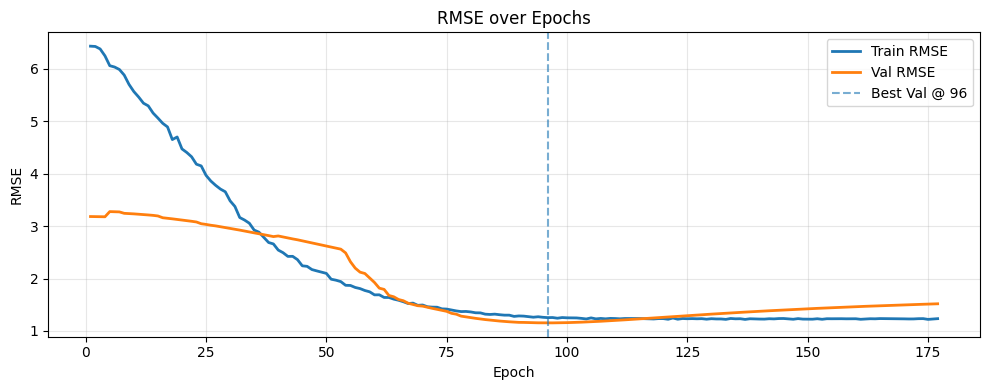

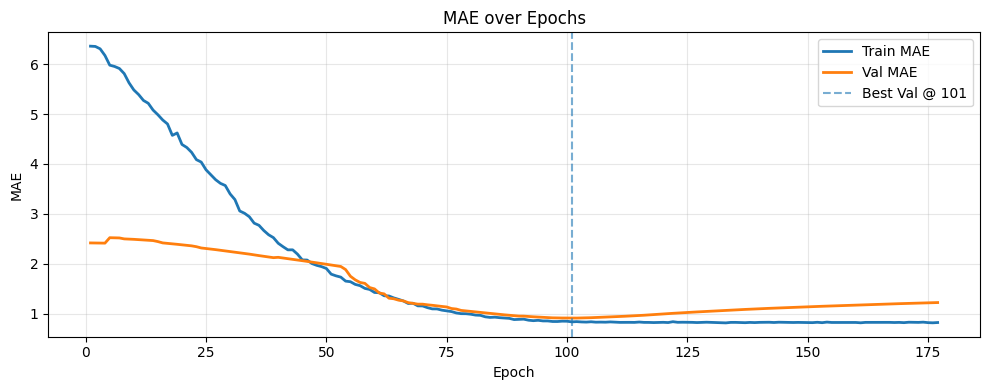

In [60]:
# Convert histories to arrays
rmse_tr = np.array(rmse_tr_hist, dtype=float)
rmse_va = np.array(rmse_va_hist, dtype=float)
mae_tr  = np.array(mae_tr_hist,  dtype=float)
mae_va  = np.array(mae_va_hist,  dtype=float)

epochs_vec = np.arange(1, len(rmse_tr) + 1, dtype=int)

# Find best (minimum) val epochs
best_rmse_epoch = int(np.argmin(rmse_va)) + 1 if rmse_va.size else -1
best_mae_epoch  = int(np.argmin(mae_va))  + 1 if mae_va.size else -1

print(f"[RMSE] best val = {rmse_va.min():.6f} at epoch {best_rmse_epoch}" if rmse_va.size else "[RMSE] no data")
print(f"[MAE ] best val = {mae_va.min():.6f} at epoch {best_mae_epoch}"  if mae_va.size  else "[MAE ] no data")

# --- RMSE figure ---
plt.figure(figsize=(10,4))
plt.plot(epochs_vec, rmse_tr, label="Train RMSE", linewidth=2)
plt.plot(epochs_vec, rmse_va, label="Val RMSE",   linewidth=2)
if rmse_va.size:
    plt.axvline(best_rmse_epoch, linestyle="--", alpha=0.6, label=f"Best Val @ {best_rmse_epoch}")
plt.title("RMSE over Epochs")
plt.xlabel("Epoch"); plt.ylabel("RMSE")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

# --- MAE figure ---
plt.figure(figsize=(10,4))
plt.plot(epochs_vec, mae_tr, label="Train MAE", linewidth=2)
plt.plot(epochs_vec, mae_va, label="Val MAE",   linewidth=2)
if mae_va.size:
    plt.axvline(best_mae_epoch, linestyle="--", alpha=0.6, label=f"Best Val @ {best_mae_epoch}")
plt.title("MAE over Epochs")
plt.xlabel("Epoch"); plt.ylabel("MAE")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

In [61]:
ckpt_path = os.path.join(ckpt_dir, "castle_single_best.pt")
assert os.path.isfile(ckpt_path), f"Checkpoint not found: {ckpt_path}"

# Load checkpoint (safe map to CPU)
ckpt = torch.load(ckpt_path, map_location="cpu")
print(f"Loaded checkpoint epoch={ckpt.get('epoch','?')} | "
      f"val RMSE={ckpt.get('metrics',{}).get('RMSE','?'):.6f} "
      f"val MAE={ckpt.get('metrics',{}).get('MAE','?'):.6f}")

# Restore weights into current model (handles DP or single-GPU)
model_core = model.module if isinstance(model, torch.nn.DataParallel) else model
missing, unexpected = model_core.load_state_dict(ckpt["model"], strict=False)
if missing or unexpected:
    print("[WARN] load_state_dict: missing:", missing, "unexpected:", unexpected)

# Use the scaler from the checkpoint for test (no refit)
scale_test = {"mu": ckpt.get("scale_mu", None), "std": ckpt.get("scale_std", None)}
assert (scale_test["mu"] is not None) and (scale_test["std"] is not None), "Missing scaler in checkpoint."

# Build TEST loader (no shuffle; prefetcher ON)
bs_test  = 256
num_workers_te = min(12, max(4, (os.cpu_count() or 8) - 4))
dl_te = make_loader(
    test_ix, shuffle=False, data=data, scale=scale_test, device=device,
    batch_size=bs_test, prefer_full_batch=False, num_workers=num_workers_te,
    return_prefetcher=True
)

# Inference
model_core.eval()
model_core.clear_residual_buffer()

te_preds, te_tgts, te_dates = [], [], []
t0 = time.time()
with torch.no_grad():
    for batch in dl_te:
        (soil, soil_m, soil_d,
         ind,  ind_m,  ind_d,
         wth,  wth_m,  wth_d,
         crop_z, crop_m, crop_d,
         anc,  anc_m,  anc_d,
         y) = batch

        # Init/resize FIFO for current batch size (test is batched)
        if (getattr(model_core, "_res_fifo", None) is None) or \
           (model_core._res_fifo is not None and model_core._res_fifo.size(0) != y.size(0)):
            model_core.init_residual_buffer(batch_size=y.size(0), device=y.device, dtype=y.dtype)

        with torch.autocast("cuda", dtype=amp_dtype, enabled=use_amp):
            yhat, aux = model(
                soil_x=soil,      soil_m=soil_m,      soil_d=soil_d,
                indoor_x=ind,     indoor_m=ind_m,     indoor_d=ind_d,
                weather_x=wth,    weather_m=wth_m,    weather_d=wth_d,
                crop_x=crop_z,    crop_m=crop_m,      crop_d=crop_d,
                anchor_x=anc,     anchor_m=anc_m,     anchor_d=anc_d,
            )

        te_preds.append(yhat.detach())
        te_tgts.append(y.detach())
        model_core.update_residuals((yhat - y).abs())

t_eval = time.time() - t0

# Stack & metrics
yhat_te = torch.cat(te_preds, dim=0) if te_preds else torch.zeros((0,1), device=device)
y_te    = torch.cat(te_tgts,  dim=0) if te_tgts  else torch.zeros((0,1), device=device)

test_rmse = _rmse_tensor(yhat_te, y_te).item() if y_te.numel() else float("inf")
test_mae  = _mae_tensor(yhat_te,  y_te).item()  if y_te.numel() else float("inf")

print(f"TEST | RMSE={test_rmse:.6f} | MAE={test_mae:.6f} | {t_eval:.1f}s | bs_te={bs_test} | nw_te={num_workers_te}")

Loaded checkpoint epoch=96 | val RMSE=1.154242 val MAE=0.921058


/tmp/ipykernel_1240220/295700585.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


TEST | RMSE=0.359655 | MAE=0.271090 | 3.4s | bs_te=256 | nw_te=12


/home/cuongdo/.conda/envs/CuongDo/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


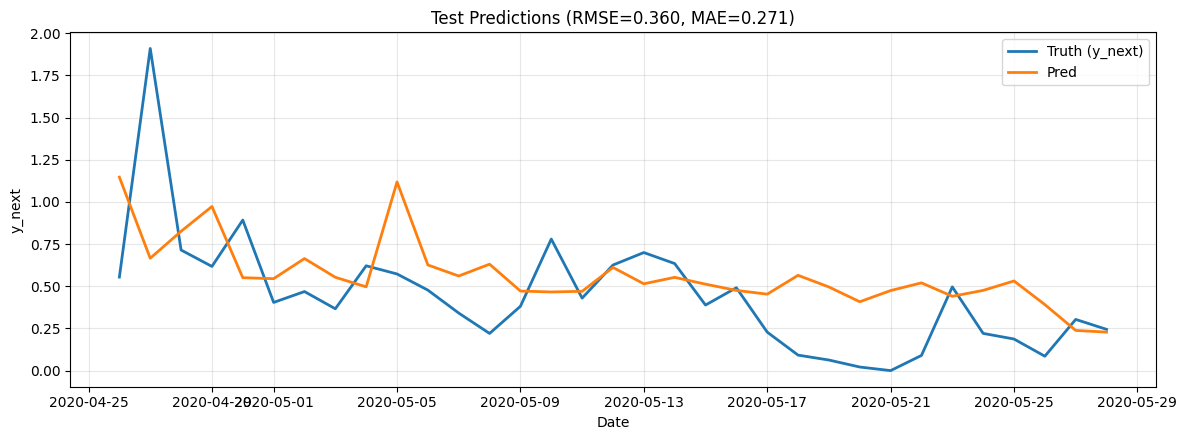

In [62]:
dates_np = np.array(dates_all, dtype='datetime64[ns]')
dates_pd = pd.to_datetime(dates_np[test_ix])

y_te_cpu     = y_te.detach().cpu().numpy().reshape(-1)
yhat_te_cpu  = yhat_te.detach().cpu().numpy().reshape(-1)

plt.figure(figsize=(12,4.5))
plt.plot(dates_pd, y_te_cpu,    label="Truth (y_next)", linewidth=2)
plt.plot(dates_pd, yhat_te_cpu, label="Pred",           linewidth=2)
plt.title(f"Test Predictions (RMSE={test_rmse:.3f}, MAE={test_mae:.3f})")
plt.xlabel("Date"); plt.ylabel("y_next")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

In [63]:
aaaaaaaa

NameError: name 'aaaaaaaa' is not defined

# GRUD

In [30]:
from dataclasses import dataclass
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F

In [31]:
@dataclass
class GRUDConfig:
    # Data keys (so later the training loop can reuse your make_loader without guessing)
    key_x: str = "x"          # [B,T,P] float
    key_mask: str = "mask"    # [B,T,P] float {0,1}
    key_delta: str = "delta"  # [B,T,P] float
    key_y: str = "y_next"     # [B] or [B,1]

    # Model architecture
    input_dim: int = -1       # set this when you know P
    hidden_dim: int = 128
    dropout: float = 0.10
    use_mask_concat: bool = True  # concat mask m_t to GRU input (common in the paper)

    # Means handling (paper-faithful default: fixed empirical means)
    # - "empirical_fixed": register_buffer with per-feature means computed from TRAIN only
    # - "learnable": treat x_mean as a learnable Parameter (variant sometimes used)
    x_mean_mode: str = "empirical_fixed"

    # Precision (for later training use, but harmless here)
    amp_dtype = torch.bfloat16  # safe default on RTX 40xx

# -------- GRU-D internals --------
class GRUDCell(nn.Module):
    """
    GRU-D decay with NaN-safe handling.
    x_mean_mode: "empirical_fixed" (buffer) or "learnable" (Parameter)
    """
    def __init__(self, p, h, x_mean_vec=None, use_mask_concat=True, x_mean_mode="empirical_fixed"):
        super().__init__()
        self.p = p
        self.h = h
        self.use_mask_concat = use_mask_concat

        # ---- x_mean handling ----
        if x_mean_vec is None:
            x_mean_vec = torch.zeros(p)
        x_mean_vec = x_mean_vec.clone().detach().float()
        if x_mean_mode == "learnable":
            self.x_mean = nn.Parameter(x_mean_vec)
        else:
            self.register_buffer("x_mean", x_mean_vec)

        # Decays
        self.decay_x = nn.Linear(p, p, bias=True)
        self.decay_h = nn.Linear(1, h, bias=True)

        in_size = p + (p if use_mask_concat else 0)
        self.gru = nn.GRUCell(input_size=in_size, hidden_size=h)

    @torch.no_grad()
    def set_x_mean(self, x_mean_vec: torch.Tensor):
        x_mean_vec = x_mean_vec.detach().float()
        if isinstance(self.x_mean, torch.nn.Parameter):
            self.x_mean.data.copy_(x_mean_vec)
        else:
            # buffer
            device = self.x_mean.device
            self.x_mean = x_mean_vec.to(device)

    def forward(self, x_t, m_t, d_t, h_prev, x_last):
        # --- sanitize inputs ---
        m_t = torch.nan_to_num(m_t, nan=0.0, posinf=1.0, neginf=0.0).clamp_(0.0, 1.0)
        x_obs = torch.nan_to_num(x_t, nan=0.0, posinf=0.0, neginf=0.0)
        d_cln = torch.nan_to_num(d_t, nan=0.0, posinf=0.0, neginf=0.0)

        # Input decay
        gamma_x = torch.exp(-F.relu(self.decay_x(d_cln)))      # (0,1]
        x_backfill = gamma_x * x_last + (1.0 - gamma_x) * self.x_mean
        x_imp = torch.where(m_t > 0.5, x_obs, x_backfill)

        # Hidden decay
        d_h = d_cln.mean(dim=-1, keepdim=True)                 # [B,1]
        gamma_h = torch.exp(-F.relu(self.decay_h(d_h)))
        h_tilde = gamma_h * h_prev

        z = x_imp if not self.use_mask_concat else torch.cat([x_imp, m_t], dim=-1)
        h = self.gru(z, h_tilde)

        # Update last observed
        x_last_new = torch.where(m_t > 0.5, x_obs, x_last)
        return h, x_last_new, x_imp

class GRUDBackbone(nn.Module):
    """
    Many-to-one GRU-D: unrolls T steps, returns final hidden state.
    """
    def __init__(self, cfg: GRUDConfig, x_mean_vec: Optional[torch.Tensor] = None):
        super().__init__()
        assert cfg.input_dim > 0, "cfg.input_dim (P) must be set before building GRU-D."
        self.cfg = cfg
        self.cell = GRUDCell(
            p=cfg.input_dim,
            h=cfg.hidden_dim,
            x_mean_vec=x_mean_vec,
            use_mask_concat=cfg.use_mask_concat,
            x_mean_mode=cfg.x_mean_mode,
        )
        self.dropout = nn.Dropout(cfg.dropout)

    @torch.no_grad()
    def set_x_mean(self, x_mean_vec: torch.Tensor):
        self.cell.set_x_mean(x_mean_vec)

    def forward(self, x, m, d):
        """
        x, m, d: [B,T,P]
        """
        B, T, P = x.shape
        device = x.device
        h = torch.zeros(B, self.cfg.hidden_dim, device=device)
        # start x_last at mean (safer than zeros)
        x_last = self.cell.x_mean.expand(B, P)

        for t in range(T):
            x_t = x[:, t, :]
            m_t = m[:, t, :]
            d_t = d[:, t, :]
            h, x_last, _ = self.cell(x_t, m_t, d_t, h, x_last)

        return self.dropout(h)  # [B,H]


class GRUDRegressor(nn.Module):
    """
    GRU-D backbone + small MLP head -> scalar regression target (e.g., y_next).
    """
    def __init__(self, cfg: GRUDConfig, x_mean_vec: Optional[torch.Tensor] = None):
        super().__init__()
        self.cfg = cfg
        self.backbone = GRUDBackbone(cfg, x_mean_vec=x_mean_vec)
        H = cfg.hidden_dim
        self.head = nn.Sequential(
            nn.Linear(H, H // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg.dropout),
            nn.Linear(H // 2, 1),
        )

    @torch.no_grad()
    def set_x_mean(self, x_mean_vec: torch.Tensor):
        self.backbone.set_x_mean(x_mean_vec)

    def forward(self, x, m, d):
        h = self.backbone(x, m, d)
        y = self.head(h).squeeze(-1)  # [B]
        return y

In [32]:
data = {
    "soil_all": soil_all, "soil_mask": soil_mask, "soil_delta": soil_delta,
    "indoor_all": indoor_all, "indoor_mask": indoor_mask, "indoor_delta": indoor_delta,
    "weather_all": weather_all, "weather_mask": weather_mask, "weather_delta": weather_delta,
    "crop_all": crop_all, "crop_mask": crop_mask, "crop_delta": crop_delta,
    "anchor_all": anchor_all, "anchor_mask": anchor_mask, "anchor_delta": anchor_delta,
    "y_all": y_all,
}
scale = {"mu": None, "std": None}
device = torch.device("cuda:0")

In [33]:
dl_grud_tr = make_loader(
    train_ix, shuffle=True, data=data, scale={"mu": None, "std": None},
    device=device, batch_size=8, prefer_full_batch=False,
    num_workers=4, return_prefetcher=True
)
dl_grud_va = make_loader(
    val_ix, shuffle=False, data=data, scale={"mu": None, "std": None},
    device=device, batch_size=14, prefer_full_batch=False,
    num_workers=2, return_prefetcher=True
)
dl_grud_te = make_loader(
    test_ix, shuffle=False, data=data, scale={"mu": None, "std": None},
    device=device, batch_size=256, prefer_full_batch=False,
    num_workers=12, return_prefetcher=True
)

In [34]:
GRUD_MODALITIES = ["soil", "indoor", "weather", "crop", "anchor"]
GRUD_KEYS_WITH_ANCHOR = [
    "soil_all","soil_mask","soil_delta",
    "indoor_all","indoor_mask","indoor_delta",
    "weather_all","weather_mask","weather_delta",
    "crop_all","crop_mask","crop_delta",
    "anchor_all","anchor_mask","anchor_delta",
    "y_all",
]
def _normalize_batch(batch):
    """Return a dict with named fields whether batch is dict or tuple/list in this order."""
    if isinstance(batch, dict):
        return batch
    assert isinstance(batch, (list, tuple)), "Batch must be dict, list, or tuple"
    assert len(batch) == len(GRUD_KEYS_WITH_ANCHOR), \
        f"Unexpected batch length {len(batch)}; expected {len(GRUD_KEYS_WITH_ANCHOR)}"
    return {k: v for k, v in zip(GRUD_KEYS_WITH_ANCHOR, batch)}

def _ensure_3d_and_align_time(tensors, T_target=None):
    """
    tensors: list of tensors each [B,T,P] or [B,P].
    - Make each 3D by unsqueezing dim=1 if needed.
    - If T_target given, repeat tensors along time to match it when their T==1.
      If a tensor has T!=T_target and T!=1 -> error (incompatible).
    Returns: list of tensors [B,T_target,P], computed T_target (int).
    """
    out = []
    Ts = []
    for t in tensors:
        if t.ndim == 2:             # [B,P] -> [B,1,P]
            t = t.unsqueeze(1)
        elif t.ndim != 3:
            raise ValueError(f"Expected 2D or 3D tensor, got shape {tuple(t.shape)}")
        Ts.append(t.shape[1])
        out.append(t)

    T_max = max(Ts) if T_target is None else T_target
    aligned = []
    for t in out:
        B, T, P = t.shape
        if T == T_max:
            aligned.append(t)
        elif T == 1:
            # repeat across time axis to match T_max
            aligned.append(t.repeat(1, T_max, 1))
        else:
            raise ValueError(f"Incompatible time dims: got T={T}, cannot align to T_target={T_max}")
    return aligned, T_max

def grud_from_batch(batch, mods=GRUD_MODALITIES):
    b = _normalize_batch(batch)

    # collect blocks
    Xs, Ms, Ds = [], [], []
    for name in mods:
        Xs.append(b[f"{name}_all"])    # [B,T,P_i] or [B,P_i]
        Ms.append(b[f"{name}_mask"])   # [B,T,P_i] or [B,P_i]
        Ds.append(b[f"{name}_delta"])  # [B,T,P_i] or [B,P_i]

    # ensure all are tensors
    for t in Xs + Ms + Ds:
        if not isinstance(t, torch.Tensor):
            t = torch.as_tensor(t)

    # align time dims (handles 2D -> 3D and repeats T=1 to T_max)
    Xs, T_max = _ensure_3d_and_align_time(Xs)
    Ms, _     = _ensure_3d_and_align_time(Ms, T_target=T_max)
    Ds, _     = _ensure_3d_and_align_time(Ds, T_target=T_max)

    # concat along feature axis
    x = torch.cat(Xs, dim=2)          # [B,T_max,P_total]
    m = torch.cat(Ms, dim=2)          # [B,T_max,P_total]
    d = torch.cat(Ds, dim=2)          # [B,T_max,P_total]

    y = b["y_all"]
    if y.ndim == 2 and y.size(-1) == 1:
        y = y.squeeze(-1)             # [B]

    return x, m, d, y

In [35]:
b0 = next(iter(dl_grud_tr))
xb0, mb0, db0, yb0 = grud_from_batch(b0)  # should work
P = xb0.shape[-1]
print("Shapes:", xb0.shape, mb0.shape, db0.shape, yb0.shape)

Shapes: torch.Size([8, 288, 31]) torch.Size([8, 288, 31]) torch.Size([8, 288, 31]) torch.Size([8])


In [36]:
cfg = GRUDConfig(
    key_x="x",
    key_mask="mask",
    key_delta="delta",
    key_y="y_next",
    input_dim=P,
    hidden_dim=128,
    dropout=0.10,
    use_mask_concat=True,
    x_mean_mode="empirical_fixed",
)
grud_model = GRUDRegressor(cfg).to(device)

In [37]:
with torch.no_grad():
    sum_feat = torch.zeros(P, dtype=torch.float64, device=device)
    cnt_feat = torch.zeros(P, dtype=torch.float64, device=device)
    for batch in dl_grud_tr:
        xb, mb, _, _ = grud_from_batch(batch)
        xb = xb.to(device, non_blocking=True)
        mb = mb.to(device, non_blocking=True)

        # clean x before multiplying by mask to avoid 0*NaN=NaN
        xb_clean = torch.nan_to_num(xb, nan=0.0, posinf=0.0, neginf=0.0)
        mb_clean = torch.nan_to_num(mb, nan=0.0, posinf=1.0, neginf=0.0).clamp_(0.0, 1.0)

        sum_feat += (xb_clean * mb_clean).sum(dim=(0,1)).to(torch.float64)
        cnt_feat += mb_clean.sum(dim=(0,1)).to(torch.float64)
    x_mean_vec = (sum_feat / torch.clamp(cnt_feat, min=1.0)).to(torch.float32)
    x_mean_vec[~torch.isfinite(x_mean_vec)] = 0.0
    grud_model.set_x_mean(x_mean_vec)
print(f"[GRU-D] ready | modalities={GRUD_MODALITIES} | P={P} | means set (TRAIN-only)")

[GRU-D] ready | modalities=['soil', 'indoor', 'weather', 'crop', 'anchor'] | P=31 | means set (TRAIN-only)


In [38]:
SEED = 1234
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False  # keep perf reasonable

In [41]:
grud_ckpt_path = "./castle_ckpts/grud_fair_best.pt"
os.makedirs(os.path.dirname(grud_ckpt_path), exist_ok=True)

# --- Hyperparams (tweak if you like) ---
grud_epochs      = 160
grud_warmup_ep   = 5
grud_lr          = 3e-4
grud_wd          = 2e-4
grud_clip        = 1.0
grud_dropout     = cfg.dropout          # from your cfg
grud_hidden      = cfg.hidden_dim       # from your cfg
grud_amp_dtype   = cfg.amp_dtype        # bfloat16 on 4090
grud_patience    = 12                   # early stop patience (epochs)

# --- Optimizer & scheduler ---
grud_opt   = torch.optim.AdamW(grud_model.parameters(), lr=grud_lr, weight_decay=grud_wd)
grud_sched = torch.optim.lr_scheduler.CosineAnnealingLR(grud_opt, T_max=max(1, grud_epochs - grud_warmup_ep))

In [44]:
import time
best_va_rmse = float("inf")
best_va_mae  = float("inf")
pat_left     = grud_patience
t0 = time.time()

for ep in range(1, grud_epochs + 1):
    # warmup
    if ep <= grud_warmup_ep:
        warm_lr = grud_lr * ep / max(1, grud_warmup_ep)
        for pg in grud_opt.param_groups:
            pg["lr"] = warm_lr

    # ---- Train ----
    grud_model.train()
    tr_loss_acc, tr_steps = 0.0, 0
    for batch in dl_grud_tr:
        xb, mb, db, yb = grud_from_batch(batch)
        xb = xb.to(device, non_blocking=True); mb = mb.to(device, non_blocking=True)
        db = db.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True)

        # skip pathological batches
        if not torch.isfinite(xb).all() or not torch.isfinite(mb).all() or not torch.isfinite(db).all() or not torch.isfinite(yb).all():
            print("[warn] non-finite batch skipped"); continue

        grud_opt.zero_grad(set_to_none=True)
        with torch.autocast(device_type="cuda", dtype=grud_amp_dtype):
            y_hat = grud_model(xb, mb, db)
            loss  = F.mse_loss(y_hat, yb, reduction="mean")  # switch to F.l1_loss or Huber if you prefer
        if not torch.isfinite(loss):
            print("[warn] non-finite loss skipped"); continue

        loss.backward()
        if grud_clip and grud_clip > 0:
            nn.utils.clip_grad_norm_(grud_model.parameters(), grud_clip)
        grud_opt.step()

        tr_loss_acc += float(loss.detach().cpu())
        tr_steps    += 1

    if ep > grud_warmup_ep:
        grud_sched.step()

    # ---- Validate ----
    grud_model.eval()
    with torch.no_grad():
        mae_sum = 0.0; mse_sum = 0.0; n = 0
        for batch in dl_grud_va:
            xb, mb, db, yb = grud_from_batch(batch)
            xb = xb.to(device); mb = mb.to(device); db = db.to(device); yb = yb.to(device)
            with torch.autocast(device_type="cuda", dtype=grud_amp_dtype):
                y_hat = grud_model(xb, mb, db)
                err = y_hat - yb
            # guard (should be fine after our sanitization)
            err = torch.nan_to_num(err, nan=0.0, posinf=0.0, neginf=0.0)
            mae_sum += err.abs().sum().item()
            mse_sum += (err * err).sum().item()
            n += yb.numel()
        va_mae  = mae_sum / max(1, n)
        va_rmse = math.sqrt(mse_sum / max(1, n))

    tr_loss_mean = tr_loss_acc / max(1, tr_steps)
    print(f"GRU-D | Epoch {ep:02d}/{grud_epochs} | tr_loss={tr_loss_mean:.4f} "
          f"| VA_RMSE={va_rmse:.4f} MAE={va_mae:.4f} | LR={grud_opt.param_groups[0]['lr']:.2e}")

    improved = (va_rmse < best_va_rmse - 1e-9) or (abs(va_rmse - best_va_rmse) <= 1e-9 and va_mae < best_va_mae)
    if improved:
        best_va_rmse, best_va_mae = va_rmse, va_mae
        pat_left = grud_patience
        torch.save({"model": grud_model.state_dict(),
                    "cfg": cfg.__dict__,
                    "meta": {"modalities": GRUD_MODALITIES, "P": cfg.input_dim, "seed": SEED}},
                   grud_ckpt_path)
    else:
        pat_left -= 1
        if pat_left <= 0:
            print("GRU-D | Early stop."); break

[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
GRU-D | Epoch 01/160 | tr_loss=0.0000 | VA_RMSE=5.4180 MAE=4.4735 | LR=6.00e-05
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
GRU-D | Epoch 02/160 | tr_loss=0.0000 | VA_RMSE=5.4180 MAE=4.4735 | LR=1.20e-04
[warn] n

/home/cuongdo/.conda/envs/CuongDo/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


GRU-D | Epoch 06/160 | tr_loss=0.0000 | VA_RMSE=5.4180 MAE=4.4735 | LR=3.00e-04
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
GRU-D | Epoch 07/160 | tr_loss=0.0000 | VA_RMSE=5.4180 MAE=4.4735 | LR=3.00e-04
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
[warn] non-finite batch skipped
GRU-D | 

In [45]:
ck = torch.load("/home/cuongdo/castle_ckpts/grud_fair_best.pt", map_location=device)
grud_model.load_state_dict(ck["model"])
grud_model.eval()
with torch.no_grad():
    mae_sum = 0.0; mse_sum = 0.0; n = 0
    for batch in dl_grud_te:
        xb, mb, db, yb = grud_from_batch(batch)
        xb = xb.to(device); mb = mb.to(device); db = db.to(device); yb = yb.to(device)
        with torch.autocast(device_type="cuda", dtype=grud_amp_dtype):
            y_hat = grud_model(xb, mb, db)
            err = y_hat - yb
        err = torch.nan_to_num(err, nan=0.0, posinf=0.0, neginf=0.0)
        mae_sum += err.abs().sum().item()
        mse_sum += (err * err).sum().item()
        n += yb.numel()
    te_mae  = mae_sum / max(1, n)
    te_rmse = math.sqrt(mse_sum / max(1, n))

dt = time.time() - t0
print(f"GRU-D | DONE | Best VAL RMSE={best_va_rmse:.6f} MAE={best_va_mae:.6f} | "
      f"TEST RMSE={te_rmse:.6f} MAE={te_mae:.6f} | {dt:.1f}s | ckpt={grud_ckpt_path}")

/tmp/ipykernel_2173650/1227860953.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load("/home/cuongdo/castle_ckpts/grud_fair_best.pt", map_location=device)


GRU-D | DONE | Best VAL RMSE=5.417987 MAE=4.473480 | TEST RMSE=0.566880 MAE=0.454532 | 11.0s | ckpt=./castle_ckpts/grud_fair_best.pt


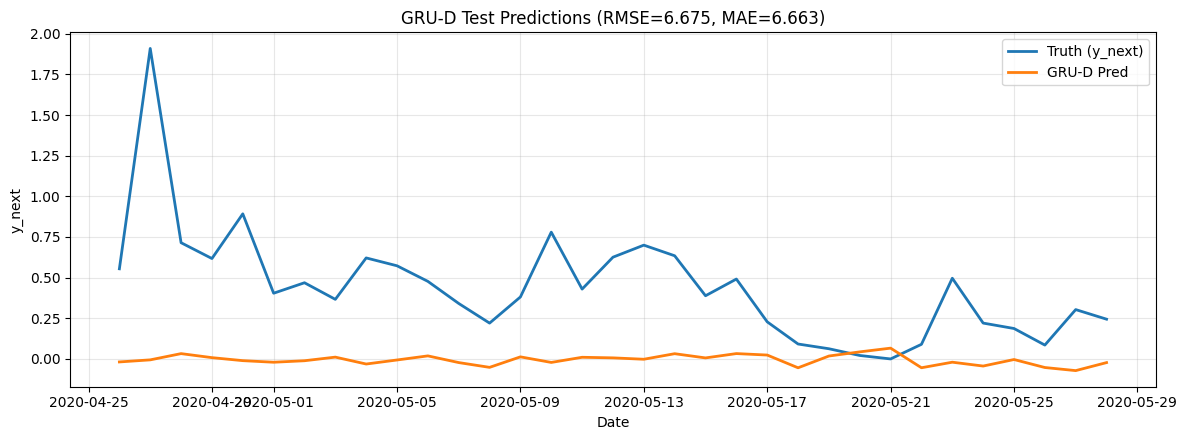

In [81]:
yhat_grud_list, y_grud_list = [], []
grud_model.eval()
with torch.no_grad():
    for batch in dl_grud_te:
        xb, mb, db, yb = grud_from_batch(batch)
        with torch.autocast(device_type="cuda", dtype=grud_amp_dtype):
            pred = grud_model(xb.to(device), mb.to(device), db.to(device))  # bf16 under autocast
        # cast to float32 before numpy()
        yhat_grud_list.append(pred.detach().to(torch.float32).cpu().numpy().reshape(-1))
        y_grud_list.append(yb.detach().to(torch.float32).cpu().numpy().reshape(-1))

# Flatten (already done)
yhat_grud_te  = np.concatenate(yhat_grud_list).reshape(-1)
ytrue_grud_te = np.concatenate(y_grud_list).reshape(-1)
# Align dates to number of GRU-D test points (windowing -> fewer points)
n_pts = len(ytrue_grud_te)
plot_dates = dates_pd[-n_pts:] if len(dates_pd) != n_pts else dates_pd
# Plot
plt.figure(figsize=(12,4.5))
plt.plot(plot_dates, ytrue_grud_te, label="Truth (y_next)", linewidth=2)
plt.plot(plot_dates, yhat_grud_te,  label="GRU-D Pred",   linewidth=2)
plt.title(f"GRU-D Test Predictions (RMSE={te_rmse:.3f}, MAE={te_mae:.3f})")
plt.xlabel("Date"); plt.ylabel("y_next")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

# Phased LSTM

In [47]:
import math, json, os, random
from dataclasses import dataclass
from typing import Tuple, Optional, List
import torch
from torch import nn, Tensor

In [48]:
STEP_MINUTES = 5.0
HIDDEN_SIZE = 128
NUM_LAYERS = 1
DROPOUT = 0.0
R_ON = 0.05
LEAK = 0.001
EPOCHS = 80
LR = 3e-4
WEIGHT_DECAY = 1e-3
GRAD_CLIP = 1.0
BEST_PATH = "./castle_ckpts/Plstm_fair_best.pt"
os.makedirs(os.path.dirname(BEST_PATH), exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose which inputs you want to concatenate as features X
# Set any of these to False if you want to exclude (to match fairness constraints).
FEATURE_FLAGS = {
    "soil_all":   True, "indoor_all": True, "weather_all": True, "crop_all": True, "anchor_all": True,
    "soil_mask":  True, "indoor_mask": True, "weather_mask": True, "crop_mask": True, "anchor_mask": True,
    "soil_delta": True, "indoor_delta": True, "weather_delta": True, "crop_delta": True, "anchor_delta": True,
}

In [49]:
class PhasedLSTMCell(nn.Module):
    """
    Phased LSTM cell (Neil, Pfeiffer & Liu, 2016).
    Inputs per step:
      x_t: [B, D]
      (h_prev, c_prev): [B, H], [B, H]
      t_t: [B, 1] absolute time
    """
    def __init__(self, input_size: int, hidden_size: int, r_on: float = 0.05, leak: float = 0.001):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.r_on = float(r_on)
        self.leak = float(leak)

        self.W = nn.Linear(input_size + hidden_size, 4 * hidden_size)
        self.log_tau = nn.Parameter(torch.empty(hidden_size))
        self.shift_s = nn.Parameter(torch.empty(hidden_size))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W.weight)
        nn.init.zeros_(self.W.bias)
        with torch.no_grad():
            self.log_tau.uniform_(0.0, math.log(100.0))  # tau in [1,100] (units of t)
            tau = torch.exp(self.log_tau)
            self.shift_s.copy_(torch.rand_like(tau) * tau)

    def k_time_gate(self, t_t: Tensor) -> Tensor:
        # Broadcast params to batch
        tau = torch.exp(self.log_tau).unsqueeze(0)   # [1,H]
        s   = self.shift_s.unsqueeze(0)              # [1,H]
        t   = t_t.expand(-1, self.hidden_size)       # [B,H]
        tau = tau.expand_as(t); s = s.expand_as(t)

        phi = ((t - s) % tau) / tau                  # [B,H] in [0,1)
        r_on, leak = self.r_on, self.leak
        k = torch.where(
            phi < (r_on / 2),
            2 * phi / r_on,
            torch.where(
                phi < r_on,
                2 - 2 * phi / r_on,
                leak * phi
            )
        )
        return k.clamp_(0.0, 1.0)

    def forward(self, x_t: Tensor, state: Tuple[Tensor, Tensor], t_t: Tensor):
        h_prev, c_prev = state
        k = self.k_time_gate(t_t)                    # [B,H]
        z = self.W(torch.cat([x_t, h_prev], dim=-1))
        i, f, o, g = torch.chunk(z, 4, dim=-1)
        i = torch.sigmoid(i); f = torch.sigmoid(f); o = torch.sigmoid(o); g = torch.tanh(g)
        c_candidate = f * c_prev + i * g
        c_t = k * c_candidate + (1.0 - k) * c_prev
        h_t = k * (o * torch.tanh(c_t)) + (1.0 - k) * h_prev
        return h_t, (h_t, c_t)

class PhasedLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 1, r_on: float = 0.05, leak: float = 0.001, dropout: float = 0.0):
        super().__init__()
        self.layers = nn.ModuleList([
            PhasedLSTMCell(input_size if l == 0 else hidden_size, hidden_size, r_on=r_on, leak=leak)
            for l in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout) if (dropout > 0 and num_layers > 1) else nn.Identity()

    def forward(self, x: Tensor, t: Tensor, state: Optional[Tuple[Tensor, Tensor]] = None):
        B, T, _ = x.shape
        H = self.layers[0].hidden_size
        if state is None:
            h_prev = [x.new_zeros(B, H) for _ in self.layers]
            c_prev = [x.new_zeros(B, H) for _ in self.layers]
        else:
            h0, c0 = state
            h_prev = [h0[l] for l in range(len(self.layers))]
            c_prev = [c0[l] for l in range(len(self.layers))]

        outputs = []
        for step in range(T):
            x_t = x[:, step, :]
            t_t = t[:, step, :]  # [B,1]
            for l, cell in enumerate(self.layers):
                h_l, (h_l, c_l) = cell(x_t, (h_prev[l], c_prev[l]), t_t)
                x_t = h_l if (l == len(self.layers) - 1) else self.dropout(h_l)
                h_prev[l], c_prev[l] = h_l, c_l
            outputs.append(x_t.unsqueeze(1))
        y = torch.cat(outputs, dim=1)  # [B,T,H]
        h_n = torch.stack(h_prev, dim=0)
        c_n = torch.stack(c_prev, dim=0)
        return y, (h_n, c_n)

class LastTimestep(nn.Module):
    def forward(self, seq_and_state):
        seq, _ = seq_and_state
        return seq[:, -1, :]

class PhasedBaseline(nn.Module):
    """Sequence-to-one regression: Phased LSTM -> Linear."""
    def __init__(self, input_size: int, hidden_size: int = HIDDEN_SIZE, num_layers: int = NUM_LAYERS,
                 dropout: float = DROPOUT, r_on: float = R_ON, leak: float = LEAK):
        super().__init__()
        self.core = PhasedLSTM(input_size, hidden_size, num_layers=num_layers, r_on=r_on, leak=leak, dropout=dropout)
        self.pick = LastTimestep()
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, x: Tensor, t: Tensor):
        seq, state = self.core(x, t)
        feat = self.pick((seq, state))
        return self.head(feat)

In [50]:
def set_seed(seed: int = 1234):
    random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.use_deterministic_algorithms(False)

def rmse(pred: Tensor, target: Tensor) -> Tensor:
    return torch.sqrt(torch.mean((pred - target) ** 2))

def mae(pred: Tensor, target: Tensor) -> Tensor:
    return torch.mean(torch.abs(pred - target))

In [51]:
ORDERED_KEYS = [
    "soil_all","soil_mask","soil_delta",
    "indoor_all","indoor_mask","indoor_delta",
    "weather_all","weather_mask","weather_delta",
    "crop_all","crop_mask","crop_delta",
    "anchor_all","anchor_mask","anchor_delta",
    "y_all",
]

# Use ONLY raw streams for Phased LSTM
RAW_FEATURE_KEYS = ["soil_all","indoor_all","weather_all","crop_all","anchor_all"]
TARGET_KEY       = "y_all"

def _listbatch_to_dict(batch_list):
    assert isinstance(batch_list, (list, tuple)), f"Expected list/tuple, got {type(batch_list)}"
    assert len(batch_list) == len(ORDERED_KEYS), f"Got {len(batch_list)} items, expected {len(ORDERED_KEYS)}"
    return {k: v for k, v in zip(ORDERED_KEYS, batch_list)}

def _choose_ref_key(bdict):
    # pick a present raw stream to read B,T
    for k in RAW_FEATURE_KEYS:
        if k in bdict and bdict[k] is not None:
            return k
    raise ValueError(f"No raw stream found among {RAW_FEATURE_KEYS}. Got keys: {list(bdict.keys())[:20]}")

def _ensure_time(bdict, step_minutes: float = 5.0):
    # If you already have absolute time in batch (e.g., 't_abs'), keep it.
    for tkey in ("t_abs","time_abs","t","times"):
        if tkey in bdict and bdict[tkey] is not None:
            t = bdict[tkey]
            if t.ndim == 2: t = t[..., None]
            assert t.ndim == 3 and t.shape[-1] == 1, f"{tkey} must be [B,T,1], got {tuple(t.shape)}"
            bdict["t_abs"] = t
            return bdict

    # Otherwise synthesize uniform grid (regular sampling)
    ref = _choose_ref_key(bdict)
    B, T = bdict[ref].shape[:2]
    idx = torch.arange(T, device=bdict[ref].device, dtype=torch.float32)[None, :, None]
    bdict["t_abs"] = idx.repeat(B, 1, 1) * float(step_minutes)
    return bdict

def _keep_only_raw_and_target(bdict):
    out = {k: bdict[k] for k in RAW_FEATURE_KEYS if (k in bdict and bdict[k] is not None)}
    assert TARGET_KEY in bdict, f"Missing target '{TARGET_KEY}'"
    out[TARGET_KEY] = bdict[TARGET_KEY]
    return out

class PLSTMLoader:
    """
    Lightweight wrapper over your existing DataLoader/Prefetcher.
    Yields dicts with only { RAW_FEATURE_KEYS..., 'y_all', 't_abs' }.
    """
    def __init__(self, base_loader, step_minutes: float = 5.0):
        self.base_loader   = base_loader
        self.step_minutes  = step_minutes

    def __iter__(self):
        for batch in self.base_loader:
            # Your loader yields a list of 16 tensors
            if isinstance(batch, (list, tuple)) and len(batch) == len(ORDERED_KEYS) and all(torch.is_tensor(x) for x in batch):
                b = _listbatch_to_dict(batch)
            elif isinstance(batch, dict):
                b = batch  # already dict-like
            else:
                raise ValueError(f"Unexpected batch type: {type(batch)}")

            b = _keep_only_raw_and_target(b)
            b = _ensure_time(b, step_minutes=self.step_minutes)
            yield b

    # Optional: length passthrough so tqdm etc. can show progress
    def __len__(self):
        return len(self.base_loader)

In [52]:
dl_base_tr = make_loader(
    train_ix, shuffle=True, data=data, scale={"mu": None, "std": None},
    device=device, batch_size=8, prefer_full_batch=False,
    num_workers=4, return_prefetcher=True
)
dl_base_va = make_loader(
    val_ix, shuffle=False, data=data, scale={"mu": None, "std": None},
    device=device, batch_size=14, prefer_full_batch=False,
    num_workers=2, return_prefetcher=True
)
dl_base_te = make_loader(
    test_ix, shuffle=False, data=data, scale={"mu": None, "std": None},
    device=device, batch_size=256, prefer_full_batch=False,
    num_workers=12, return_prefetcher=True
)

# Wrap for Phased LSTM (only raw inputs, + t_abs)
dl_plstm_tr = PLSTMLoader(dl_base_tr, step_minutes=5.0)
dl_plstm_va = PLSTMLoader(dl_base_va, step_minutes=5.0)
dl_plstm_te = PLSTMLoader(dl_base_te, step_minutes=5.0)

In [53]:
# --- peek batch structure (non-crashing, no giant prints) ---
_sample = next(iter(dl_plstm_tr))
print("BATCH TYPE:", type(_sample))

def _shape_of(x):
    try:
        return tuple(x.shape)
    except Exception:
        return type(x)

if isinstance(_sample, dict):
    print("DICT KEYS:", list(_sample.keys())[:20])
    for k, v in list(_sample.items())[:10]:
        print(f"  {k:14s} ->", _shape_of(v))
elif isinstance(_sample, (list, tuple)):
    print("TUPLE/LIST LEN:", len(_sample))
    for i, item in enumerate(_sample[:4]):
        print(f"  [{i}] type:", type(item))
        if isinstance(item, dict):
            print("   DICT KEYS:", list(item.keys())[:20])
            for k, v in list(item.items())[:6]:
                print(f"     {k:14s} ->", _shape_of(v))
        else:
            # try attribute peek
            attrs = [a for a in dir(item) if not a.startswith("_")][:12]
            print("   ATTRS (sample):", attrs)
else:
    # object-like
    attrs = [a for a in dir(_sample) if not a.startswith("_")][:20]
    print("OBJECT-LIKE ATTRS:", attrs)

BATCH TYPE: <class 'dict'>
DICT KEYS: ['soil_all', 'indoor_all', 'weather_all', 'crop_all', 'anchor_all', 'y_all', 't_abs']
  soil_all       -> (8, 288, 6)
  indoor_all     -> (8, 288, 8)
  weather_all    -> (8, 288, 7)
  crop_all       -> (8, 5)
  anchor_all     -> (8, 5)
  y_all          -> (8, 1)
  t_abs          -> (8, 288, 1)


In [54]:
RAW_FEATURE_KEYS = ["soil_all","indoor_all","weather_all","crop_all","anchor_all"]

# helper: make every tensor [B,T,D] (unsqueeze if it's [B,T])
def _to3d(x):
    if x.ndim == 3:
        return x
    if x.ndim == 2:
        return x.unsqueeze(-1)
    raise ValueError(f"Expected [B,T,?], got shape {tuple(x.shape)}")

# get one batch
b = next(iter(dl_plstm_tr))  # dict from PLSTMLoader

# optionally, align all streams to the shortest T (defensive)
Ts = []
Xs = []
for k in RAW_FEATURE_KEYS:
    if k in b and b[k] is not None:
        xk = torch.nan_to_num(b[k], nan=0.0, posinf=0.0, neginf=0.0)
        xk = _to3d(xk)              # -> [B,T,Dk]
        Xs.append(xk)
        Ts.append(xk.shape[1])

min_T = min(Ts)
Xs = [x[:, :min_T, :] for x in Xs]     # align time length
t_sample = b["t_abs"]
if t_sample.ndim == 2:
    t_sample = t_sample[..., None]
t_sample = t_sample[:, :min_T, :]      # align time length with X

# concat features
X_sample = torch.cat(Xs, dim=-1)       # [B,T,D_total]

# target shape
y_sample = b["y_all"]
if y_sample.ndim == 1:
    y_sample = y_sample[:, None]

INPUT_SIZE = X_sample.shape[-1]

# ---- build model/optim/scheduler/amp ----
model  = PhasedBaseline(INPUT_SIZE).to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched  = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5, min_lr=1e-5)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

/tmp/ipykernel_2173650/2764072601.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [55]:
with torch.no_grad():
    # first pass: mean
    X_mu  = torch.zeros(INPUT_SIZE, device=device)
    count = 0
    for b in dl_plstm_tr:
        # build X = concat over raw streams after coercion and aligning T
        Xs = []
        Ts = []
        for k in RAW_FEATURE_KEYS:
            xk = torch.nan_to_num(b[k], nan=0.0, posinf=0.0, neginf=0.0)
            xk = _to3d(xk)                     # [B,T,Dk] or [B,T,1]
            Xs.append(xk)
            Ts.append(xk.shape[1])
        min_T = min(Ts)
        Xs = [x[:, :min_T, :] for x in Xs]
        Xb = torch.cat(Xs, dim=-1).to(device)   # [B,T,D_total]

        X_mu += Xb.sum(dim=(0,1))
        count += Xb.shape[0] * Xb.shape[1]

    X_mu /= max(count, 1)

    # second pass: variance
    sqsum = torch.zeros_like(X_mu)
    for b in dl_plstm_tr:
        Xs = []
        Ts = []
        for k in RAW_FEATURE_KEYS:
            xk = torch.nan_to_num(b[k], nan=0.0, posinf=0.0, neginf=0.0)
            xk = _to3d(xk)
            Xs.append(xk)
            Ts.append(xk.shape[1])
        min_T = min(Ts)
        Xs = [x[:, :min_T, :] for x in Xs]
        Xb = torch.cat(Xs, dim=-1).to(device)

        sqsum += ((Xb - X_mu)**2).sum(dim=(0,1))

    X_std = torch.sqrt(sqsum / max(count, 1)).clamp_min(1e-6)

best_va_rmse = float("inf")
bad_epochs   = 0
patience     = 12

print(f"[Phased LSTM] INPUT_SIZE={INPUT_SIZE}, "
      f"HIDDEN={model.head.in_features}, LAYERS={len(model.core.layers)}, "
      f"r_on={model.core.layers[0].r_on}, leak={model.core.layers[0].leak}")

[Phased LSTM] INPUT_SIZE=23, HIDDEN=128, LAYERS=1, r_on=0.05, leak=0.001


In [56]:
for epoch in range(1, EPOCHS + 1):
    # ---- TRAIN ----
    model.train()
    tr_rmse_sum = tr_mae_sum = tr_mape_sum = tr_ss_res = tr_ss_tot = 0.0
    tr_n = 0

    for b in dl_plstm_tr:
        # X,y,t from dict
        Xs, Ts = [], []
        for k in RAW_FEATURE_KEYS:
            xk = torch.nan_to_num(b[k], nan=0.0, posinf=0.0, neginf=0.0)
            xk = _to3d(xk)
            Xs.append(xk); Ts.append(xk.shape[1])
        min_T = min(Ts)
        Xs = [x[:, :min_T, :] for x in Xs]
        X = torch.cat(Xs, dim=-1)

        t = b["t_abs"]; t = t[..., None] if t.ndim == 2 else t
        t = t[:, :min_T, :]

        y = b["y_all"]; y = y[:, None] if y.ndim == 1 else y

        X, y, t = X.to(device), y.to(device), t.to(device)

        # normalize with train stats
        X = (X - X_mu) / X_std

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
            yhat = model(X, t)
            loss = torch.sqrt(torch.mean((yhat - y) ** 2))  # RMSE loss
        scaler.scale(loss).backward()
        if GRAD_CLIP and GRAD_CLIP > 0:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(opt); scaler.update()

        # metrics
        bs  = X.size(0)
        err = (yhat - y).detach()
        tr_rmse_sum += torch.sqrt(torch.mean(err**2)).item() * bs
        tr_mae_sum  += torch.mean(torch.abs(err)).item() * bs
        tr_mape_sum += (torch.mean(torch.abs(err) / (torch.abs(y) + 1e-6)) * 100.0).item() * bs
        tr_ss_res   += torch.sum(err**2).item()
        tr_ss_tot   += (torch.sum((y - torch.mean(y))**2).item() + 1e-12)
        tr_n        += bs

    tr_rmse = tr_rmse_sum / max(tr_n,1)
    tr_mae  = tr_mae_sum  / max(tr_n,1)
    tr_mape = tr_mape_sum / max(tr_n,1)
    tr_r2   = 1.0 - (tr_ss_res / tr_ss_tot)

    # ---- VAL ----
    model.eval()
    va_rmse_sum = va_mae_sum = va_mape_sum = va_ss_res = va_ss_tot = 0.0
    va_n = 0
    with torch.no_grad():
        for b in dl_plstm_va:
            Xs, Ts = [], []
            for k in RAW_FEATURE_KEYS:
                xk = torch.nan_to_num(b[k], nan=0.0, posinf=0.0, neginf=0.0)
                xk = _to3d(xk)
                Xs.append(xk); Ts.append(xk.shape[1])
            min_T = min(Ts)
            Xs = [x[:, :min_T, :] for x in Xs]
            X = torch.cat(Xs, dim=-1)

            t = b["t_abs"]; t = t[..., None] if t.ndim == 2 else t
            t = t[:, :min_T, :]

            y = b["y_all"]; y = y[:, None] if y.ndim == 1 else y

            X, y, t = X.to(device), y.to(device), t.to(device)
            X = (X - X_mu) / X_std

            yhat = model(X, t)
            err  = yhat - y

            bs = X.size(0)
            va_rmse_sum += torch.sqrt(torch.mean(err**2)).item() * bs
            va_mae_sum  += torch.mean(torch.abs(err)).item() * bs
            va_mape_sum += (torch.mean(torch.abs(err) / (torch.abs(y) + 1e-6)) * 100.0).item() * bs
            va_ss_res   += torch.sum(err**2).item()
            va_ss_tot   += (torch.sum((y - torch.mean(y))**2).item() + 1e-12)
            va_n        += bs

    va_rmse = va_rmse_sum / max(va_n,1)
    va_mae  = va_mae_sum  / max(va_n,1)
    va_mape = va_mape_sum / max(va_n,1)
    va_r2   = 1.0 - (va_ss_res / va_ss_tot)

    lr_now = opt.param_groups[0]["lr"]
    print(f"Epoch {epoch:03d}/{EPOCHS} | LR {lr_now:.2e} | "
          f"RMSE tr={tr_rmse:.4f} va={va_rmse:.4f} | "
          f"MAE tr={tr_mae:.4f} va={va_mae:.4f} | "
          f"MAPE tr={tr_mape:.2f}% va={va_mape:.2f}% | "
          f"R2 tr={tr_r2:.4f} va={va_r2:.4f}")

    sched.step(va_rmse)
    if va_rmse + 1e-6 < best_va_rmse:
        best_va_rmse = va_rmse
        bad_epochs   = 0
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "config": {
                "input_size": INPUT_SIZE,
                "hidden_size": model.head.in_features,
                "num_layers": len(model.core.layers),
                "dropout": 0.0,
                "r_on": model.core.layers[0].r_on,
                "leak": model.core.layers[0].leak,
                "lr": LR,
                "weight_decay": WEIGHT_DECAY
            },
            "norm": {"mu": X_mu.detach().cpu(), "std": X_std.detach().cpu()},
            "best_va_rmse": best_va_rmse
        }, BEST_PATH)
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping at epoch {epoch} (no val improvement for {patience} epochs).")
            break

print(f"Saved best checkpoint to {BEST_PATH} (best va_RMSE={best_va_rmse:.6f})")

/tmp/ipykernel_2173650/3950169889.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):


Epoch 001/80 | LR 3.00e-04 | RMSE tr=10.0410 va=4.6787 | MAE tr=9.9364 va=4.4518 | MAPE tr=100.25% va=100.14% | R2 tr=-49.3125 va=-19.0109
Epoch 002/80 | LR 3.00e-04 | RMSE tr=10.0220 va=4.6533 | MAE tr=9.9025 va=4.4248 | MAPE tr=99.91% va=98.66% | R2 tr=-41.8422 va=-18.8404
Epoch 003/80 | LR 3.00e-04 | RMSE tr=9.9844 va=4.6250 | MAE tr=9.8731 va=4.3948 | MAPE tr=99.60% va=96.93% | R2 tr=-45.7498 va=-18.6564
Epoch 004/80 | LR 3.00e-04 | RMSE tr=9.9586 va=4.5953 | MAE tr=9.8400 va=4.3631 | MAPE tr=99.26% va=95.15% | R2 tr=-42.1172 va=-18.4615
Epoch 005/80 | LR 3.00e-04 | RMSE tr=9.9059 va=4.5646 | MAE tr=9.8069 va=4.3303 | MAPE tr=98.92% va=93.31% | R2 tr=-52.2998 va=-18.2610
Epoch 006/80 | LR 3.00e-04 | RMSE tr=9.8851 va=4.5339 | MAE tr=9.7717 va=4.2975 | MAPE tr=98.56% va=91.50% | R2 tr=-43.8550 va=-18.0602
Epoch 007/80 | LR 3.00e-04 | RMSE tr=9.8503 va=4.5063 | MAE tr=9.7369 va=4.2681 | MAPE tr=98.20% va=89.89% | R2 tr=-44.1653 va=-17.8809
Epoch 008/80 | LR 3.00e-04 | RMSE tr=9.8116 

In [58]:
blob = torch.load(BEST_PATH, map_location=device)
cfg  = blob["config"]
model = PhasedBaseline(
    input_size = cfg["input_size"],
    hidden_size = cfg["hidden_size"],
    num_layers = cfg["num_layers"],
    dropout = cfg.get("dropout", 0.0),
    r_on = cfg.get("r_on", 0.05),
    leak = cfg.get("leak", 0.001),
).to(device)
model.load_state_dict(blob["model_state"]); model.eval()

# normalization from checkpoint
if "norm" in blob and ("mu" in blob["norm"]) and ("std" in blob["norm"]):
    X_mu  = blob["norm"]["mu"].to(device)
    X_std = blob["norm"]["std"].to(device).clamp_min(1e-6)
else:
    X_mu  = torch.zeros(cfg["input_size"], device=device)
    X_std = torch.ones(cfg["input_size"],  device=device)

te_rmse_sum = te_mae_sum = te_mape_sum = te_ss_res = te_ss_tot = 0.0
te_n = 0
collect_preds = True
pred_list, true_list = ([] if collect_preds else None), ([] if collect_preds else None)

with torch.no_grad():
    for b in dl_plstm_te:
        Xs, Ts = [], []
        for k in RAW_FEATURE_KEYS:
            xk = torch.nan_to_num(b[k], nan=0.0, posinf=0.0, neginf=0.0)
            xk = _to3d(xk)
            Xs.append(xk); Ts.append(xk.shape[1])
        min_T = min(Ts)
        Xs = [x[:, :min_T, :] for x in Xs]
        X = torch.cat(Xs, dim=-1)

        t = b["t_abs"]; t = t[..., None] if t.ndim == 2 else t
        t = t[:, :min_T, :]

        y = b["y_all"]; y = y[:, None] if y.ndim == 1 else y

        X, y, t = X.to(device), y.to(device), t.to(device)
        X = (X - X_mu) / X_std

        yhat = model(X, t)
        err  = yhat - y

        bs = X.size(0)
        te_rmse_sum += torch.sqrt(torch.mean(err**2)).item() * bs
        te_mae_sum  += torch.mean(torch.abs(err)).item() * bs
        te_ss_res   += torch.sum(err**2).item()
        te_ss_tot   += (torch.sum((y - torch.mean(y))**2).item() + 1e-12)
        te_n        += bs

        if collect_preds:
            pred_list.append(yhat.detach().cpu().numpy())
            true_list.append(y.detach().cpu().numpy())

te_rmse = te_rmse_sum / max(te_n, 1)
te_mae  = te_mae_sum  / max(te_n, 1)
print("=== TEST RESULTS (Phased LSTM) ===")
print(f"RMSE: {te_rmse:.6f}")
print(f"MAE : {te_mae:.6f}")

=== TEST RESULTS (Phased LSTM) ===
RMSE: 3.517071
MAE : 3.404174


/tmp/ipykernel_2173650/3665982033.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blob = torch.load(BEST_PATH, map_location=device)


[Phased LSTM] plot points: dates=33, y=33, yhat=33


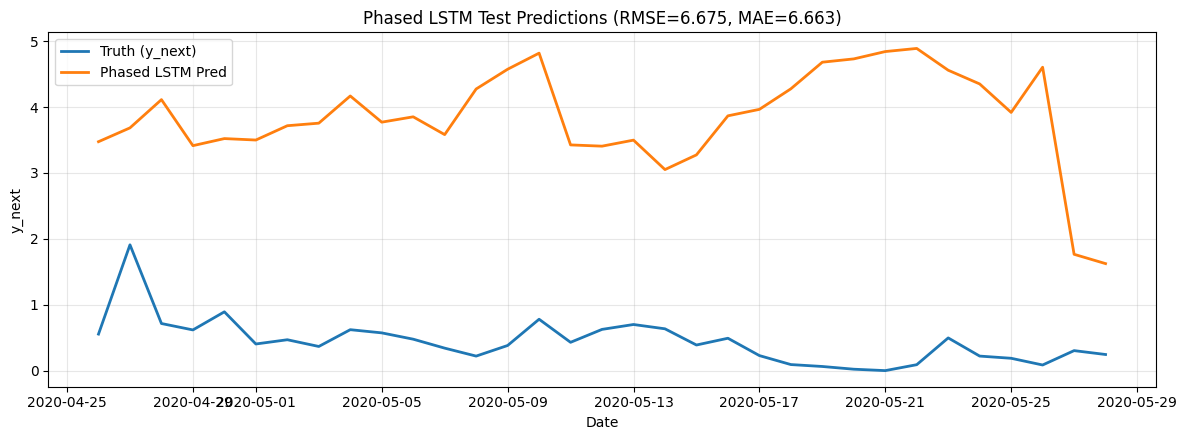

In [75]:
# Flatten
yhat_plstm_te  = np.concatenate(pred_list, axis=0).reshape(-1)
ytrue_plstm_te = np.concatenate(true_list,  axis=0).reshape(-1)

# Align dates to number of points
n_dates = len(dates_pd)
n_pts   = len(ytrue_plstm_te)
if n_pts != n_dates:
    plot_dates = dates_pd[-n_pts:]   # each sample predicts the window end
else:
    plot_dates = dates_pd

print(f"[Phased LSTM] plot points: dates={len(plot_dates)}, y={len(ytrue_plstm_te)}, yhat={len(yhat_plstm_te)}")

# Plot
plt.figure(figsize=(12,4.5))
plt.plot(plot_dates, ytrue_plstm_te, label="Truth (y_next)", linewidth=2)
plt.plot(plot_dates, yhat_plstm_te,  label="Phased LSTM Pred", linewidth=2)
plt.title(f"Phased LSTM Test Predictions (RMSE={te_rmse:.3f}, MAE={te_mae:.3f})")
plt.xlabel("Date"); plt.ylabel("y_next")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

# Nbeats

In [60]:
NEW_BESTPATH = "./castle_ckpts/Nbeats_fair_best.pt"
os.makedirs(os.path.dirname(NEW_BESTPATH), exist_ok=True)

In [61]:
class NBeatsBlock(nn.Module):
    def __init__(self, in_features: int, hidden: int, thetas_b: int, thetas_f: int, depth: int = 4):
        super().__init__()
        layers = []
        for i in range(depth):
            layers += [nn.Linear(in_features if i == 0 else hidden, hidden), nn.ReLU(inplace=True)]
        self.fc = nn.Sequential(*layers)
        self.theta_b = nn.Linear(hidden, thetas_b)  # backcast
        self.theta_f = nn.Linear(hidden, thetas_f)  # forecast

    def forward(self, x):
        h = self.fc(x)
        return self.theta_b(h), self.theta_f(h)

class NBeats(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int = 1, n_stacks: int = 2, n_blocks: int = 3, hidden: int = 256, depth: int = 4):
        super().__init__()
        self.blocks = nn.ModuleList(
            [NBeatsBlock(backcast_size, hidden, backcast_size, forecast_size, depth) for _ in range(n_stacks * n_blocks)]
        )

    def forward(self, x_flat):  # [B,F]
        residual = x_flat
        y_hat = 0.0
        for block in self.blocks:
            b, f = block(residual)
            residual = residual - b
            y_hat = y_hat + f
        return y_hat  # [B,1]

class NBeatsUnivariate(nn.Module):
    def __init__(self, T: int, D: int, **kw):
        super().__init__()
        self.T, self.D = T, D
        F = T * D
        self.core = NBeats(backcast_size=F, **kw)

    def forward(self, X):  # X: [B,T,D]
        B, T, D = X.shape
        assert T == self.T and D == self.D, f"Expected [B,{self.T},{self.D}], got {tuple(X.shape)}"
        x_flat = X.reshape(B, T * D)
        return self.core(x_flat)

In [62]:
def _to3d(x):
    if x.ndim == 3: return x
    if x.ndim == 2: return x.unsqueeze(-1)
    raise ValueError(f"Expected [B,T,?], got {tuple(x.shape)}")

def _get_target(b):
    # Prefer y_next; fallback to y_all if y_next not provided
    if "y_next" in b and b["y_next"] is not None:
        y = b["y_next"]
    else:
        y = b["y_all"]
    if y.ndim == 1: y = y[:, None]
    return y

def _build_Xy_from_batch(b):
    # Use ONLY anchor_all as input window
    x = torch.nan_to_num(b["anchor_all"], nan=0.0, posinf=0.0, neginf=0.0)
    x = _to3d(x)                 # [B,T,D_anchor] (D_anchor may be 1)
    y = _get_target(b)           # [B,1]
    return x, y

In [63]:
b0 = next(iter(dl_plstm_tr))  # dict from PLSTMLoader
X0, y0 = _build_Xy_from_batch(b0)
T_WIN, D_IN = X0.shape[1], X0.shape[2]
F_IN = T_WIN * D_IN
print(f"[N-BEATS uni] Window T={T_WIN}, D={D_IN}, flat F={F_IN} | target={'y_next' if ('y_next' in b0 and b0['y_next'] is not None) else 'y_all'}")

[N-BEATS uni] Window T=5, D=1, flat F=5 | target=y_all


In [64]:
model  = NBeatsUnivariate(T=T_WIN, D=D_IN, n_stacks=2, n_blocks=3, hidden=256, depth=4).to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched  = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5, min_lr=1e-5)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

/tmp/ipykernel_2173650/214917001.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [65]:
with torch.no_grad():
    mu  = torch.zeros(F_IN, device=device)
    cnt = 0
    for b in dl_plstm_tr:
        Xb, _ = _build_Xy_from_batch(b)
        # conform to fixed T_WIN by pad/trunc if needed
        if Xb.shape[1] != T_WIN:
            Xb = Xb[:, :min(Xb.shape[1], T_WIN), :]
            if Xb.shape[1] < T_WIN:
                pad = torch.zeros(Xb.shape[0], T_WIN - Xb.shape[1], Xb.shape[2], device=Xb.device)
                Xb = torch.cat([Xb, pad], dim=1)
        xf = Xb.reshape(Xb.size(0), -1).to(device)
        mu += xf.sum(dim=0); cnt += xf.size(0)
    mu /= max(cnt, 1)

    sqsum = torch.zeros_like(mu)
    for b in dl_plstm_tr:
        Xb, _ = _build_Xy_from_batch(b)
        if Xb.shape[1] != T_WIN:
            Xb = Xb[:, :min(Xb.shape[1], T_WIN), :]
            if Xb.shape[1] < T_WIN:
                pad = torch.zeros(Xb.shape[0], T_WIN - Xb.shape[1], Xb.shape[2], device=Xb.device)
                Xb = torch.cat([Xb, pad], dim=1)
        xf = Xb.reshape(Xb.size(0), -1).to(device)
        sqsum += ((xf - mu) ** 2).sum(dim=0)
    std = torch.sqrt(sqsum / max(cnt, 1)).clamp_min(1e-6)

def _norm_flat(x_flat):  # [B,F]
    return (x_flat - mu) / std

def _metrics(yhat, y):
    err = yhat - y
    rmse = torch.sqrt(torch.mean(err**2))
    mae  = torch.mean(torch.abs(err))
    mape = torch.mean(torch.abs(err) / (torch.abs(y) + 1e-6)) * 100.0
    ss_res = torch.sum(err**2)
    ss_tot = torch.sum((y - torch.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res/ss_tot
    return rmse.item(), mae.item(), mape.item(), r2.item()

In [66]:
best_va = float("inf"); bad_epochs = 0; patience = 12
print("[N-BEATS uni] Training… stacks=2, blocks/stack=3, hidden=256, depth=4")

for epoch in range(1, EPOCHS + 1):
    # TRAIN
    model.train()
    tr_rmse_sum = tr_mae_sum = tr_mape_sum = tr_ss_res = tr_ss_tot = 0.0
    tr_n = 0
    for b in dl_plstm_tr:
        Xb, y = _build_Xy_from_batch(b)
        if Xb.shape[1] != T_WIN:
            Xb = Xb[:, :min(Xb.shape[1], T_WIN), :]
            if Xb.shape[1] < T_WIN:
                pad = torch.zeros(Xb.shape[0], T_WIN - Xb.shape[1], Xb.shape[2], device=Xb.device)
                Xb = torch.cat([Xb, pad], dim=1)
        xf = Xb.reshape(Xb.size(0), -1).to(device)
        y  = y.to(device)

        xf = _norm_flat(xf)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
            yhat = model.core(xf)
            loss = torch.sqrt(torch.mean((yhat - y) ** 2))  # RMSE
        scaler.scale(loss).backward()
        if GRAD_CLIP and GRAD_CLIP > 0:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(opt); scaler.update()

        bs = xf.size(0)
        with torch.no_grad():
            rm, ma, mp, _ = _metrics(yhat, y)
            tr_rmse_sum += rm * bs
            tr_mae_sum  += ma * bs
            tr_mape_sum += mp * bs
            err = (yhat - y)
            tr_ss_res   += torch.sum(err**2).item()
            tr_ss_tot   += (torch.sum((y - torch.mean(y))**2).item() + 1e-12)
            tr_n        += bs

    tr_rmse = tr_rmse_sum / max(tr_n,1)
    tr_mae  = tr_mae_sum  / max(tr_n,1)
    tr_mape = tr_mape_sum / max(tr_n,1)
    tr_r2   = 1.0 - (tr_ss_res / tr_ss_tot)

    # VAL
    model.eval()
    va_rmse_sum = va_mae_sum = va_mape_sum = va_ss_res = va_ss_tot = 0.0
    va_n = 0
    with torch.no_grad():
        for b in dl_plstm_va:
            Xb, y = _build_Xy_from_batch(b)
            if Xb.shape[1] != T_WIN:
                Xb = Xb[:, :min(Xb.shape[1], T_WIN), :]
                if Xb.shape[1] < T_WIN:
                    pad = torch.zeros(Xb.shape[0], T_WIN - Xb.shape[1], Xb.shape[2], device=Xb.device)
                    Xb = torch.cat([Xb, pad], dim=1)
            xf = Xb.reshape(Xb.size(0), -1).to(device)
            y  = y.to(device)

            xf = _norm_flat(xf)
            yhat = model.core(xf)
            err  = yhat - y

            bs = xf.size(0)
            va_rmse_sum += torch.sqrt(torch.mean(err**2)).item() * bs
            va_mae_sum  += torch.mean(torch.abs(err)).item() * bs
            va_mape_sum += (torch.mean(torch.abs(err) / (torch.abs(y) + 1e-6)) * 100.0).item() * bs
            va_ss_res   += torch.sum(err**2).item()
            va_ss_tot   += (torch.sum((y - torch.mean(y))**2).item() + 1e-12)
            va_n        += bs

    va_rmse = va_rmse_sum / max(va_n,1)
    va_mae  = va_mae_sum  / max(va_n,1)
    va_mape = va_mape_sum / max(va_n,1)
    va_r2   = 1.0 - (va_ss_res / va_ss_tot)

    lr_now = opt.param_groups[0]["lr"]
    print(f"Epoch {epoch:03d}/{EPOCHS} | LR {lr_now:.2e} | "
          f"RMSE tr={tr_rmse:.4f} va={va_rmse:.4f} | "
          f"MAE tr={tr_mae:.4f} va={va_mae:.4f} | "
          f"MAPE tr={tr_mape:.2f}% va={va_mape:.2f}% | "
          f"R2 tr={tr_r2:.4f} va={va_r2:.4f}")

    sched.step(va_rmse)
    if va_rmse + 1e-6 < best_va:
        best_va = va_rmse; bad_epochs = 0
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "config": {"T": T_WIN, "D": D_IN, "n_stacks": 2, "n_blocks": 3, "hidden": 256, "depth": 4,
                       "lr": LR, "weight_decay": WEIGHT_DECAY},
            "norm": {"mu": mu.detach().cpu(), "std": std.detach().cpu()},
            "best_va_rmse": best_va,
            "target_name": "y_next" if ("y_next" in b0 and b0["y_next"] is not None) else "y_all",
            "input_name": "anchor_all"
        }, NEW_BESTPATH)
    else:
        bad_epochs += 1
        if bad_epochs >= 12:
            print(f"Early stopping at epoch {epoch}.")
            break

print(f"Saved best checkpoint to {NEW_BESTPATH} (best va_RMSE={best_va:.6f})")

[N-BEATS uni] Training… stacks=2, blocks/stack=3, hidden=256, depth=4


/tmp/ipykernel_2173650/1544246023.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):


Epoch 001/80 | LR 3.00e-04 | RMSE tr=8.8160 va=6.1021 | MAE tr=8.6345 va=5.7537 | MAPE tr=86.48% va=514.00% | R2 tr=-33.7466 va=-29.1647
Epoch 002/80 | LR 3.00e-04 | RMSE tr=4.0936 va=12.0649 | MAE tr=3.7528 va=11.0348 | MAPE tr=39.28% va=942.18% | R2 tr=-8.0597 va=-120.6649
Epoch 003/80 | LR 3.00e-04 | RMSE tr=3.0887 va=8.6897 | MAE tr=2.4775 va=7.9057 | MAPE tr=26.27% va=669.47% | R2 tr=-4.2114 va=-64.0417
Epoch 004/80 | LR 3.00e-04 | RMSE tr=1.9599 va=6.0713 | MAE tr=1.5425 va=5.6957 | MAPE tr=16.16% va=522.48% | R2 tr=-1.1280 va=-33.7942
Epoch 005/80 | LR 3.00e-04 | RMSE tr=1.4037 va=4.4227 | MAE tr=1.1120 va=4.1968 | MAPE tr=12.06% va=398.94% | R2 tr=0.1127 va=-18.1687
Epoch 006/80 | LR 3.00e-04 | RMSE tr=1.0907 va=5.3054 | MAE tr=0.8726 va=4.9860 | MAPE tr=9.33% va=464.53% | R2 tr=0.4229 va=-25.1355
Epoch 007/80 | LR 3.00e-04 | RMSE tr=1.1135 va=5.1595 | MAE tr=0.9065 va=4.8507 | MAPE tr=10.20% va=442.51% | R2 tr=0.3223 va=-23.3417
Epoch 008/80 | LR 3.00e-04 | RMSE tr=0.7851 va=4

In [67]:
blob = torch.load(NEW_BESTPATH, map_location=device)
cfg  = blob["config"]
model = NBeatsUnivariate(T=cfg["T"], D=cfg["D"],
                         n_stacks=cfg["n_stacks"], n_blocks=cfg["n_blocks"],
                         hidden=cfg["hidden"], depth=cfg["depth"]).to(device)
model.load_state_dict(blob["model_state"]); model.eval()

mu  = blob["norm"]["mu"].to(device)
std = blob["norm"]["std"].to(device).clamp_min(1e-6)

te_rmse_sum = te_mae_sum = te_mape_sum = te_ss_res = te_ss_tot = 0.0
te_n = 0

with torch.no_grad():
    for b in dl_plstm_te:
        Xb, y = _build_Xy_from_batch(b)
        if Xb.shape[1] != cfg["T"]:
            Xb = Xb[:, :min(Xb.shape[1], cfg["T"]), :]
            if Xb.shape[1] < cfg["T"]:
                pad = torch.zeros(Xb.shape[0], cfg["T"] - Xb.shape[1], Xb.shape[2], device=Xb.device)
                Xb = torch.cat([Xb, pad], dim=1)
        xf = Xb.reshape(Xb.size(0), -1).to(device)
        y  = y.to(device)

        xf = (xf - mu) / std
        yhat = model.core(xf)
        err  = yhat - y

        bs = xf.size(0)
        te_rmse_sum += torch.sqrt(torch.mean(err**2)).item() * bs
        te_mae_sum  += torch.mean(torch.abs(err)).item() * bs
        te_ss_res   += torch.sum(err**2).item()
        te_ss_tot   += (torch.sum((y - torch.mean(y))**2).item() + 1e-12)
        te_n        += bs

te_rmse = te_rmse_sum / max(te_n,1)
te_mae  = te_mae_sum  / max(te_n,1)
print("=== TEST RESULTS (N-BEATS univariate, anchor_all → y_next) ===")
print(f"RMSE: {te_rmse:.6f}")
print(f"MAE : {te_mae:.6f}")

=== TEST RESULTS (N-BEATS univariate, anchor_all → y_next) ===
RMSE: 6.675458
MAE : 6.663301


/tmp/ipykernel_2173650/4219011865.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blob = torch.load(NEW_BESTPATH, map_location=device)


[N-BEATS] plot points: dates=33, y=33, yhat=33


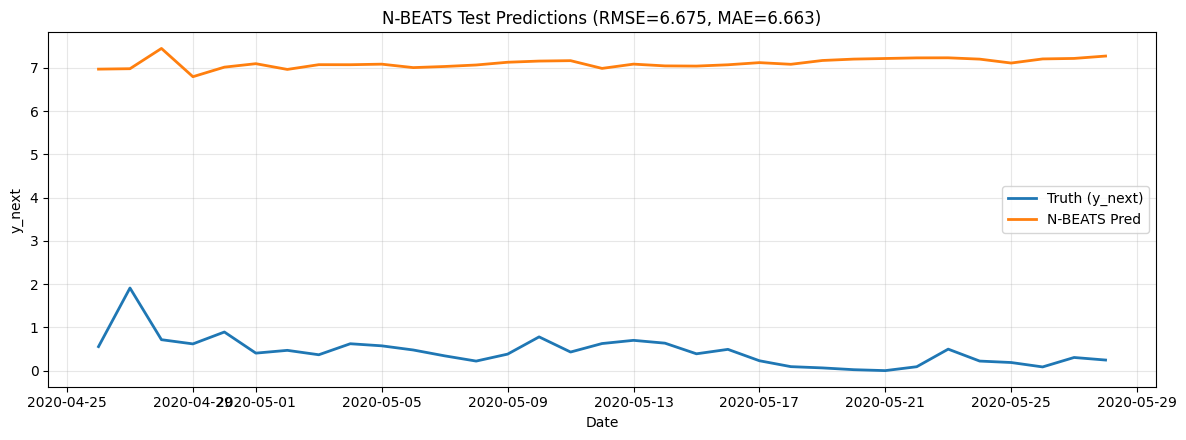

In [74]:
# Flatten
yhat_nbeats_te  = np.concatenate(yhat_nbeats_list, axis=0).reshape(-1)
ytrue_nbeats_te = np.concatenate(y_nbeats_list,  axis=0).reshape(-1)

# Align dates length with predictions/targets
n_dates = len(dates_pd)
n_pts   = len(ytrue_nbeats_te)
if n_pts != n_dates:
    # Use the most recent n_pts dates (each sample's target is the window end)
    plot_dates = dates_pd[-n_pts:]
else:
    plot_dates = dates_pd

# (Optional) sanity print
print(f"[N-BEATS] plot points: dates={len(plot_dates)}, y={len(ytrue_nbeats_te)}, yhat={len(yhat_nbeats_te)}")

# Plot
plt.figure(figsize=(12,4.5))
plt.plot(plot_dates, ytrue_nbeats_te, label="Truth (y_next)", linewidth=2)
plt.plot(plot_dates, yhat_nbeats_te,  label="N-BEATS Pred",   linewidth=2)
plt.title(f"N-BEATS Test Predictions (RMSE={te_rmse:.3f}, MAE={te_mae:.3f})")
plt.xlabel("Date"); plt.ylabel("y_next")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

# Comparing all metrics

In [69]:
from typing import Iterable
def _to_np(x):
    try:
        import torch
        if hasattr(x, "detach"):
            x = x.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x)

# ---------- 1) Exact mode (arrays) ----------
def compare_from_arrays(
    y_true,
    preds: dict[str, np.ndarray],
    tau_abs: Iterable[float] = (0.20,),
    tau_pct: Iterable[float] = (),
) -> dict[str, dict[str, float]]:
    """Compute exact hit/exceed rates from predictions."""
    y = _to_np(y_true).astype(float).reshape(-1)
    masky = np.isfinite(y)
    out = {}
    for name, yhat in preds.items():
        yhat = _to_np(yhat).astype(float).reshape(-1)
        mask = masky & np.isfinite(yhat)
        e = np.abs(yhat[mask] - y[mask])
        res = {}
        for t in tau_abs:
            hit = (e <= t).mean()
            res[f"acc@{t:g}"] = float(hit)
            res[f"WrongPredict@{t:g}"] = float(1.0 - hit)
        for k in tau_pct:
            thr = k * np.maximum(np.abs(y[mask]), 1e-8)
            hit = (e <= thr).mean()
            tag = f"{int(round(k*100))}%"
            res[f"acc@{tag}"] = float(hit)
            res[f"WrongPredict@{tag}"] = float(1.0 - hit)
        out[name] = res
    return out

# ---------- 2) Metrics-only mode (estimates) ----------
def compare_from_metrics(
    metrics: dict[str, dict[str, float]],
    tau_abs: Iterable[float] = (0.20,),
    assumption: str = "laplace",
) -> dict[str, dict[str, float]]:
    """
    Estimate exceedance P(|E|>tau) from summary stats:
      - 'laplace'  uses MAE (b = MAE)        -> P(|E|>τ) = exp(-τ / b)
      - 'gaussian' uses RMSE (σ = RMSE)      -> P(|E|>τ) = 2*(1 - Φ(τ/σ))
    """
    from math import erf, sqrt, exp

    def Phi(z):  # standard normal CDF
        return 0.5 * (1.0 + erf(z / sqrt(2.0)))

    out = {}
    for name, m in metrics.items():
        res = {}
        for t in tau_abs:
            if assumption.lower().startswith("lap"):
                b = float(m["MAE"])
                p_exceed = float(exp(-t / max(b, 1e-12)))
            else:
                sigma = float(m["RMSE"])
                p_exceed = float(2.0 * (1.0 - Phi(t / max(sigma, 1e-12))))
            res[f"WrongPredict@{t:g}"] = p_exceed
            res[f"acc@{t:g}"] = 1.0 - p_exceed
        out[name] = res
    return out

# ---------- Pretty-printer ----------
def print_wrong_table(results: dict[str, dict[str, float]]):
    models = list(results.keys())
    keys = list(next(iter(results.values())).keys())
    widths = [max(len("Model"), max(len(m) for m in models))]
    widths += [max(len(k), 8) for k in keys]

    def fmt_row(vals):
        return " | ".join(str(v).ljust(w) for v, w in zip(vals, widths))

    header = ["Model"] + keys
    print(fmt_row(header))
    print("-+-".join("-"*w for w in widths))
    for m in models:
        row = [m] + [f"{results[m][k]*100:5.1f}%" if "acc@" in k or "WrongPredict@" in k else f"{results[m][k]:.4f}" for k in keys]
        print(fmt_row(row))

In [72]:
metrics = {
    "CASTLE": {"MAE": 0.271090, "RMSE": 0.359655},
    "GRU-D" : {"MAE": 0.454532, "RMSE": 0.566880},
    "P-LSTM": {"MAE": 3.553420, "RMSE": 3.609958},
    "NBeats": {"MAE": 6.663301, "RMSE": 6.675458}
}
res_est = compare_from_metrics(metrics, tau_abs=(0.20, 0.30), assumption="laplace")
print_wrong_table(res_est)

Model  | WrongPredict@0.2 | acc@0.2  | WrongPredict@0.3 | acc@0.3 
-------+------------------+----------+------------------+---------
CASTLE |  47.8%           |  52.2%   |  33.1%           |  66.9%  
GRU-D  |  64.4%           |  35.6%   |  51.7%           |  48.3%  
P-LSTM |  94.5%           |   5.5%   |  91.9%           |   8.1%  
NBeats |  97.0%           |   3.0%   |  95.6%           |   4.4%  


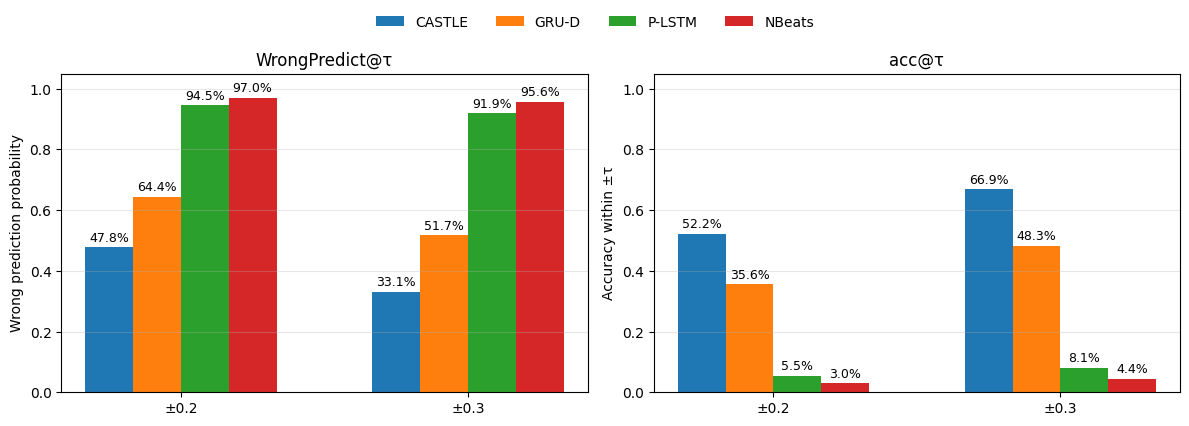

In [73]:
taus = [0.20, 0.30]
wrong_keys = [f"WrongPredict@{t:g}" for t in taus]
acc_keys   = [f"acc@{t:g}"          for t in taus]

# lock model order for consistent colors
models = [m for m in ["CASTLE","GRU-D","P-LSTM","NBeats"] if m in res_est]

wrong = np.array([[res_est[m][k] for k in wrong_keys] for m in models])  # [M,T]
acc   = np.array([[res_est[m][k] for k in acc_keys]   for m in models])  # [M,T]

x = np.arange(len(taus))            # groups (thresholds)
M = len(models)
width = 0.75 / (M + 0.5)            # slimmer bars to avoid overlap
offsets = (np.arange(M) - (M-1)/2) * width

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # default palette
colors = (colors * ((M // len(colors)) + 1))[:M]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.2), sharex=True, sharey=False)

# ---- WrongPredict panel ----
for i, m in enumerate(models):
    xi = x + offsets[i]
    bars = ax1.bar(xi, wrong[i], width, label=m, color=colors[i])
    for b in bars:
        h = b.get_height()
        ax1.text(b.get_x()+b.get_width()/2, h+0.01, f"{h*100:.1f}%", ha="center", va="bottom", fontsize=9)

ax1.set_xticks(x)
ax1.set_xticklabels([f"±{t:g}" for t in taus])
ax1.set_ylim(0, 1.05)
ax1.set_ylabel("Wrong prediction probability")
ax1.set_title("WrongPredict@τ")

# ---- Accuracy panel ----
for i, m in enumerate(models):
    xi = x + offsets[i]
    bars = ax2.bar(xi, acc[i], width, label=m, color=colors[i])
    for b in bars:
        h = b.get_height()
        ax2.text(b.get_x()+b.get_width()/2, h+0.01, f"{h*100:.1f}%", ha="center", va="bottom", fontsize=9)

ax2.set_xticks(x)
ax2.set_xticklabels([f"±{t:g}" for t in taus])
ax2.set_ylim(0, 1.05)
ax2.set_ylabel("Accuracy within ±τ")
ax2.set_title("acc@τ")

# shared legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, ncol=min(M,4), loc="upper center", frameon=False, bbox_to_anchor=(0.5, 1.02))

for ax in (ax1, ax2):
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout(rect=(0,0,1,0.94))
plt.show()